# MediaDive Top Solutions Analysis

**Goal**: Understand the relationships between solutions, ingredients, media, and strains to inform prediction model design.

**Strategy**: Focus on the **top 50 solutions** (by media association count from TOPMEDIA.md) to keep API calls light (~100 requests). We fetch solution details for ingredient composition, sample media to see which solutions compose them, and pull strain associations for coverage analysis.

**Data flow**: `Solutions → Ingredients` | `Media → Solutions` | `Media → Strains → Taxa`

## 1. Import Libraries and Configure Environment

In [1]:
import json
import re
import time
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import requests
import seaborn as sns

# Optional — Plotly for Sankey
try:
    import plotly.graph_objects as go
    HAS_PLOTLY = True
except ImportError:
    HAS_PLOTLY = False
    print("plotly not installed — Sankey diagram will be skipped")

# ── Visualization defaults ──────────────────────────────────
sns.set_theme(style="darkgrid", palette="viridis")
plt.rcParams.update({
    "figure.figsize": (14, 7),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "figure.dpi": 110,
})
pd.set_option("display.max_columns", 40)
pd.set_option("display.max_rows", 80)
pd.set_option("display.max_colwidth", 60)

# ── API helper ──────────────────────────────────────────────
BASE_URL = "https://mediadive.dsmz.de/rest"
DELAY = 0.3  # seconds between API calls

_cache: dict[str, dict] = {}

def api_get(endpoint: str, params: dict | None = None) -> dict:
    """GET JSON from the MediaDive API with in-memory caching."""
    key = f"{endpoint}|{sorted(params.items()) if params else ''}"
    if key in _cache:
        return _cache[key]
    url = f"{BASE_URL}{endpoint}"
    r = requests.get(url, params=params, headers={"Accept": "application/json"}, timeout=30)
    r.raise_for_status()
    data = r.json()
    _cache[key] = data
    time.sleep(DELAY)
    return data

print("Setup complete ✓")

Setup complete ✓


## 2. Load Database Overview from API

Fetch high-level stats and the full solutions list. This is cheap — 2 API calls.

In [2]:
# ── Global stats ────────────────────────────────────────────
stats = api_get("/stats")["data"]
print("=== MediaDive Database Stats ===")
print(f"  Media:       {stats['media']['defined'] + stats['media']['complex']:,}  "
      f"({stats['media']['defined']} defined, {stats['media']['complex']} complex)")
print(f"  Ingredients: {stats['ingredients']:,}")
print(f"  Solutions:   {stats['solutions']:,}")
total_strains = sum(v for v in stats["strains"].values() if isinstance(v, int))
print(f"  Strains:     {total_strains:,}")
total_growth = sum(v for v in stats["growth"].values() if isinstance(v, int))
print(f"  Growth obs:  {total_growth:,}")

# ── pH distribution (free from /stats) ──────────────────────
ph_dist = {float(k): v for k, v in stats["pH"].items()}
print(f"\n  pH range:    {min(ph_dist):.0f}–{max(ph_dist):.0f}")

# ── Full solutions list ─────────────────────────────────────
all_solutions_resp = api_get("/solutions", {"all": 1})
all_solutions = pd.DataFrame(all_solutions_resp["data"])
print(f"\n  Solutions loaded: {len(all_solutions):,}")
all_solutions.head()

=== MediaDive Database Stats ===
  Media:       3,327  (660 defined, 2667 complex)
  Ingredients: 1,237
  Solutions:   5,867
  Strains:     47,940
  Growth obs:  72,931

  pH range:    1–12

  Solutions loaded: 5,867


id          name  volume
0   1   Main sol. 1  1000.0
1   3  Main sol. 1a  1000.0
2   4   Main sol. 2  1000.0
3   5   Main sol. 3  1000.0
4   6   Main sol. 6  1000.0

## 3. Parse Top 50 Solutions from TOPMEDIA.md

The file lists solution names + media counts (how many media each solution appears in). We fuzzy-match these against the full solutions list to get their IDs.

In [4]:
# ── Parse TOPMEDIA.md ────────────────────────────────────────
# Each line: "Solution Name\tVolume,\tMediaCount"
# Parsing is a bit messy because tabs/commas are mixed.

topmedia_path = Path("../src/api/AGENT/TOPMEDIA.md")
raw_lines = topmedia_path.read_text().strip().splitlines()

top_entries = []
for line in raw_lines:
    line = line.strip()
    if not line:
        continue
    # Extract the trailing number (media count) — always last integer on the line
    match = re.search(r"(\d+)\s*$", line)
    if not match:
        continue
    media_count = int(match.group(1))

    # Extract name: everything before the volume pattern "NNNN ml"
    name_match = re.match(r'^"?(.+?)"?\s+\d+\s*ml', line)
    if not name_match:
        # Try without volume
        name_match = re.match(r'^"?(.+?)"?\s*,', line)
    name = name_match.group(1).strip().strip('"') if name_match else line.split(",")[0].strip().strip('"')

    top_entries.append({"name_raw": name, "media_count": media_count})

top_df = pd.DataFrame(top_entries)
print(f"Parsed {len(top_df)} solutions from TOPMEDIA.md")

# ── Fuzzy match to solutions list ───────────────────────────
# Normalize names for matching
def normalize(s) -> str:
    return re.sub(r"\s+", " ", str(s).strip().lower())

sol_lookup = {normalize(row["name"]): row["id"] for _, row in all_solutions.iterrows()}

matched = []
for _, row in top_df.iterrows():
    norm = normalize(row["name_raw"])
    # Try exact match first
    sol_id = sol_lookup.get(norm)
    if sol_id is None:
        # Try substring match
        candidates = [(k, v) for k, v in sol_lookup.items() if norm in k or k in norm]
        if candidates:
            sol_id = candidates[0][1]
    matched.append(sol_id)

top_df["solution_id"] = matched
matched_count = top_df["solution_id"].notna().sum()
print(f"Matched {matched_count}/{len(top_df)} solutions to API IDs")

# Show matches
top_df_clean = top_df.dropna(subset=["solution_id"]).copy()
top_df_clean["solution_id"] = top_df_clean["solution_id"].astype(int)
top_df_clean = top_df_clean.sort_values("media_count", ascending=False).reset_index(drop=True)

top_df_clean.head(15)

Parsed 50 solutions from TOPMEDIA.md
Matched 50/50 solutions to API IDs


name_raw  media_count  solution_id
0            Wolin's vitamin solution (10x)          309         5980
1              Trace element solution SL-10          267         4178
2                            Trace vitamins          221         5469
3               Selenite-tungstate solution          180         6455
4         Modified Wolin's mineral solution          169          241
5                            Trace minerals           98         5363
6                    Trace element solution           90         6520
7                            FeCl2 solution           88         3846
8                   Seven vitamins solution           78         4611
9               Selenite-tungstate solution           72         6455
10              Trace element solution SL-6           56           25
11                 Wolin's vitamin solution           55         5979
12                   Trace element solution           39         6520
13                                Metals 44           35         3222
14  Trace elements solution (Pfennig, 1965)           29         2762

## 4. Fetch Solution Details (Ingredients)

For each matched top solution, fetch `/solution/:id` to get its full recipe (ingredient list with concentrations). ~30-40 API calls.

In [5]:
# ── Fetch recipe details for each top solution ───────────────
solution_details = {}
recipe_rows = []

for i, row in top_df_clean.iterrows():
    sol_id = row["solution_id"]
    try:
        resp = api_get(f"/solution/{sol_id}")
        detail = resp["data"]
        solution_details[sol_id] = detail
        for item in detail.get("recipe", []):
            recipe_rows.append({
                "solution_id": sol_id,
                "solution_name": detail["name"],
                "compound_id": item.get("compound_id"),
                "compound": item.get("compound", "unknown"),
                "g_l": item.get("g_l"),
                "amount": item.get("amount"),
                "unit": item.get("unit"),
                "optional": item.get("optional", 0),
            })
    except Exception as e:
        print(f"  ⚠ Failed solution {sol_id}: {e}")

recipe_df = pd.DataFrame(recipe_rows)
print(f"Fetched {len(solution_details)} solution details")
print(f"Total recipe entries: {len(recipe_df)}")
print(f"Unique compounds: {recipe_df['compound'].nunique()}")

recipe_df.head(10)

Fetched 42 solution details
Total recipe entries: 334
Unique compounds: 78


solution_id                   solution_name  compound_id  \
0         5980  Wolin's vitamin solution (10x)         46.0   
1         5980  Wolin's vitamin solution (10x)        138.0   
2         5980  Wolin's vitamin solution (10x)        519.0   
3         5980  Wolin's vitamin solution (10x)       1207.0   
4         5980  Wolin's vitamin solution (10x)        136.0   
5         5980  Wolin's vitamin solution (10x)        139.0   
6         5980  Wolin's vitamin solution (10x)       1512.0   
7         5980  Wolin's vitamin solution (10x)         18.0   
8         5980  Wolin's vitamin solution (10x)         47.0   
9         5980  Wolin's vitamin solution (10x)        252.0   

                     compound    g_l  amount unit  optional  
0                      Biotin  0.020    20.0   mg         0  
1                  Folic acid  0.020    20.0   mg         0  
2    Pyridoxine hydrochloride  0.100   100.0   mg         0  
3                Thiamine HCl  0.050    50.0   mg         0  
4                  Riboflavin  0.050    50.0   mg         0  
5              Nicotinic acid  0.050    50.0   mg         0  
6  Calcium D-(+)-pantothenate  0.050    50.0   mg         0  
7                 Vitamin B12  0.001     1.0   mg         0  
8         p-Aminobenzoic acid  0.050    50.0   mg         0  
9      (DL)-alpha-Lipoic acid  0.050    50.0   mg         0

## 5. Fetch Sample Media and Their Strains

Fetch detail for ~50 media to see which of our top solutions they use and which strains grow on them. We sample from the first 200 media in the paginated list.

In [6]:
# ── Fetch a page of media IDs ────────────────────────────────
media_page = api_get("/media", {"limit": 200, "offset": 0})
media_list = media_page["data"]
print(f"Got {len(media_list)} media from first page (of {media_page['count']} total)")

# Sample 50 for detailed fetching
np.random.seed(42)
sample_ids = np.random.choice([m["id"] for m in media_list], size=min(50, len(media_list)), replace=False)

# ── Fetch medium detail + strains for sampled media ─────────
media_details = {}
media_solution_links = []  # (medium_id, solution_id)
media_strain_rows = []

for mid in sample_ids:
    try:
        # Medium detail (includes solutions + recipes)
        resp = api_get(f"/medium/{mid}")
        detail = resp["data"]
        medium_info = detail["medium"]
        media_details[mid] = medium_info

        for sol in detail.get("solutions", []):
            media_solution_links.append({
                "medium_id": mid,
                "medium_name": medium_info["name"],
                "solution_id": sol["id"],
                "solution_name": sol["name"],
            })

        # Strain associations
        strain_resp = api_get(f"/medium-strains/{mid}")
        strains = strain_resp.get("data", [])
        for s in strains:
            media_strain_rows.append({
                "medium_id": mid,
                "medium_name": medium_info["name"],
                "strain_id": s.get("id"),
                "species": s.get("species"),
                "growth": s.get("growth"),
                "domain": s.get("domain", "?"),
            })
    except Exception as e:
        print(f"  ⚠ Failed medium {mid}: {e}")

media_sol_df = pd.DataFrame(media_solution_links)
media_strain_df = pd.DataFrame(media_strain_rows)
media_info_df = pd.DataFrame(media_details.values())

print(f"\nFetched {len(media_details)} media details")
print(f"  Media ↔ Solution links: {len(media_sol_df)}")
print(f"  Media ↔ Strain links:   {len(media_strain_df)}")
print(f"  Unique strains seen:     {media_strain_df['strain_id'].nunique() if len(media_strain_df) else 0}")

Got 200 media from first page (of 3327 total)
  ⚠ Failed medium 46: 404 Client Error: Not Found for url: https://mediadive.dsmz.de/rest/medium-strains/46

Fetched 50 media details
  Media ↔ Solution links: 149
  Media ↔ Strain links:   881
  Unique strains seen:     873


## 6. Aggregate Ingredient Composition for Top Solutions

Which ingredients are the backbone of microbial culture media?

In [7]:
# ── Ingredient frequency across top solutions ────────────────
compound_freq = recipe_df.groupby("compound")["solution_id"].nunique().sort_values(ascending=False)
total_solutions = top_df_clean["solution_id"].nunique()

print(f"Ingredients appearing in >50% of top solutions ({total_solutions} solutions):")
core_ingredients = compound_freq[compound_freq >= total_solutions * 0.5]
for name, count in core_ingredients.items():
    pct = count / total_solutions * 100
    print(f"  {name}: {count}/{total_solutions} ({pct:.0f}%)")

print(f"\nIngredients appearing in >25% of top solutions:")
common_ingredients = compound_freq[compound_freq >= total_solutions * 0.25]
for name, count in common_ingredients.items():
    pct = count / total_solutions * 100
    print(f"  {name}: {count}/{total_solutions} ({pct:.0f}%)")

# ── Categorize solutions by type ─────────────────────────────
def categorize_solution(name: str) -> str:
    nl = name.lower()
    if "vitamin" in nl:
        return "Vitamin"
    elif "trace" in nl or "mineral" in nl or "metal" in nl or "sl-" in nl:
        return "Trace Element"
    elif "main sol" in nl:
        return "Main Solution"
    elif "selenite" in nl or "tungstate" in nl:
        return "Trace Element"
    elif "rumen" in nl or "extract" in nl or "soil" in nl:
        return "Biological Extract"
    elif "seawater" in nl:
        return "Seawater"
    else:
        return "Other"

top_df_clean["category"] = top_df_clean["name_raw"].apply(categorize_solution)
print(f"\nSolution categories:")
print(top_df_clean["category"].value_counts().to_string())

Ingredients appearing in >50% of top solutions (42 solutions):
  Distilled water: 29/42 (69%)

Ingredients appearing in >25% of top solutions:
  Distilled water: 29/42 (69%)
  Na2MoO4 x 2 H2O: 13/42 (31%)
  ZnSO4 x 7 H2O: 11/42 (26%)

Solution categories:
category
Trace Element         20
Vitamin               12
Other                 11
Main Solution          4
Biological Extract     2
Seawater               1


## 7. Visualize Solution-to-Media Coverage (Bar Chart)

Top solutions ranked by how many media they appear in, with cumulative coverage.

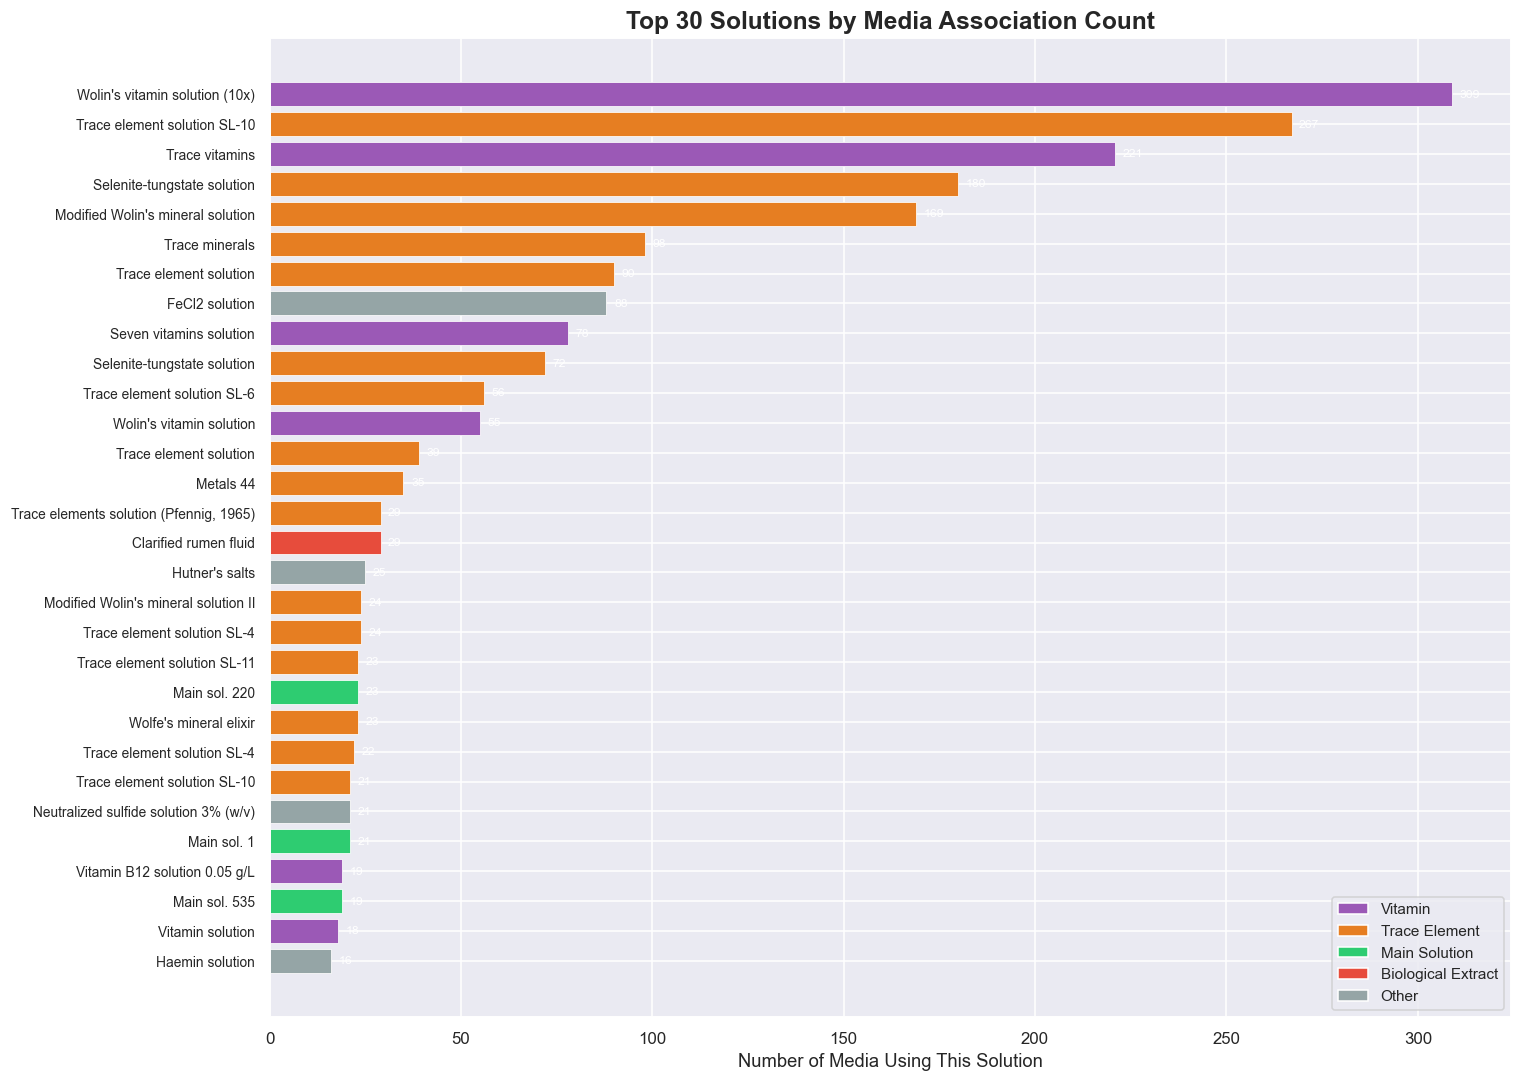

In [8]:
# ── Bar chart: Top solutions by media count ──────────────────
fig, ax1 = plt.subplots(figsize=(14, 10))

plot_data = top_df_clean.head(30).sort_values("media_count", ascending=True)

# Color by category
cat_colors = {
    "Vitamin": "#9b59b6",
    "Trace Element": "#e67e22",
    "Main Solution": "#2ecc71",
    "Biological Extract": "#e74c3c",
    "Seawater": "#3498db",
    "Other": "#95a5a6",
}
colors = [cat_colors.get(c, "#95a5a6") for c in plot_data["category"]]

bars = ax1.barh(range(len(plot_data)), plot_data["media_count"], color=colors, edgecolor="white", linewidth=0.5)
ax1.set_yticks(range(len(plot_data)))
ax1.set_yticklabels(plot_data["name_raw"], fontsize=9)
ax1.set_xlabel("Number of Media Using This Solution")
ax1.set_title("Top 30 Solutions by Media Association Count", fontsize=16, fontweight="bold")

# Add count labels
for bar, count in zip(bars, plot_data["media_count"]):
    ax1.text(bar.get_width() + 2, bar.get_y() + bar.get_height() / 2,
             str(count), va="center", fontsize=8, color="white")

# Legend for categories
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor=c, label=cat) for cat, c in cat_colors.items() if cat in plot_data["category"].values]
ax1.legend(handles=legend_patches, loc="lower right", fontsize=10)

plt.tight_layout()
plt.show()

## 8. Media-to-Strain Coverage (Bar Chart)

For our sampled media, how many unique strains does each support?

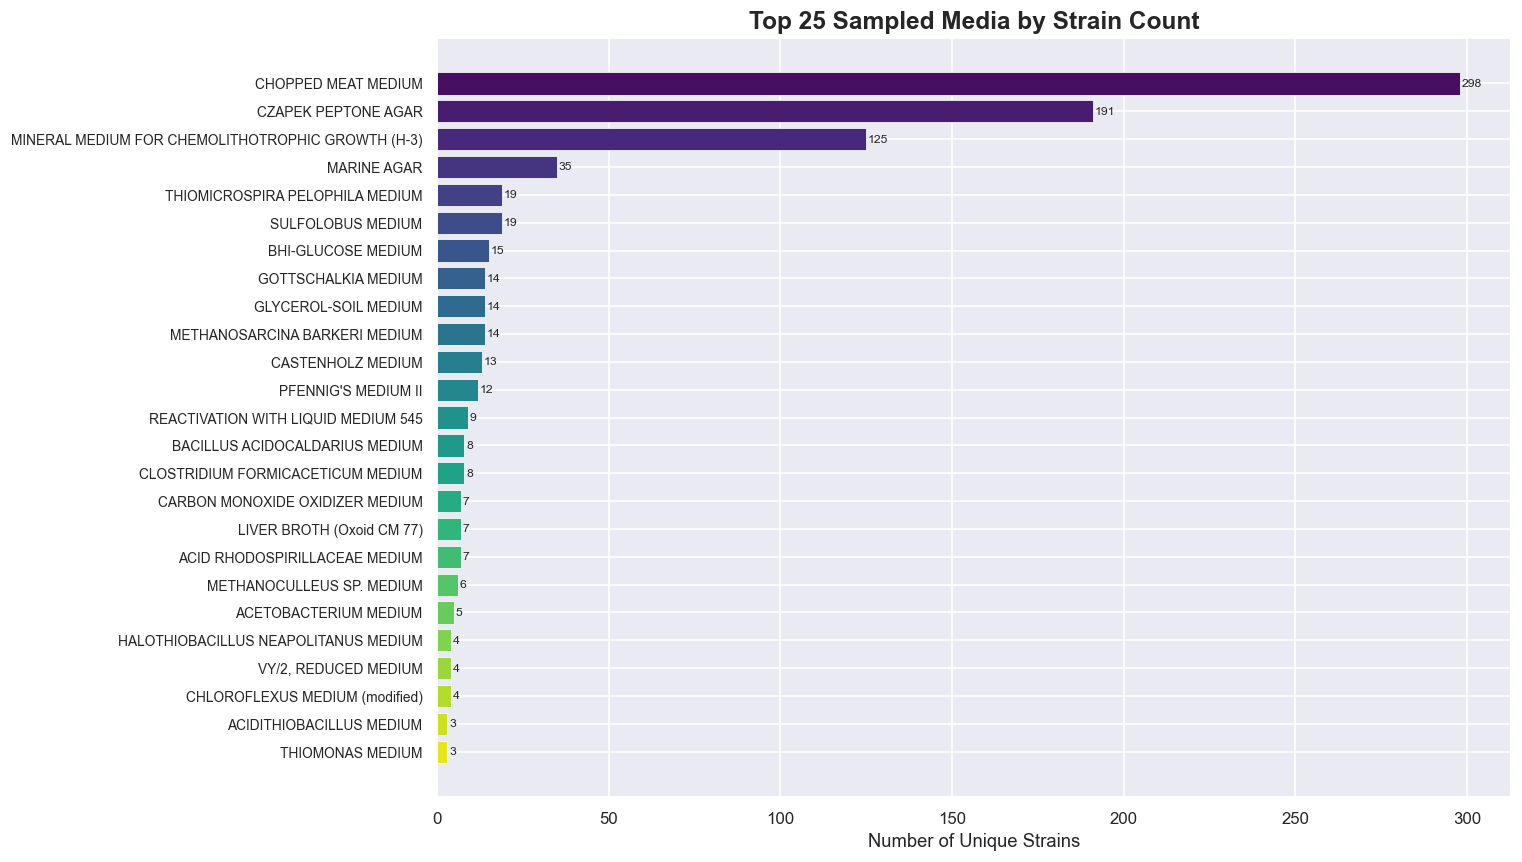


Total unique strains across sampled media: 873


In [9]:
# ── Media ranked by strain count ─────────────────────────────
if len(media_strain_df) > 0:
    strain_per_media = (
        media_strain_df.groupby(["medium_id", "medium_name"])["strain_id"]
        .nunique()
        .reset_index()
        .rename(columns={"strain_id": "strain_count"})
        .sort_values("strain_count", ascending=False)
    )

    top_media = strain_per_media.head(25)

    fig, ax = plt.subplots(figsize=(14, 8))
    bars = ax.barh(
        range(len(top_media)),
        top_media["strain_count"].values,
        color=sns.color_palette("viridis", len(top_media)),
        edgecolor="white",
        linewidth=0.5,
    )
    ax.set_yticks(range(len(top_media)))
    ax.set_yticklabels(top_media["medium_name"].values, fontsize=9)
    ax.set_xlabel("Number of Unique Strains")
    ax.set_title("Top 25 Sampled Media by Strain Count", fontsize=16, fontweight="bold")
    ax.invert_yaxis()

    for bar, count in zip(bars, top_media["strain_count"].values):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
                str(count), va="center", fontsize=8)

    plt.tight_layout()
    plt.show()

    print(f"\nTotal unique strains across sampled media: {media_strain_df['strain_id'].nunique()}")
else:
    print("No strain data fetched — check API connectivity.")

## 9. Solution → Media Bipartite Network

Which solutions cluster together in the same media? Visualized as a bipartite graph.

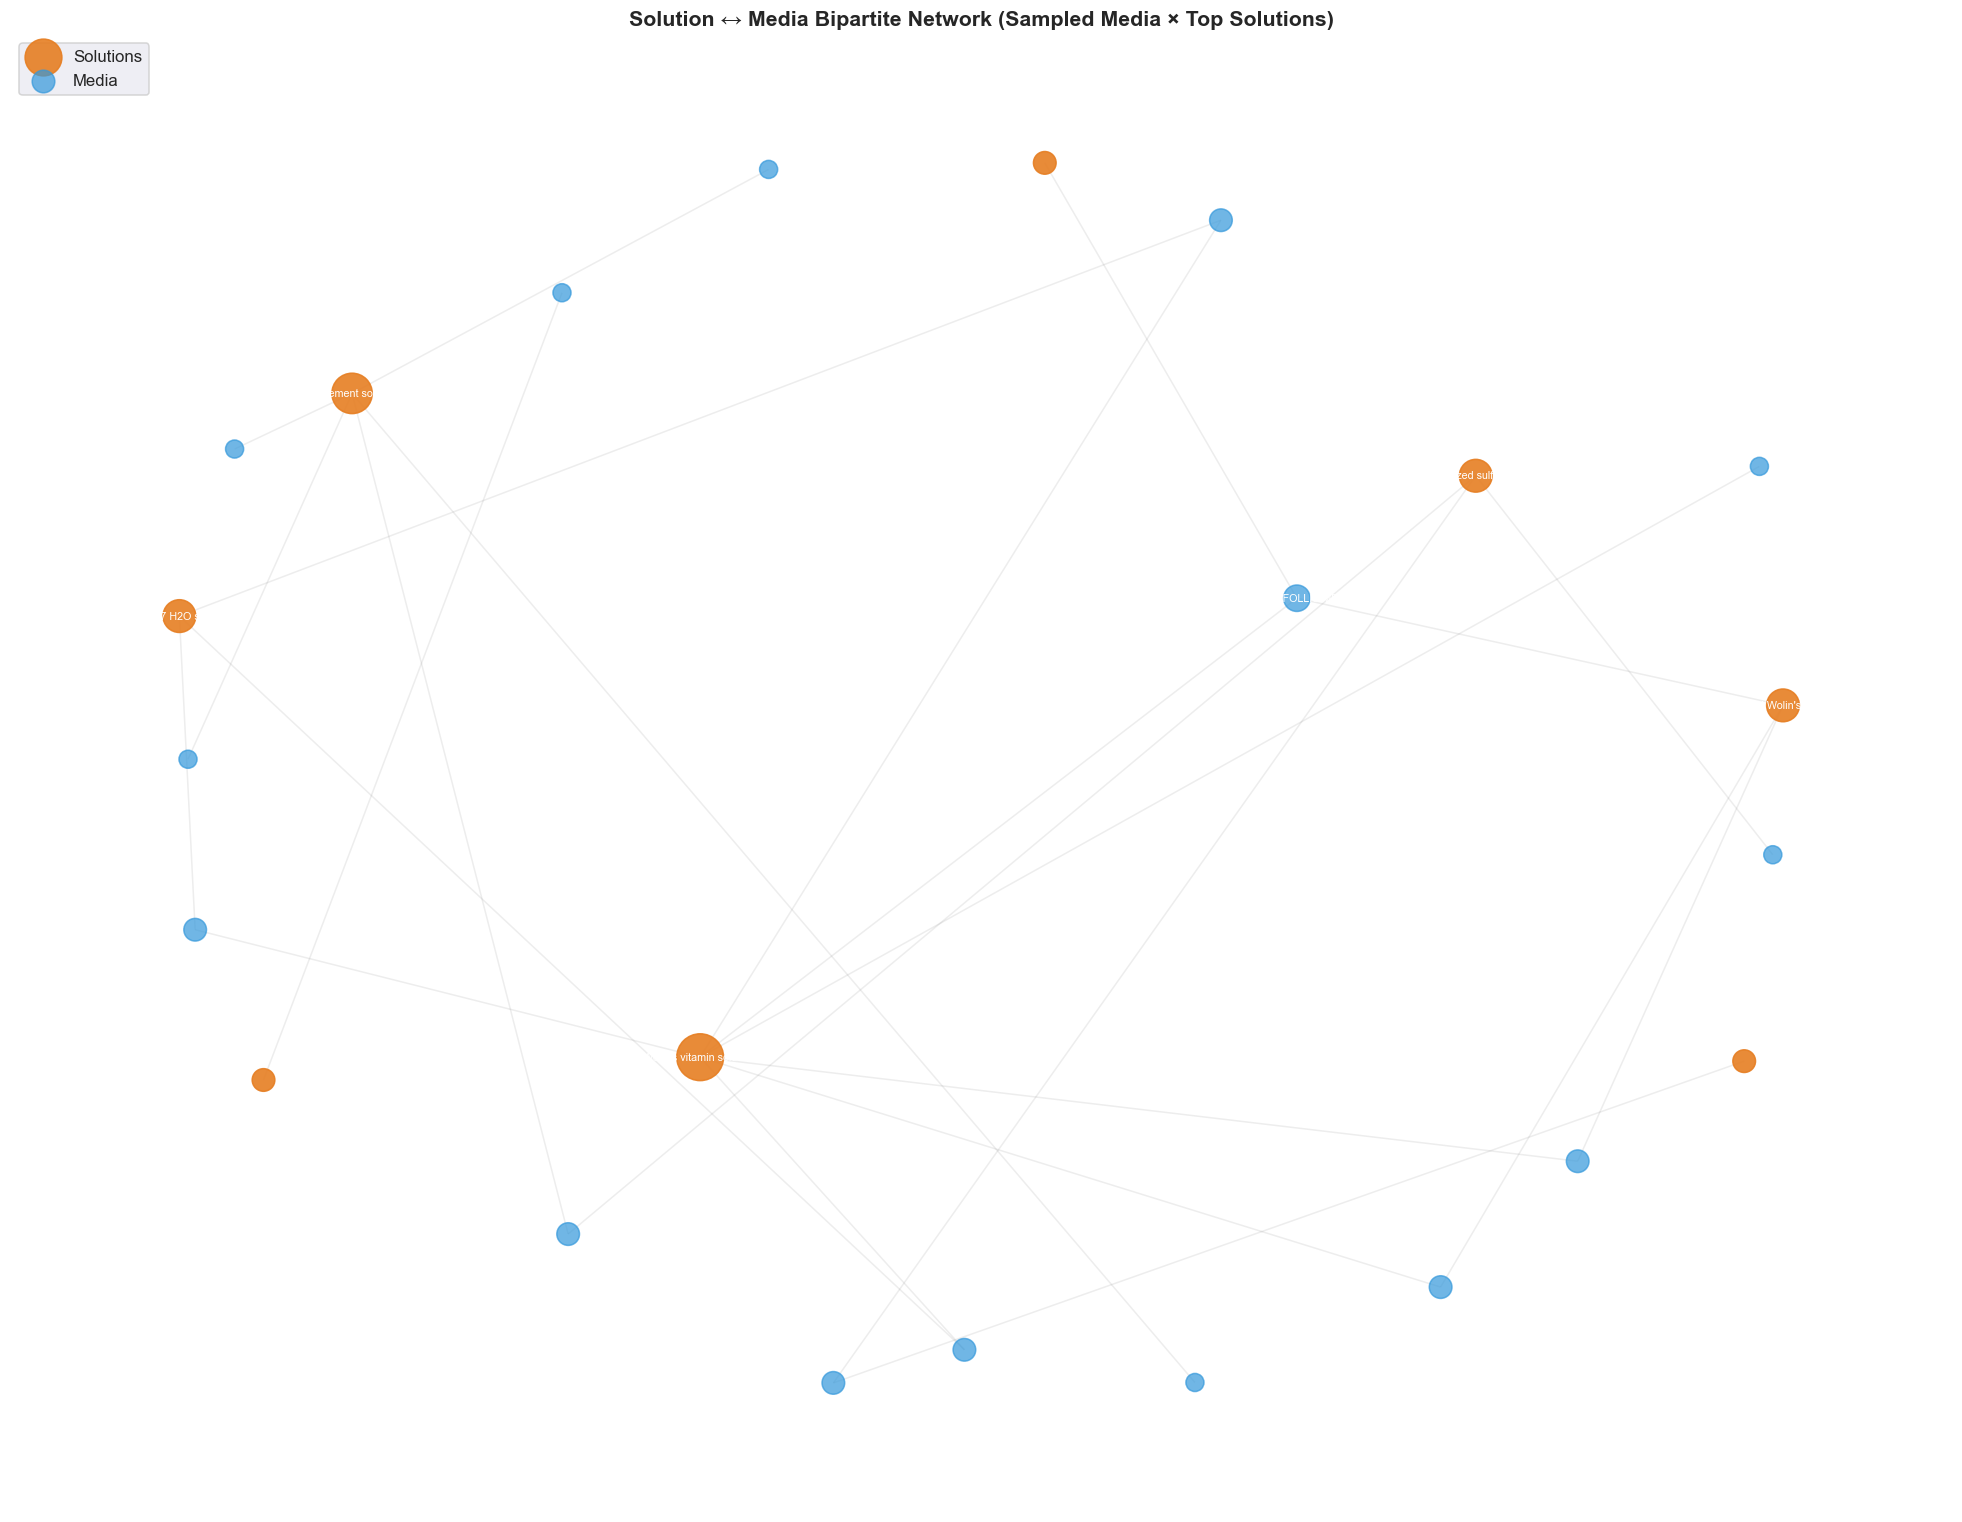

Network: 8 solutions, 15 media, 24 edges


In [10]:
# ── Bipartite network: Solutions ↔ Media ─────────────────────
if len(media_sol_df) > 0:
    # Filter to only our top solution IDs for cleaner viz
    top_sol_ids = set(top_df_clean["solution_id"].values)
    filtered_links = media_sol_df[media_sol_df["solution_id"].isin(top_sol_ids)]

    G = nx.Graph()

    # Add solution nodes
    for _, row in filtered_links.drop_duplicates("solution_id").iterrows():
        G.add_node(f"S:{row['solution_name']}", bipartite=0, node_type="solution")

    # Add media nodes
    for _, row in filtered_links.drop_duplicates("medium_id").iterrows():
        G.add_node(f"M:{row['medium_name']}", bipartite=1, node_type="medium")

    # Add edges
    for _, row in filtered_links.iterrows():
        G.add_edge(f"S:{row['solution_name']}", f"M:{row['medium_name']}")

    if len(G.nodes) > 0:
        fig, ax = plt.subplots(figsize=(18, 14))

        # Layout
        pos = nx.spring_layout(G, k=2.5, iterations=60, seed=42)

        # Separate node types
        sol_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "solution"]
        med_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "medium"]

        # Node sizes by degree
        sol_sizes = [G.degree(n) * 120 + 100 for n in sol_nodes]
        med_sizes = [G.degree(n) * 80 + 60 for n in med_nodes]

        # Draw
        nx.draw_networkx_edges(G, pos, alpha=0.15, edge_color="#888888", ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=sol_nodes, node_size=sol_sizes,
                               node_color="#e67e22", alpha=0.9, ax=ax, label="Solutions")
        nx.draw_networkx_nodes(G, pos, nodelist=med_nodes, node_size=med_sizes,
                               node_color="#3498db", alpha=0.7, ax=ax, label="Media")

        # Label only high-degree nodes
        labels = {}
        for n in G.nodes:
            if G.degree(n) >= 3:
                labels[n] = n.split(":", 1)[1][:25]
        nx.draw_networkx_labels(G, pos, labels, font_size=7, font_color="white", ax=ax)

        ax.set_title("Solution ↔ Media Bipartite Network (Sampled Media × Top Solutions)",
                      fontsize=14, fontweight="bold")
        ax.legend(fontsize=11, loc="upper left")
        ax.axis("off")
        plt.tight_layout()
        plt.show()

        print(f"Network: {len(sol_nodes)} solutions, {len(med_nodes)} media, {G.number_of_edges()} edges")
    else:
        print("No matching links between top solutions and sampled media.")
else:
    print("No media-solution link data available.")

## 10. Media → Strain Bipartite Network

Connect the top media (by strain count) to their strains, colored by taxonomic domain.

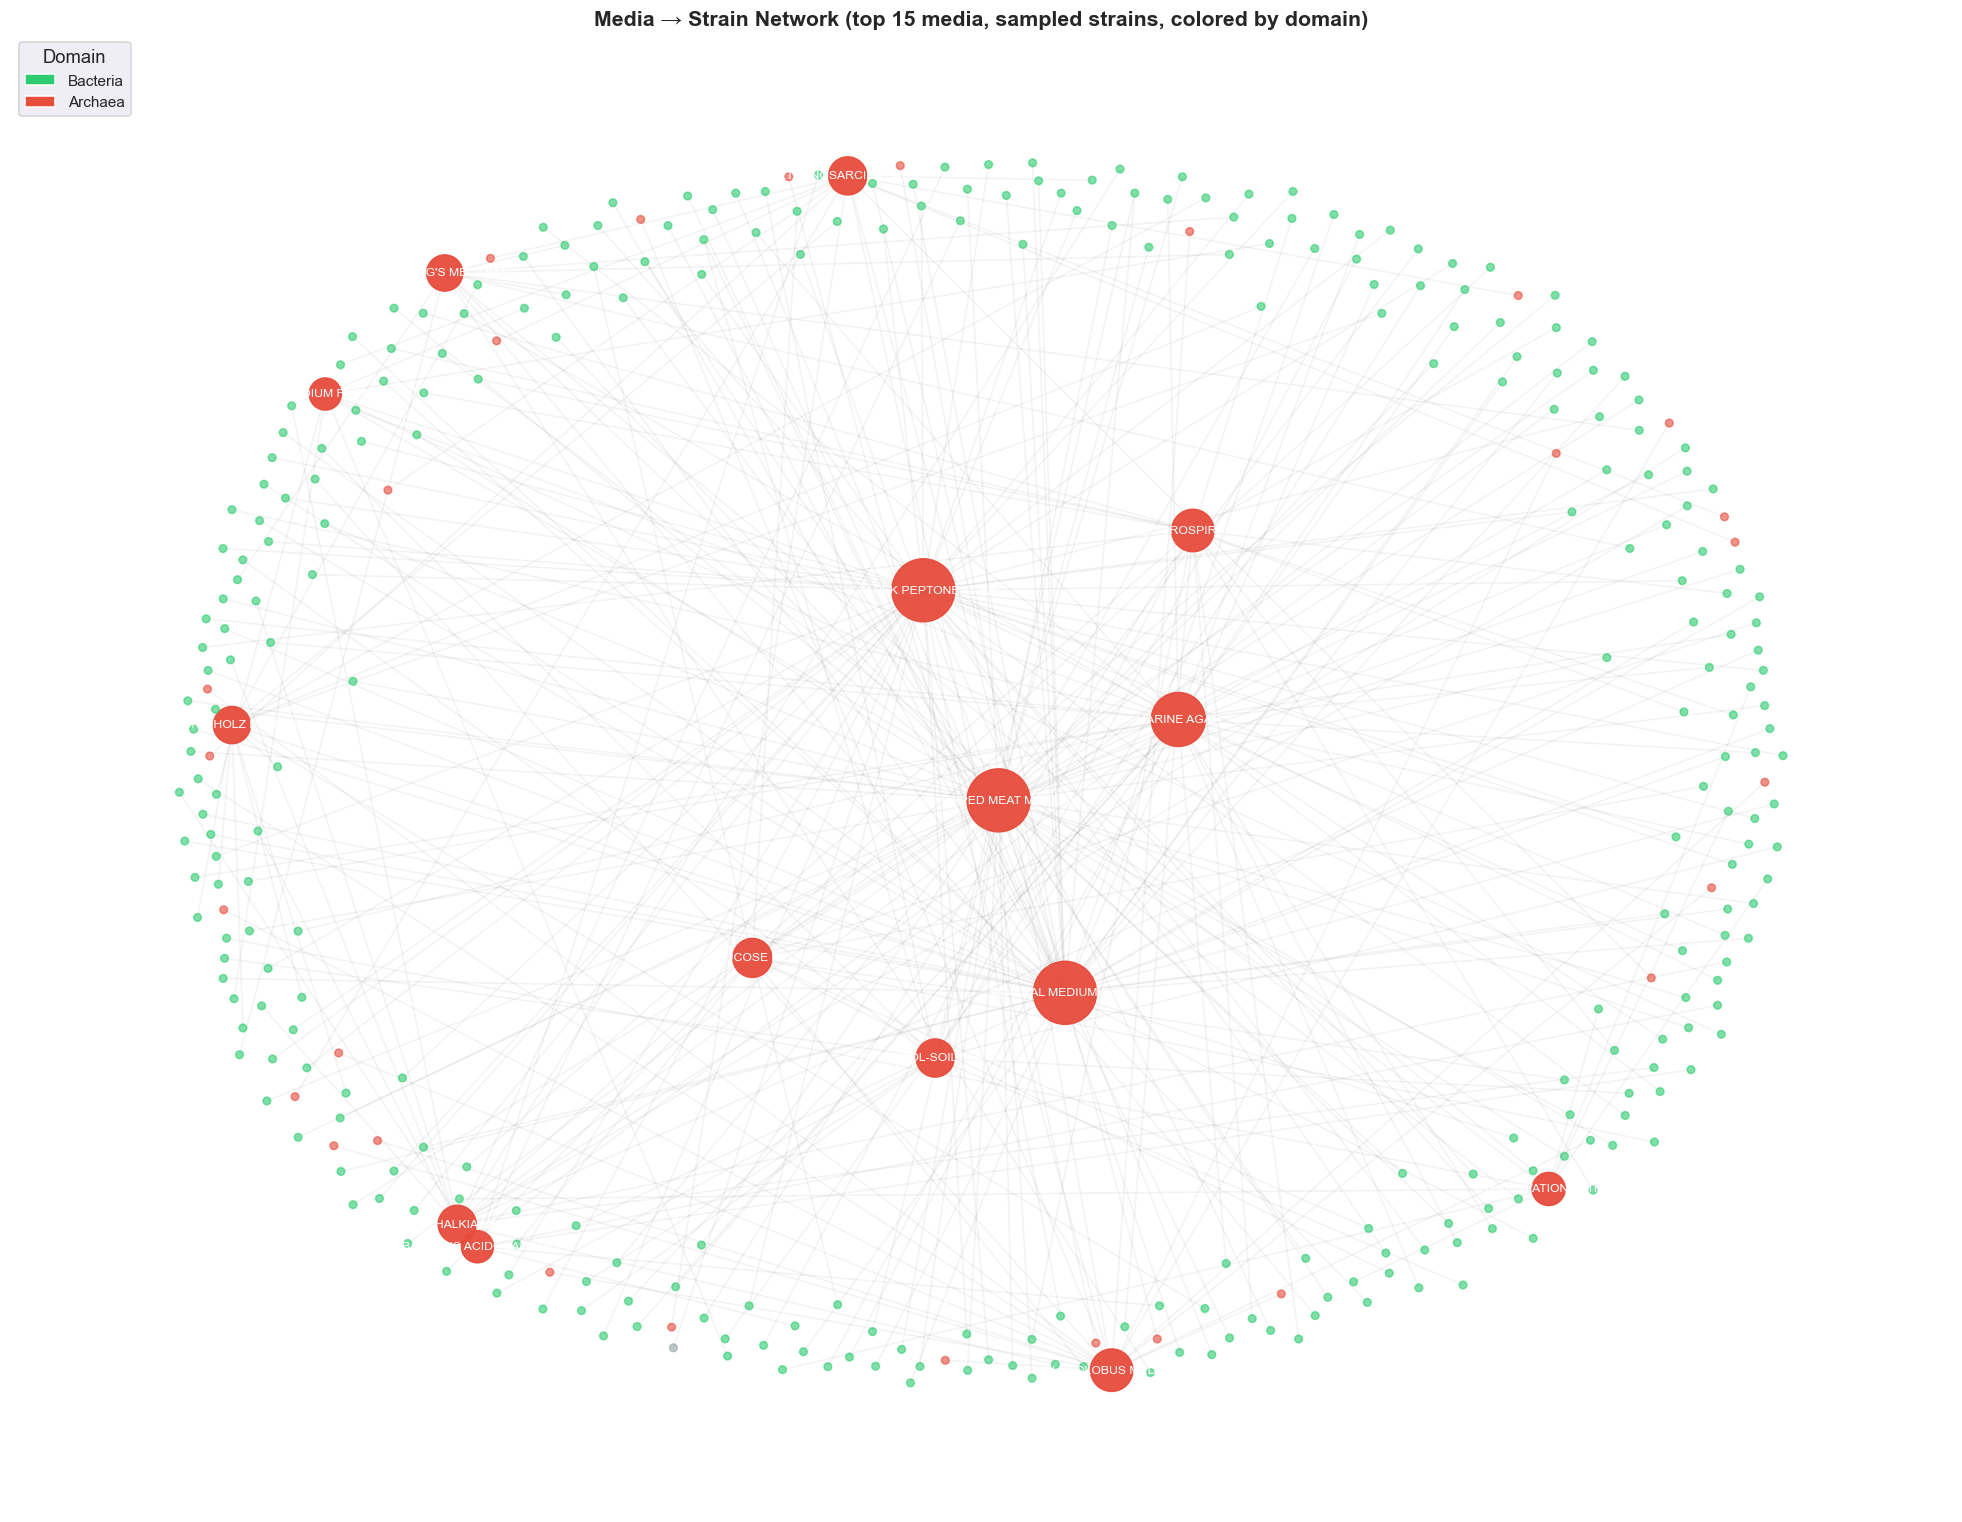

In [12]:
# ── Bipartite network: Media ↔ Strains ───────────────────────
if len(media_strain_df) > 0:
    # Limit to top 15 media by strain count, sample up to 50 strains per medium
    top_med_ids = strain_per_media.head(15)["medium_id"].values
    subset = media_strain_df[media_strain_df["medium_id"].isin(top_med_ids)].copy()

    # Sample strains per medium to keep graph readable
    sampled_parts = []
    for mid, grp in subset.groupby("medium_id"):
        sampled_parts.append(grp.sample(min(50, len(grp)), random_state=42))
    sampled = pd.concat(sampled_parts, ignore_index=True)

    G2 = nx.Graph()

    # Domain color map
    domain_colors = {"B": "#2ecc71", "A": "#e74c3c", "F": "#9b59b6",
                     "P": "#f39c12", "Y": "#e67e22", "AL": "#3498db",
                     "PH": "#1abc9c", "": "#95a5a6", "?": "#95a5a6"}

    for _, row in sampled.drop_duplicates("medium_id").iterrows():
        G2.add_node(f"M:{row['medium_name']}", node_type="medium")

    for _, row in sampled.iterrows():
        strain_label = f"S:{row['strain_id']}"
        G2.add_node(strain_label, node_type="strain", domain=row.get("domain", "?"))
        G2.add_edge(f"M:{row['medium_name']}", strain_label)

    fig, ax = plt.subplots(figsize=(18, 14))
    pos = nx.spring_layout(G2, k=1.8, iterations=50, seed=42)

    med_nodes2 = [n for n, d in G2.nodes(data=True) if d.get("node_type") == "medium"]
    strain_nodes = [n for n, d in G2.nodes(data=True) if d.get("node_type") == "strain"]
    strain_colors = [domain_colors.get(G2.nodes[n].get("domain", "?"), "#95a5a6") for n in strain_nodes]

    nx.draw_networkx_edges(G2, pos, alpha=0.08, edge_color="#666666", ax=ax)
    nx.draw_networkx_nodes(G2, pos, nodelist=med_nodes2,
                           node_size=[G2.degree(n) * 30 + 200 for n in med_nodes2],
                           node_color="#e74c3c", alpha=0.95, ax=ax, label="Media")
    nx.draw_networkx_nodes(G2, pos, nodelist=strain_nodes, node_size=25,
                           node_color=strain_colors, alpha=0.6, ax=ax)

    # Label media
    med_labels = {n: n.split(":", 1)[1][:20] for n in med_nodes2}
    nx.draw_networkx_labels(G2, pos, med_labels, font_size=8, font_color="white", ax=ax)

    # Domain legend
    from matplotlib.patches import Patch
    domain_legend = [Patch(facecolor=c, label={"B": "Bacteria", "A": "Archaea", "F": "Fungi",
                           "Y": "Yeast", "P": "Plant", "AL": "Algae", "PH": "Phage"}.get(d, d))
                     for d, c in domain_colors.items() if d in sampled["domain"].values]
    ax.legend(handles=domain_legend, fontsize=10, loc="upper left", title="Domain")

    ax.set_title("Media → Strain Network (top 15 media, sampled strains, colored by domain)",
                 fontsize=14, fontweight="bold")
    ax.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No strain data available.")

## 11. Heatmap of Ingredient Overlap Across Top Solutions

Binary presence/absence matrix → Jaccard similarity → clustered heatmap. This reveals which solutions share compositions.

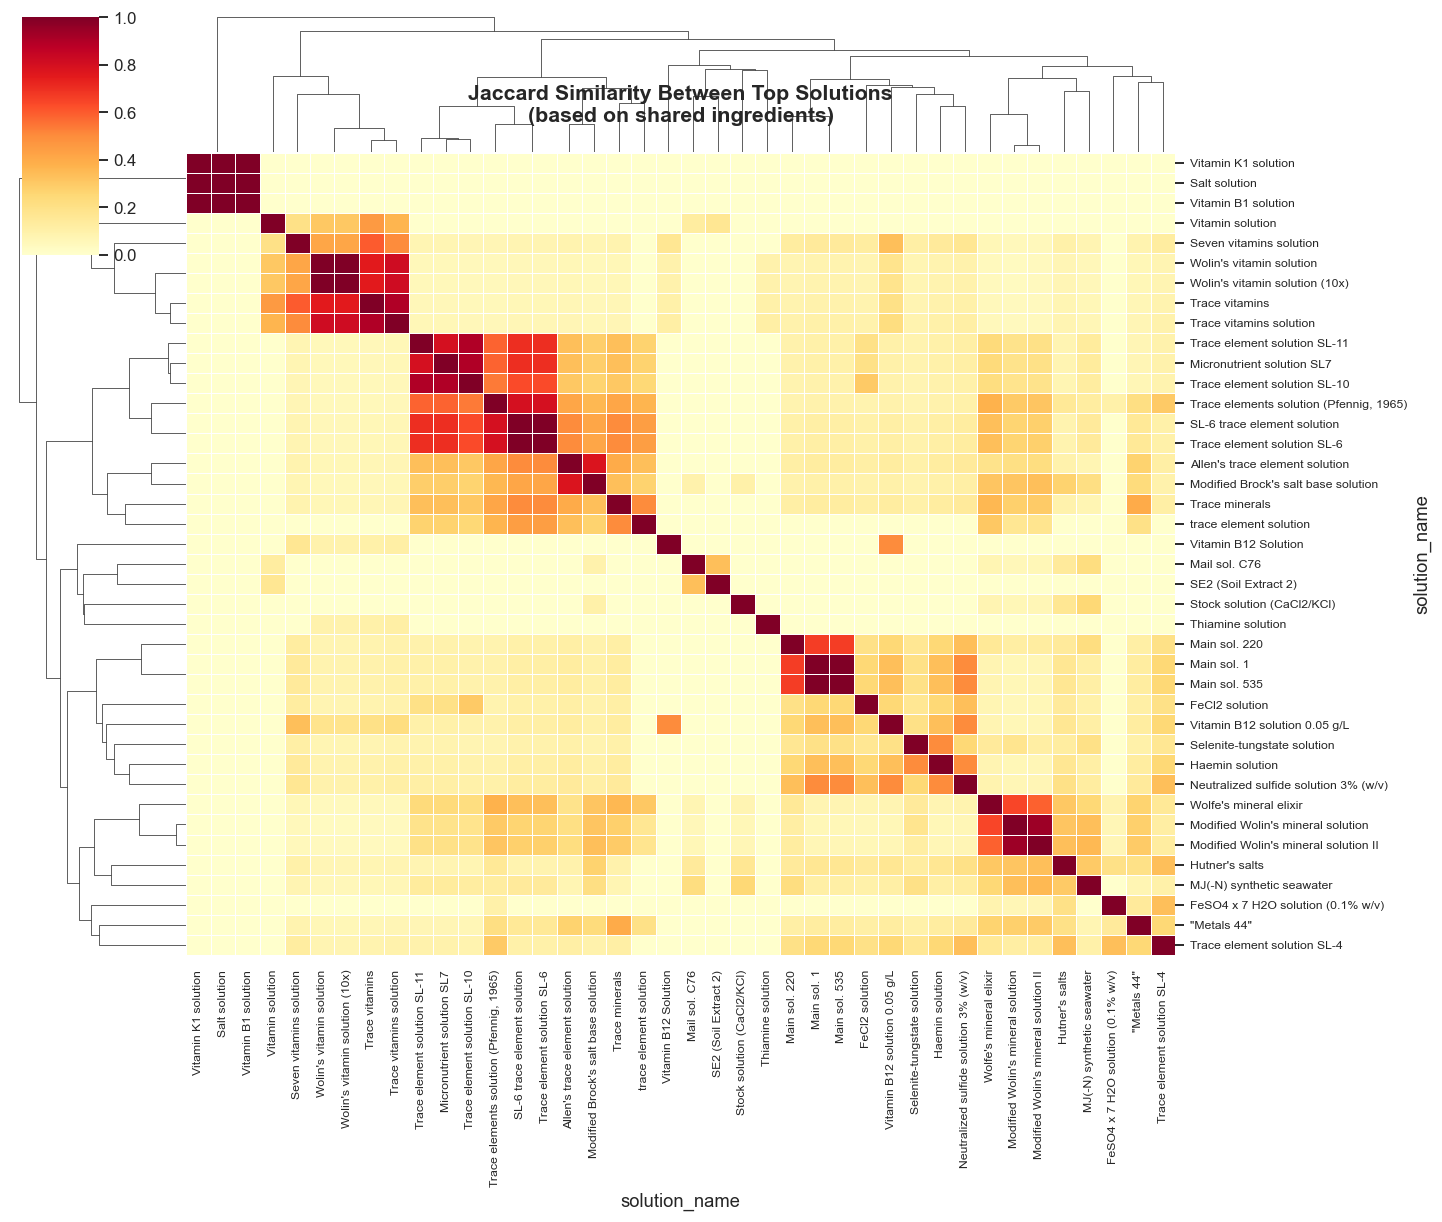

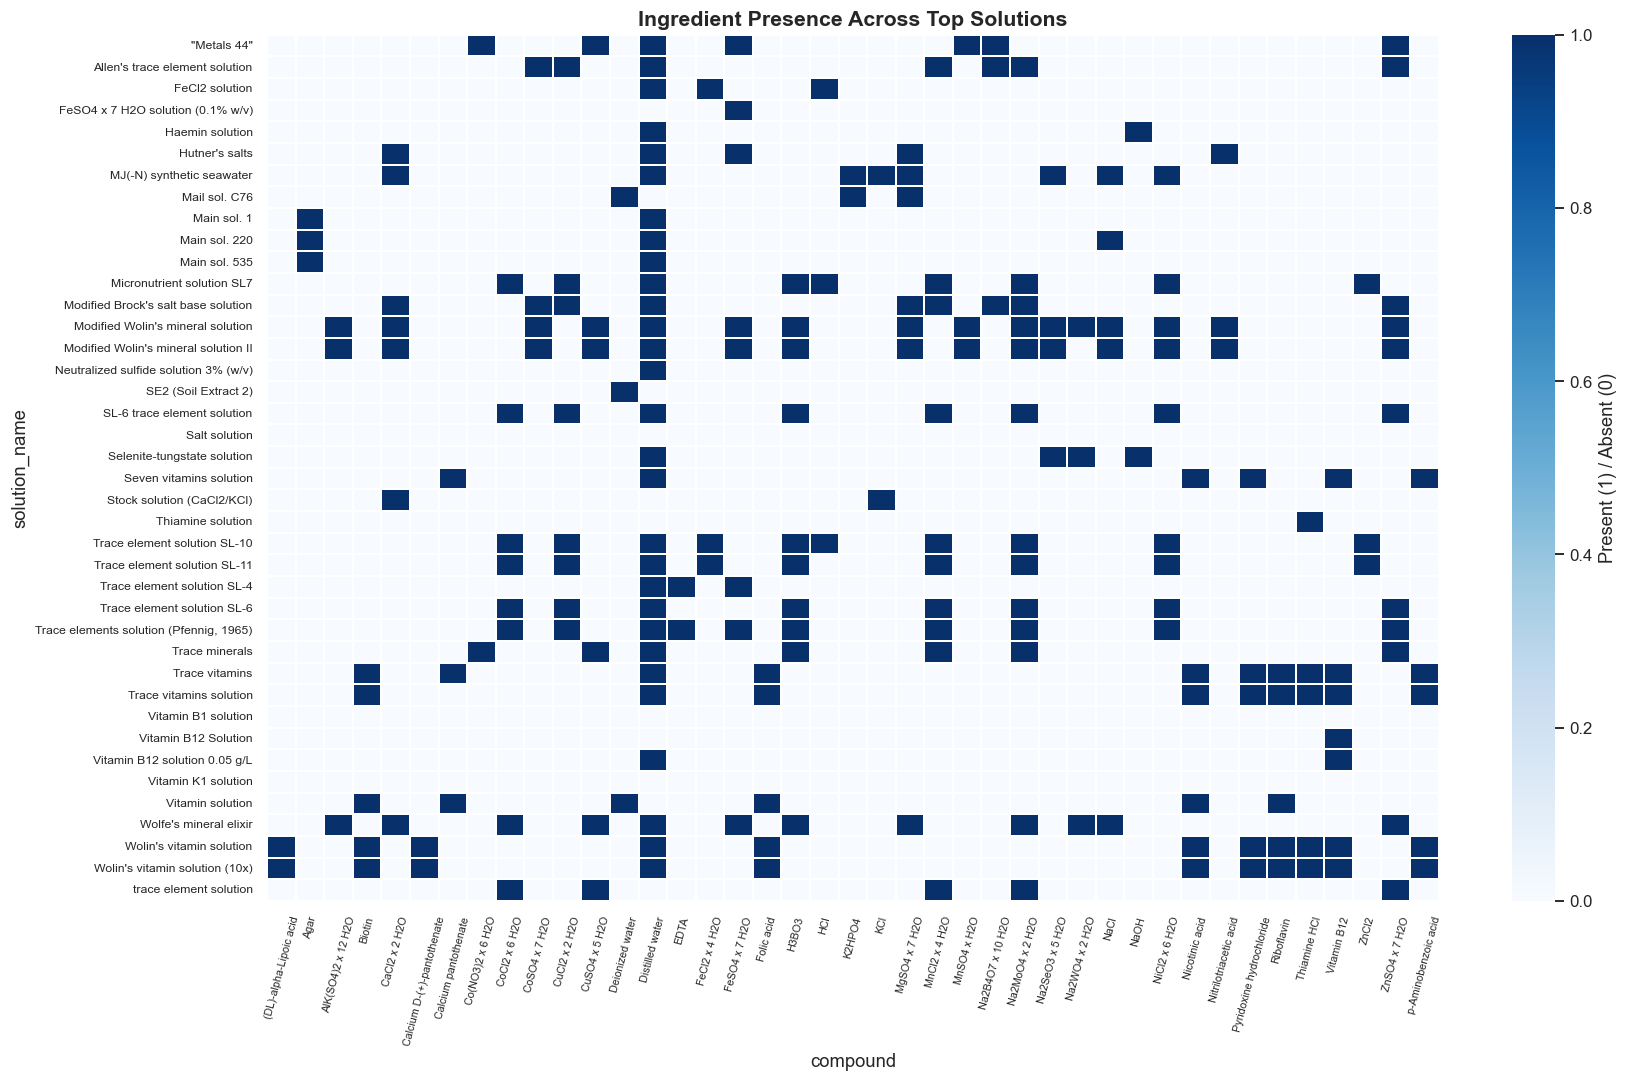

In [13]:
# ── Solution × Ingredient binary matrix ──────────────────────
if len(recipe_df) > 0:
    # Build presence/absence matrix
    presence = recipe_df.assign(present=1).pivot_table(
        index="solution_name", columns="compound", values="present", fill_value=0
    )

    # Filter to ingredients that appear in at least 2 solutions
    freq_cols = presence.columns[presence.sum() >= 2]
    presence_filtered = presence[freq_cols]

    if len(presence_filtered) >= 3 and len(freq_cols) >= 3:
        # Jaccard similarity between solutions
        from scipy.spatial.distance import pdist, squareform

        jaccard_dist = pdist(presence_filtered.values, metric="jaccard")
        jaccard_sim = 1 - squareform(jaccard_dist)
        jaccard_df = pd.DataFrame(jaccard_sim, index=presence_filtered.index,
                                   columns=presence_filtered.index)

        # Clustered heatmap
        g = sns.clustermap(
            jaccard_df,
            cmap="YlOrRd",
            figsize=(14, 12),
            linewidths=0.5,
            annot=False,
            xticklabels=True,
            yticklabels=True,
            dendrogram_ratio=(0.15, 0.15),
        )
        g.ax_heatmap.set_title("Jaccard Similarity Between Top Solutions\n(based on shared ingredients)",
                                fontsize=14, fontweight="bold", pad=20)
        g.ax_heatmap.tick_params(axis="both", labelsize=8)
        plt.show()

        # Also show the raw presence heatmap
        fig, ax = plt.subplots(figsize=(16, 10))
        sns.heatmap(
            presence_filtered,
            cmap="Blues",
            cbar_kws={"label": "Present (1) / Absent (0)"},
            linewidths=0.3,
            ax=ax,
            xticklabels=True,
            yticklabels=True,
        )
        ax.set_title("Ingredient Presence Across Top Solutions", fontsize=14, fontweight="bold")
        ax.tick_params(axis="x", rotation=75, labelsize=7)
        ax.tick_params(axis="y", labelsize=8)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Not enough data for heatmap: {len(presence_filtered)} solutions, {len(freq_cols)} shared ingredients")
else:
    print("No recipe data available.")

## 12. Taxonomic Distribution of Strains Across Top Media

Which domains (Bacteria, Archaea, Fungi, etc.) grow on which media? Are some media taxon-specific?

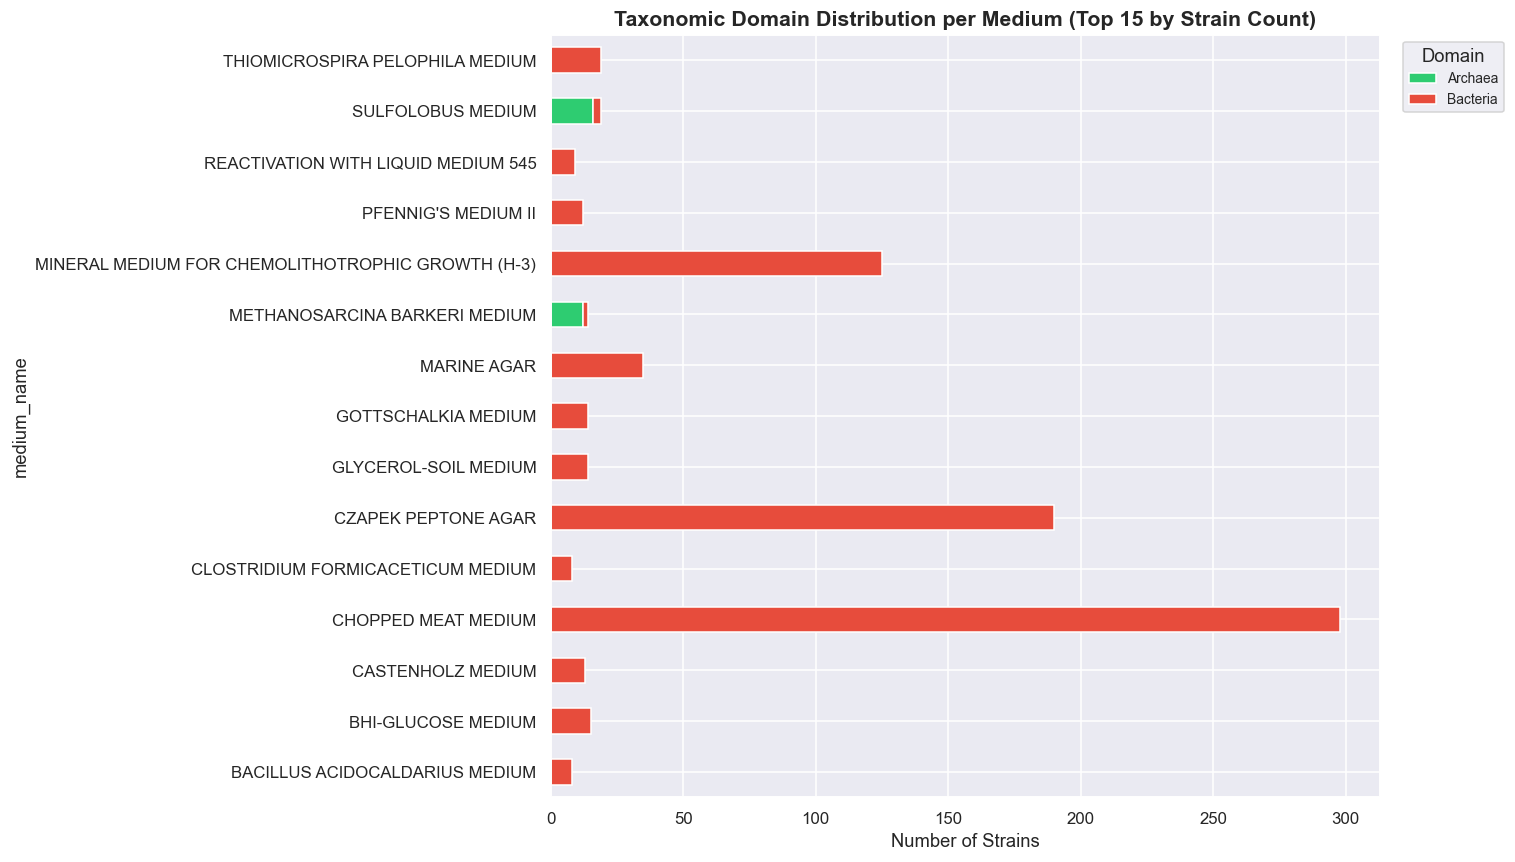

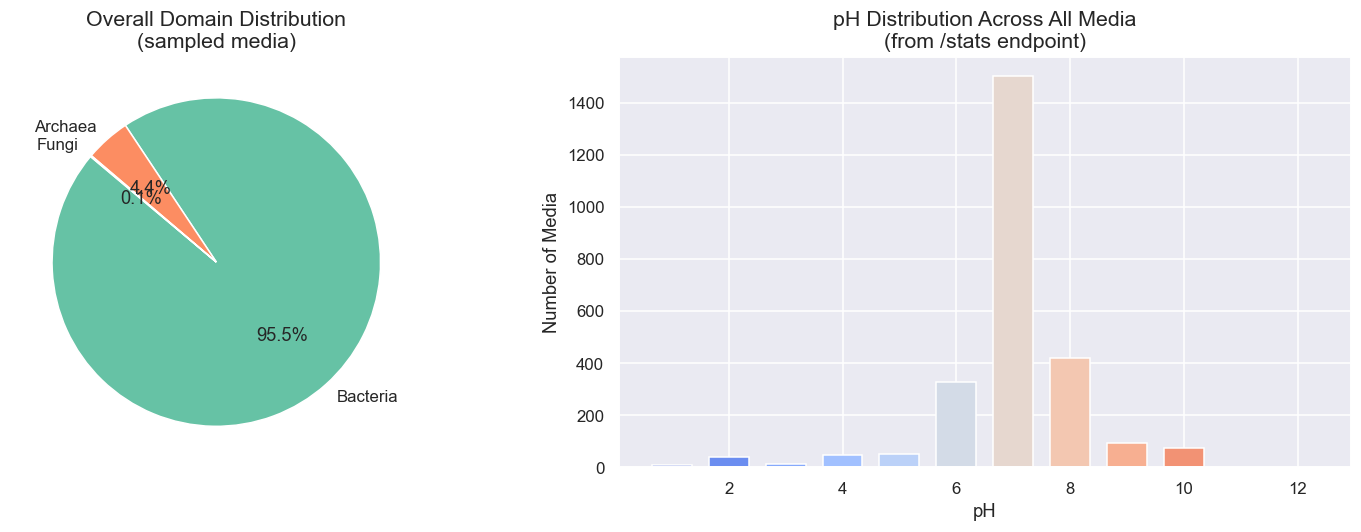

Top 20 most frequently occurring species across sampled media:
  Clostridioides difficile: 33 media associations
  Cupriavidus necator: 24 media associations
  Micromonospora sp.: 18 media associations
  Clostridium perfringens: 12 media associations
  Halobacillus halophilus: 11 media associations
  Bacteroides sp.: 10 media associations
  Thermoactinomyces vulgaris: 10 media associations
  Nocardiopsis sp.: 9 media associations
  Andreesenella formicoacetica: 8 media associations
  Ancylobacter polymorphus: 8 media associations
  Azospirillum largimobile: 8 media associations
  Variovorax paradoxus: 7 media associations
  Bacteroides fragilis: 6 media associations
  Gottschalkia acidurici: 6 media associations
  Paracoccus pantotrophus: 6 media associations
  Clostridium sporogenes: 5 media associations
  Clostridium sp.: 5 media associations
  Eubacterium callanderi: 5 media associations
  Phocaeicola vulgatus: 5 media associations
  Pseudomonas syringae: 5 media associations


In [14]:
# ── Domain distribution per medium ────────────────────────────
if len(media_strain_df) > 0:
    domain_names = {
        "B": "Bacteria", "A": "Archaea", "F": "Fungi", "Y": "Yeast",
        "P": "Plant", "AL": "Algae", "PH": "Phage", "BY": "By-product",
        "AN": "Animal", "": "Unknown",
    }
    media_strain_df["domain_label"] = media_strain_df["domain"].map(
        lambda d: domain_names.get(d, d)
    )

    # Top 15 media by strain count
    top15_ids = strain_per_media.head(15)["medium_id"].values
    top15_data = media_strain_df[media_strain_df["medium_id"].isin(top15_ids)]

    # Crosstab: media × domain
    ct = pd.crosstab(top15_data["medium_name"], top15_data["domain_label"])

    # Stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    ct.plot(kind="barh", stacked=True, ax=ax,
            color=["#2ecc71", "#e74c3c", "#9b59b6", "#f39c12", "#3498db",
                   "#1abc9c", "#e67e22", "#95a5a6"][:len(ct.columns)])
    ax.set_xlabel("Number of Strains")
    ax.set_title("Taxonomic Domain Distribution per Medium (Top 15 by Strain Count)",
                 fontsize=14, fontweight="bold")
    ax.legend(title="Domain", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)
    plt.tight_layout()
    plt.show()

    # ── Overall domain distribution ──────────────────────────
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Pie: overall domain breakdown
    domain_counts = media_strain_df["domain_label"].value_counts()
    axes[0].pie(domain_counts.values, labels=domain_counts.index, autopct="%1.1f%%",
                colors=sns.color_palette("Set2", len(domain_counts)), startangle=140)
    axes[0].set_title("Overall Domain Distribution\n(sampled media)")

    # Pie: pH distribution from stats
    ph_series = pd.Series(ph_dist).sort_index()
    axes[1].bar(ph_series.index, ph_series.values, color=sns.color_palette("coolwarm", len(ph_series)),
                width=0.7, edgecolor="white")
    axes[1].set_xlabel("pH")
    axes[1].set_ylabel("Number of Media")
    axes[1].set_title("pH Distribution Across All Media\n(from /stats endpoint)")

    plt.tight_layout()
    plt.show()

    # ── Top species ──────────────────────────────────────────
    species_counts = media_strain_df["species"].value_counts().head(20)
    print("Top 20 most frequently occurring species across sampled media:")
    for sp, ct_val in species_counts.items():
        print(f"  {sp}: {ct_val} media associations")
else:
    print("No strain data.")

## 13. Interactive Sankey Diagram: Solutions → Media → Taxa

Flows from top solutions through media to taxonomic domains. Requires plotly.

In [15]:
# ── Sankey: Solutions → Media → Taxa ─────────────────────────
if HAS_PLOTLY and len(media_sol_df) > 0 and len(media_strain_df) > 0:
    # Build flow: top solutions → their media → domain counts
    top_sol_ids_set = set(top_df_clean.head(15)["solution_id"].values)

    # Solution → Media links (filtered to top solutions)
    sol_med = media_sol_df[media_sol_df["solution_id"].isin(top_sol_ids_set)].copy()

    # Media → Domain aggregation
    med_domain = (
        media_strain_df.groupby(["medium_id", "medium_name", "domain_label"])["strain_id"]
        .nunique()
        .reset_index()
        .rename(columns={"strain_id": "strain_count"})
    )

    # Limit media to those that appear in sol_med
    relevant_media = set(sol_med["medium_id"].values)
    med_domain = med_domain[med_domain["medium_id"].isin(relevant_media)]

    # Build Sankey node list
    sol_names = sorted(sol_med["solution_name"].unique())
    med_names = sorted(sol_med["medium_name"].unique())
    domain_labels = sorted(med_domain["domain_label"].unique())

    all_labels = list(sol_names) + list(med_names) + list(domain_labels)
    label_idx = {label: i for i, label in enumerate(all_labels)}

    sources, targets, values = [], [], []

    # Solution → Media edges
    for _, row in sol_med.groupby(["solution_name", "medium_name"]).size().reset_index(name="count").iterrows():
        sources.append(label_idx[row["solution_name"]])
        targets.append(label_idx[row["medium_name"]])
        values.append(row["count"])

    # Media → Domain edges
    for _, row in med_domain.iterrows():
        if row["medium_name"] in label_idx and row["domain_label"] in label_idx:
            sources.append(label_idx[row["medium_name"]])
            targets.append(label_idx[row["domain_label"]])
            values.append(row["strain_count"])

    # Colors
    node_colors = (
        ["#e67e22"] * len(sol_names)  # solutions
        + ["#3498db"] * len(med_names)  # media
        + ["#2ecc71"] * len(domain_labels)  # domains
    )

    fig = go.Figure(go.Sankey(
        node=dict(
            pad=15, thickness=20, line=dict(color="black", width=0.5),
            label=all_labels, color=node_colors,
        ),
        link=dict(source=sources, target=targets, value=values,
                  color="rgba(200, 200, 200, 0.3)"),
    ))
    fig.update_layout(
        title_text="Solutions → Media → Taxonomic Domains (Sampled Data)",
        font_size=11, width=1100, height=700,
    )
    fig.show()
else:
    if not HAS_PLOTLY:
        print("Install plotly for the Sankey diagram: pip install plotly")
    else:
        print("Insufficient link data for Sankey diagram.")

## 14. Summary Statistics and Coverage Analysis

Key findings and recommendations for prediction model training data selection.

In [16]:
# ── Summary ──────────────────────────────────────────────────
total_db_solutions = stats["solutions"]
total_db_media = stats["media"]["defined"] + stats["media"]["complex"]
total_db_ingredients = stats["ingredients"]

print("=" * 65)
print("          MEDIADIVE TOP SOLUTIONS ANALYSIS — SUMMARY")
print("=" * 65)

print(f"\n📊 DATABASE SCOPE")
print(f"  Total solutions:      {total_db_solutions:>6,}")
print(f"  Total media:          {total_db_media:>6,}")
print(f"  Total ingredients:    {total_db_ingredients:>6,}")
print(f"  Total strains:        {total_strains:>6,}")
print(f"  Total growth obs:     {total_growth:>6,}")

print(f"\n🔍 THIS ANALYSIS")
print(f"  Top solutions parsed:  {len(top_df)}")
print(f"  Solutions matched:     {len(top_df_clean)}")
print(f"  Solution details fetched: {len(solution_details)}")
print(f"  Unique ingredients in top sols: {recipe_df['compound'].nunique() if len(recipe_df) else 0}")
print(f"  Media sampled:         {len(media_details)}")
print(f"  Unique strains seen:   {media_strain_df['strain_id'].nunique() if len(media_strain_df) else 0}")

# Coverage percentages
if len(media_strain_df) > 0:
    strain_coverage = media_strain_df['strain_id'].nunique() / total_strains * 100
    print(f"\n📈 COVERAGE (from {len(media_details)} sampled media)")
    print(f"  Strain coverage:     {strain_coverage:.1f}% of total strains")
    print(f"  Media coverage:      {len(media_details) / total_db_media * 100:.1f}% of total media")

# Core ingredients
if len(recipe_df) > 0:
    print(f"\n🧪 CORE INGREDIENTS (in ≥25% of top solutions)")
    n_sols = top_df_clean["solution_id"].nunique()
    comp_freq = recipe_df.groupby("compound")["solution_id"].nunique().sort_values(ascending=False)
    for name, count in comp_freq.items():
        pct = count / n_sols * 100
        if pct >= 25:
            print(f"  {name}: {count}/{n_sols} solutions ({pct:.0f}%)")

# Solution category breakdown
if "category" in top_df_clean.columns:
    print(f"\n🏷️  SOLUTION CATEGORIES (top 50)")
    for cat, cnt in top_df_clean["category"].value_counts().items():
        total_media_in_cat = top_df_clean[top_df_clean["category"] == cat]["media_count"].sum()
        print(f"  {cat}: {cnt} solutions, {total_media_in_cat:,} total media associations")

# Top species
if len(media_strain_df) > 0:
    print(f"\n🦠 MOST COMMON SPECIES (across sampled media)")
    for sp, cnt in media_strain_df["species"].value_counts().head(10).items():
        print(f"  {sp}: {cnt} media associations")

print(f"\n💡 RECOMMENDATIONS FOR MODEL TRAINING")
print(f"  1. Start ingest with top ~200 media (highest strain counts)")
print(f"     → These cover the most taxonomic diversity")
print(f"  2. The top 50 solutions from TOPMEDIA.md touch {top_df_clean['media_count'].sum():,}")
print(f"     media associations — a strong initial feature space")
print(f"  3. Trace element + vitamin solutions dominate → model should")
print(f"     learn concentration-critical vs binary-presence features")
print(f"  4. pH is concentrated around 7 but ranges 1-12 → include as feature")
print(f"  5. ~73% of strains are Bacteria → consider domain-stratified splits")
print("=" * 65)

          MEDIADIVE TOP SOLUTIONS ANALYSIS — SUMMARY

📊 DATABASE SCOPE
  Total solutions:       5,867
  Total media:           3,327
  Total ingredients:     1,237
  Total strains:        47,940
  Total growth obs:     72,931

🔍 THIS ANALYSIS
  Top solutions parsed:  50
  Solutions matched:     50
  Solution details fetched: 42
  Unique ingredients in top sols: 78
  Media sampled:         50
  Unique strains seen:   873

📈 COVERAGE (from 50 sampled media)
  Strain coverage:     1.8% of total strains
  Media coverage:      1.5% of total media

🧪 CORE INGREDIENTS (in ≥25% of top solutions)
  Distilled water: 29/42 solutions (69%)
  Na2MoO4 x 2 H2O: 13/42 solutions (31%)
  ZnSO4 x 7 H2O: 11/42 solutions (26%)

🏷️  SOLUTION CATEGORIES (top 50)
  Trace Element: 20 solutions, 1,227 total media associations
  Vitamin: 12 solutions, 778 total media associations
  Other: 11 solutions, 240 total media associations
  Main Solution: 4 solutions, 73 total media associations
  Biological Extract: 2 

---

## 15. Top 200 Media — Expanded Strain & Solution Mapping

Scale up from 50 sampled media to all 200 from the first page. For each medium, fetch strains and solution composition. Reuses the in-memory API cache, so the 50 already fetched are free.

**API budget**: ~300 new calls (150 medium details + 150 medium-strains) at 0.3 s ≈ 90 s.

In [17]:
# ── Fetch strains + medium detail for all 200 media ──────────
# media_list already has 200 entries from the first /media page.
# api_get caches, so the 50 we already fetched are instant.

all_media_ids = [m["id"] for m in media_list]

t200_details = {}       # medium_id → medium info dict
t200_sol_links = []     # (medium_id, medium_name, solution_id, solution_name)
t200_strain_rows = []   # (medium_id, medium_name, strain_id, species, growth, domain)
t200_solution_ids = set()  # all unique solution IDs seen

failed = []
for idx, mid in enumerate(all_media_ids):
    if idx % 50 == 0:
        print(f"  Fetching media {idx+1}–{min(idx+50, len(all_media_ids))} of {len(all_media_ids)}…")
    try:
        # Medium detail (solutions + recipes)
        resp = api_get(f"/medium/{mid}")
        detail = resp["data"]
        medium_info = detail["medium"]
        t200_details[mid] = medium_info

        for sol in detail.get("solutions", []):
            t200_sol_links.append({
                "medium_id": mid,
                "medium_name": medium_info["name"],
                "solution_id": sol["id"],
                "solution_name": sol["name"],
            })
            t200_solution_ids.add(sol["id"])

        # Strain associations
        strain_resp = api_get(f"/medium-strains/{mid}")
        strains = strain_resp.get("data", [])
        for s in strains:
            t200_strain_rows.append({
                "medium_id": mid,
                "medium_name": medium_info["name"],
                "strain_id": s.get("id"),
                "species": s.get("species"),
                "growth": s.get("growth"),
                "domain": s.get("domain", "?"),
            })
    except Exception as e:
        failed.append((mid, str(e)))

t200_sol_df = pd.DataFrame(t200_sol_links)
t200_strain_df = pd.DataFrame(t200_strain_rows)
t200_info_df = pd.DataFrame(t200_details.values())

print(f"\n✓ Fetched {len(t200_details)} media details  ({len(failed)} failures)")
print(f"  Media ↔ Solution links: {len(t200_sol_df):,}")
print(f"  Unique solutions seen:  {len(t200_solution_ids):,}")
print(f"  Media ↔ Strain links:   {len(t200_strain_df):,}")
print(f"  Unique strains:         {t200_strain_df['strain_id'].nunique():,}")
if failed:
    print(f"  Failed IDs: {[f[0] for f in failed[:10]]}")

  Fetching media 1–50 of 200…
  Fetching media 51–100 of 200…
  Fetching media 101–150 of 200…
  Fetching media 151–200 of 200…

✓ Fetched 200 media details  (7 failures)
  Media ↔ Solution links: 546
  Unique solutions seen:  354
  Media ↔ Strain links:   21,557
  Unique strains:         18,938
  Failed IDs: ['29a', 32, 43, 44, 46, '78d', 102]


### 15a. Top 200 Media Ranked by Strain Count

Media with ≥1 strain: 193
Top 10:
medium_id                         medium_name  strain_count complex_medium  min_pH  max_pH
       65             GYM STREPTOMYCES MEDIUM          3998            yes     7.2     7.2
       92 TRYPTICASE SOY YEAST EXTRACT MEDIUM          3162            yes     7.0     7.2
        9                           VY/2 AGAR          2851            yes     7.2     7.2
        1                       NUTRIENT AGAR          2451            yes     7.0     7.0
       84          ROLLED OATS MINERAL MEDIUM          1667            yes     7.2     7.2
       90           MALT EXTRACT PEPTONE AGAR          1064            yes     5.6     5.6
      129                POTATO DEXTROSE AGAR           899            yes     5.6     5.6
      104               PYG MEDIUM (modified)           509            yes     7.2     7.2
       11                          MRS MEDIUM           508            yes     6.2     6.5
      186    UNIVERSAL MEDIUM FOR YEASTS (YM)           

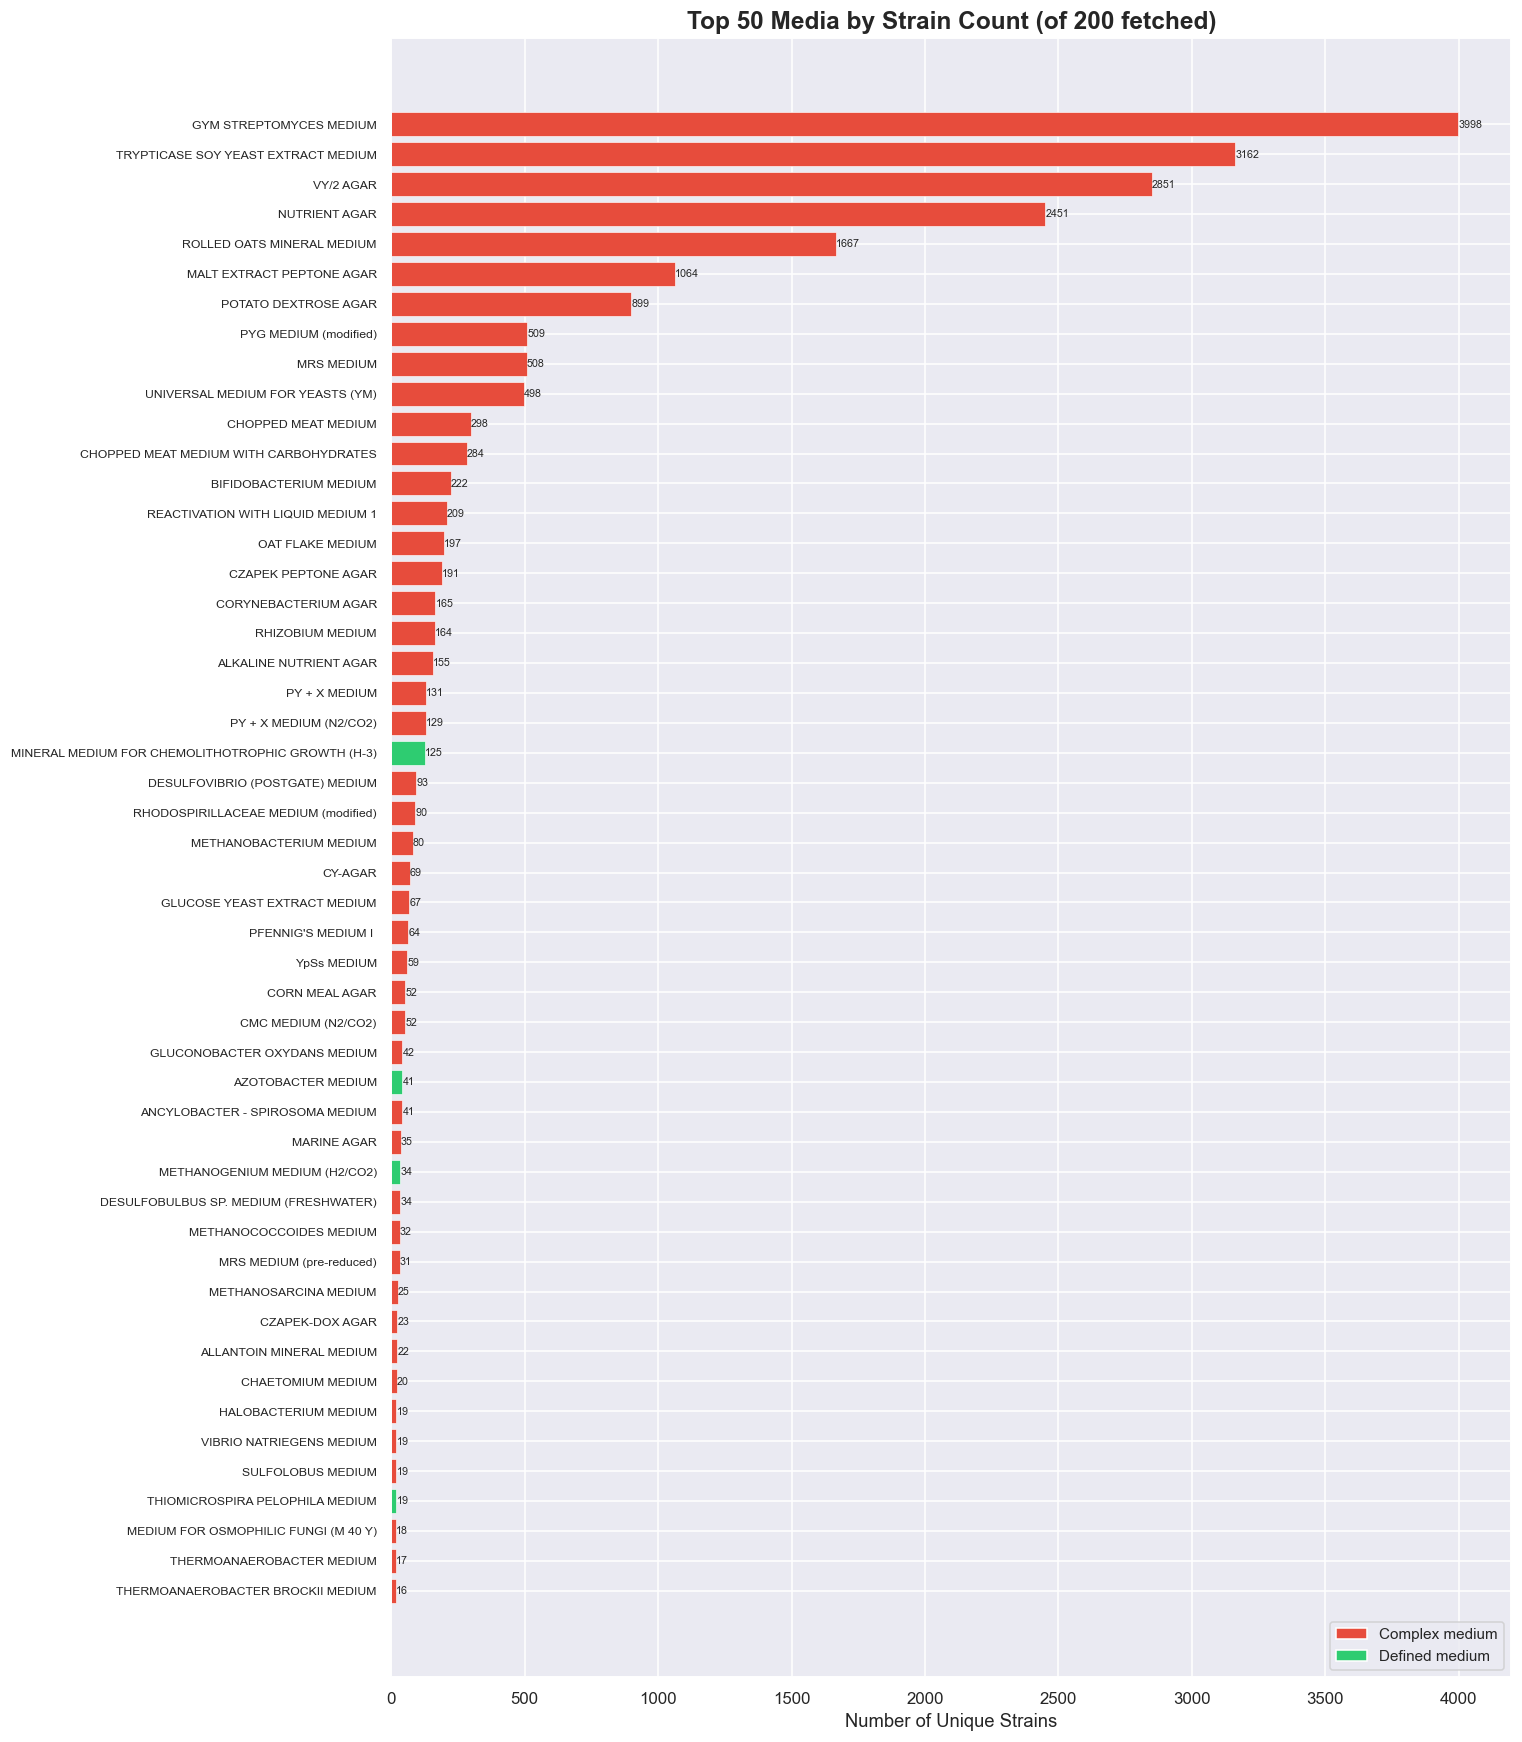

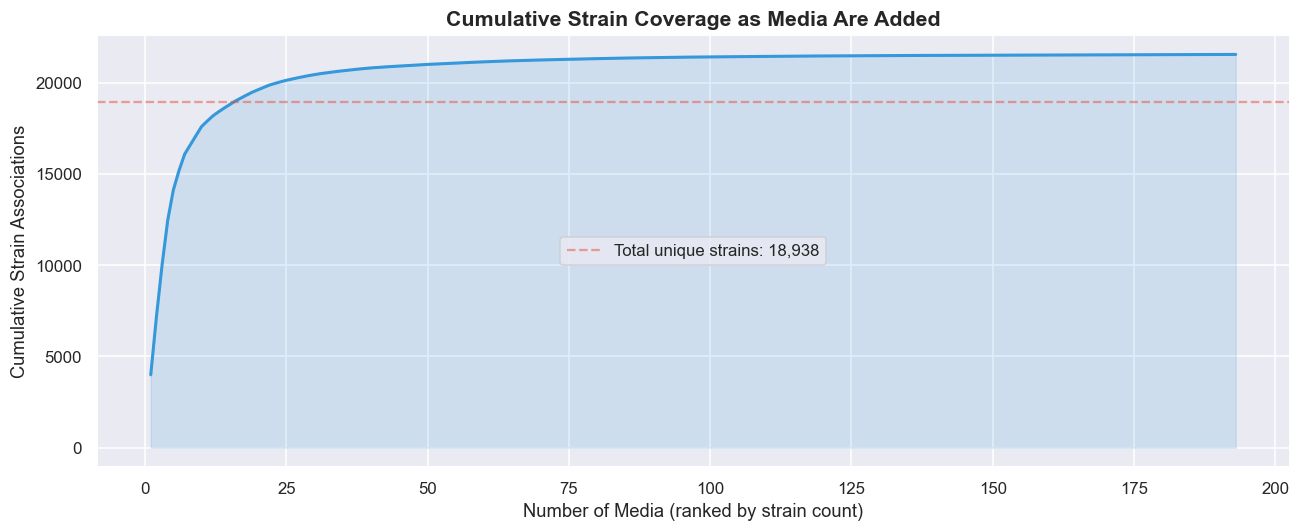


Top 20 media cover 19,623 strain-associations
Top 50 media cover 21,010 strain-associations
All 200 media cover 21,557 strain-associations


In [18]:
# ── Rank all 200 media by strain count ────────────────────────
t200_strain_per_media = (
    t200_strain_df.groupby(["medium_id", "medium_name"])["strain_id"]
    .nunique()
    .reset_index()
    .rename(columns={"strain_id": "strain_count"})
    .sort_values("strain_count", ascending=False)
    .reset_index(drop=True)
)

# Merge with medium info (pH, complex_medium)
t200_strain_per_media = t200_strain_per_media.merge(
    t200_info_df[["id", "complex_medium", "min_pH", "max_pH"]].rename(columns={"id": "medium_id"}),
    on="medium_id",
    how="left",
)

print(f"Media with ≥1 strain: {(t200_strain_per_media['strain_count'] > 0).sum()}")
print(f"Top 10:")
print(t200_strain_per_media.head(10).to_string(index=False))

# ── Bar chart: Top 50 media by strain count ──────────────────
top50_media = t200_strain_per_media.head(50)

fig, ax = plt.subplots(figsize=(14, 16))
is_complex = top50_media["complex_medium"].apply(
    lambda x: x in (1, "yes", "1", True)
)
bar_colors = ["#e74c3c" if c else "#2ecc71" for c in is_complex]

bars = ax.barh(range(len(top50_media)), top50_media["strain_count"].values,
               color=bar_colors, edgecolor="white", linewidth=0.4)
ax.set_yticks(range(len(top50_media)))
ax.set_yticklabels(top50_media["medium_name"].values, fontsize=8)
ax.invert_yaxis()
ax.set_xlabel("Number of Unique Strains")
ax.set_title("Top 50 Media by Strain Count (of 200 fetched)", fontsize=16, fontweight="bold")

for bar, count in zip(bars, top50_media["strain_count"].values):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            str(count), va="center", fontsize=7)

from matplotlib.patches import Patch
ax.legend(handles=[Patch(facecolor="#e74c3c", label="Complex medium"),
                   Patch(facecolor="#2ecc71", label="Defined medium")],
          loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()

# ── Cumulative strain coverage ───────────────────────────────
cumulative = t200_strain_per_media["strain_count"].cumsum()
total_seen = t200_strain_df["strain_id"].nunique()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(range(1, len(cumulative) + 1), cumulative.values, color="#3498db", linewidth=2)
ax.axhline(total_seen, color="#e74c3c", linestyle="--", alpha=0.5, label=f"Total unique strains: {total_seen:,}")
ax.fill_between(range(1, len(cumulative) + 1), cumulative.values, alpha=0.15, color="#3498db")
ax.set_xlabel("Number of Media (ranked by strain count)")
ax.set_ylabel("Cumulative Strain Associations")
ax.set_title("Cumulative Strain Coverage as Media Are Added", fontsize=14, fontweight="bold")
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"\nTop 20 media cover {cumulative.iloc[19]:,} strain-associations")
print(f"Top 50 media cover {cumulative.iloc[49]:,} strain-associations")
print(f"All 200 media cover {cumulative.iloc[-1]:,} strain-associations")

### 15b. Domain Breakdown & pH Distribution (Top 200 Media)

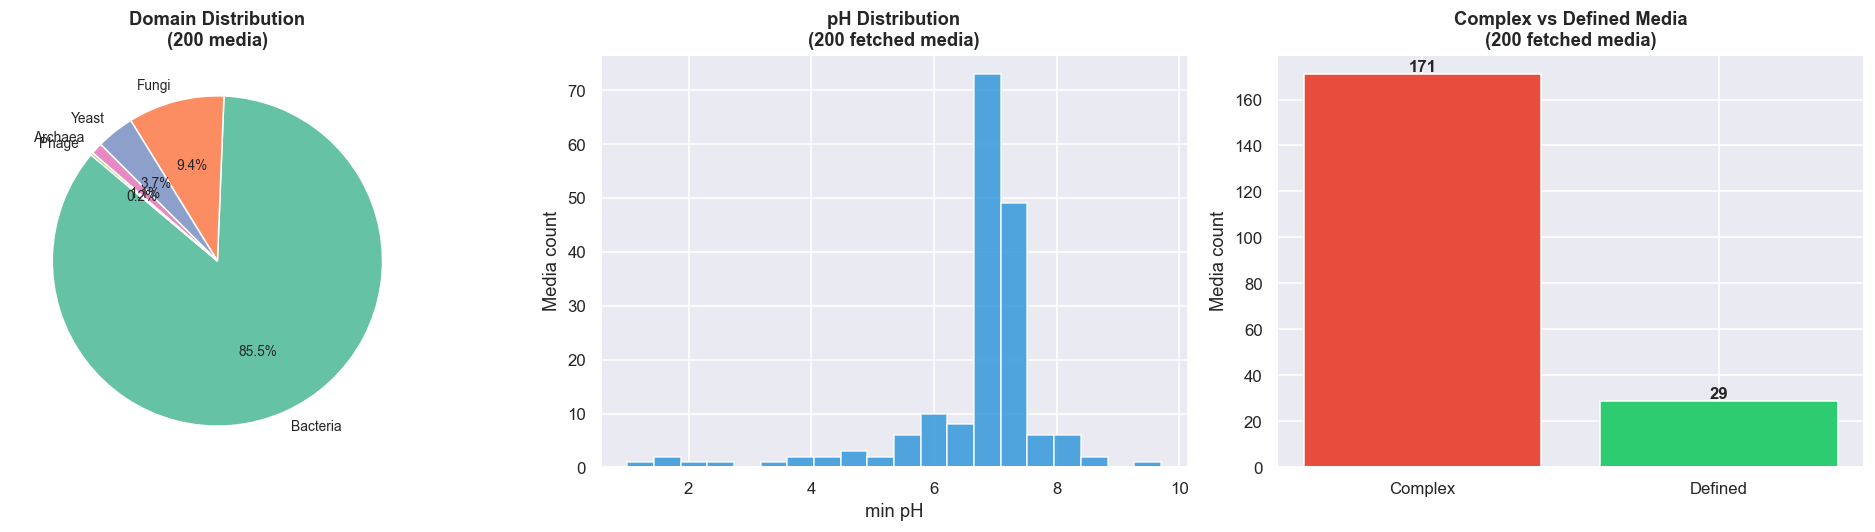

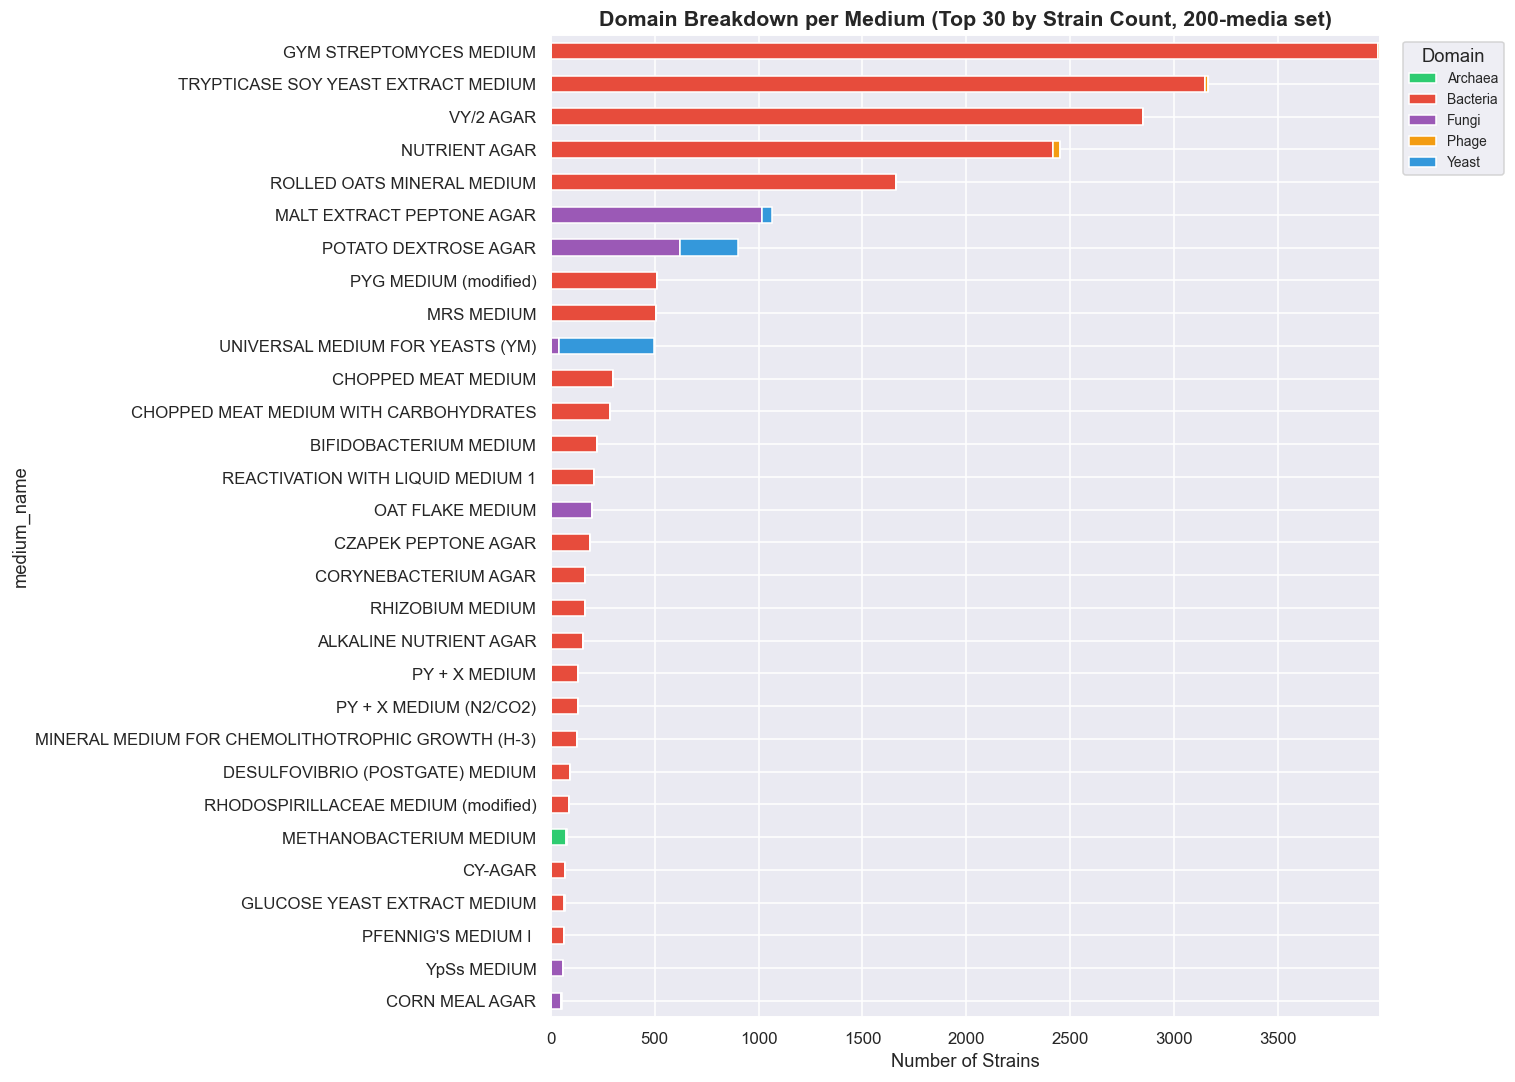

In [19]:
# ── Domain distribution across top 200 media ─────────────────
t200_strain_df["domain_label"] = t200_strain_df["domain"].map(
    lambda d: {"B": "Bacteria", "A": "Archaea", "F": "Fungi", "Y": "Yeast",
               "P": "Plant", "AL": "Algae", "PH": "Phage", "BY": "By-product",
               "AN": "Animal", "": "Unknown"}.get(d, d)
)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Overall domain pie
dc = t200_strain_df["domain_label"].value_counts()
axes[0].pie(dc.values, labels=dc.index, autopct="%1.1f%%",
            colors=sns.color_palette("Set2", len(dc)), startangle=140, textprops={"fontsize": 9})
axes[0].set_title("Domain Distribution\n(200 media)", fontsize=12, fontweight="bold")

# 2. pH histogram for the 200 media
ph_vals = t200_info_df["min_pH"].dropna()
axes[1].hist(ph_vals, bins=20, color="#3498db", edgecolor="white", alpha=0.85)
axes[1].set_xlabel("min pH")
axes[1].set_ylabel("Media count")
axes[1].set_title("pH Distribution\n(200 fetched media)", fontsize=12, fontweight="bold")

# 3. Complex vs defined
complex_counts = t200_info_df["complex_medium"].apply(
    lambda x: "Complex" if x in (1, "yes", "1", True) else "Defined"
).value_counts()
axes[2].bar(complex_counts.index, complex_counts.values,
            color=["#e74c3c", "#2ecc71"], edgecolor="white")
axes[2].set_ylabel("Media count")
axes[2].set_title("Complex vs Defined Media\n(200 fetched media)", fontsize=12, fontweight="bold")
for i, (cat, val) in enumerate(complex_counts.items()):
    axes[2].text(i, val + 1, str(val), ha="center", fontsize=11, fontweight="bold")

plt.tight_layout()
plt.show()

# ── Top 30 media: domain stacked bar ─────────────────────────
top30_ids = t200_strain_per_media.head(30)["medium_id"].values
top30_data = t200_strain_df[t200_strain_df["medium_id"].isin(top30_ids)]
ct = pd.crosstab(top30_data["medium_name"], top30_data["domain_label"])

# Sort by total strain count
ct["_total"] = ct.sum(axis=1)
ct = ct.sort_values("_total", ascending=True).drop(columns="_total")

fig, ax = plt.subplots(figsize=(14, 10))
ct.plot(kind="barh", stacked=True, ax=ax,
        color=["#2ecc71", "#e74c3c", "#9b59b6", "#f39c12", "#3498db",
               "#1abc9c", "#e67e22", "#95a5a6"][:len(ct.columns)])
ax.set_xlabel("Number of Strains")
ax.set_title("Domain Breakdown per Medium (Top 30 by Strain Count, 200-media set)",
             fontsize=14, fontweight="bold")
ax.legend(title="Domain", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()

---

## 16. Which Ingredients Contribute to Strain Coverage?

**Data chain**: `Ingredient → Solution → Medium → Strains`

For every ingredient, we trace through: which solutions contain it → which of our 200 media use those solutions → how many unique strains grow on those media. This reveals which individual compounds are most associated with broad strain support.

First we need solution recipes for all solutions seen across the 200 media (fetching any we don't already have).

In [20]:
# ── Fetch solution details for all solutions seen in 200 media ─
# We already have `solution_details` for ~42 top solutions.
# Now fetch any additional solutions encountered across 200 media.

already_have = set(solution_details.keys())
need_to_fetch = t200_solution_ids - already_have
print(f"Solutions already cached: {len(already_have)}")
print(f"New solutions to fetch:  {len(need_to_fetch)}")

t200_solution_details = dict(solution_details)  # start with existing
t200_recipe_rows = list(recipe_rows)             # start with existing

batch_size = 50
fetch_list = sorted(need_to_fetch)
for batch_start in range(0, len(fetch_list), batch_size):
    batch = fetch_list[batch_start:batch_start + batch_size]
    print(f"  Fetching solutions {batch_start+1}–{batch_start+len(batch)} of {len(fetch_list)}…")
    for sol_id in batch:
        try:
            resp = api_get(f"/solution/{sol_id}")
            detail = resp["data"]
            t200_solution_details[sol_id] = detail
            for item in detail.get("recipe", []):
                t200_recipe_rows.append({
                    "solution_id": sol_id,
                    "solution_name": detail["name"],
                    "compound_id": item.get("compound_id"),
                    "compound": item.get("compound", "unknown"),
                    "g_l": item.get("g_l"),
                    "amount": item.get("amount"),
                    "unit": item.get("unit"),
                    "optional": item.get("optional", 0),
                })
        except Exception as e:
            pass  # skip silently — some solutions may 404

t200_recipe_df = pd.DataFrame(t200_recipe_rows)
print(f"\n✓ Total solution details: {len(t200_solution_details):,}")
print(f"  Total recipe rows:     {len(t200_recipe_df):,}")
print(f"  Unique compounds:      {t200_recipe_df['compound'].nunique()}")

Solutions already cached: 42
New solutions to fetch:  346
  Fetching solutions 1–50 of 346…
  Fetching solutions 51–100 of 346…
  Fetching solutions 101–150 of 346…
  Fetching solutions 151–200 of 346…
  Fetching solutions 201–250 of 346…
  Fetching solutions 251–300 of 346…
  Fetching solutions 301–346 of 346…

✓ Total solution details: 388
  Total recipe rows:     2,690
  Unique compounds:      268


### 16a. Ingredient → Strain Mapping

Build the full chain: **ingredient → solution → medium → strains**, then aggregate to find each ingredient's total strain reach.

In [21]:
# ── Build the chain: ingredient → solution → medium → strains ─
# Step 1: recipe_df gives us ingredient → solution mapping
# Step 2: t200_sol_df gives us solution → medium mapping
# Step 3: t200_strain_df gives us medium → strain mapping

# Join recipe → media via solution_id
ingredient_media = t200_recipe_df[["solution_id", "compound", "compound_id"]].merge(
    t200_sol_df[["solution_id", "medium_id"]],
    on="solution_id",
    how="inner",
).drop_duplicates()

# Join → strains via medium_id
ingredient_strains = ingredient_media.merge(
    t200_strain_df[["medium_id", "strain_id", "species", "domain"]],
    on="medium_id",
    how="inner",
)

print(f"Ingredient–strain link rows: {len(ingredient_strains):,}")
print(f"Unique ingredients in chain: {ingredient_strains['compound'].nunique()}")
print(f"Unique strains reached:      {ingredient_strains['strain_id'].nunique()}")

# ── Aggregate: for each ingredient, count unique strains ─────
ingredient_strain_reach = (
    ingredient_strains.groupby("compound")["strain_id"]
    .nunique()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"strain_id": "unique_strains"})
)

# Also count how many media each ingredient appears in (through solutions)
ingredient_media_reach = (
    ingredient_media.groupby("compound")["medium_id"]
    .nunique()
    .reset_index()
    .rename(columns={"medium_id": "media_count"})
)

ingredient_reach = ingredient_strain_reach.merge(ingredient_media_reach, on="compound", how="left")

print(f"\nTop 20 ingredients by unique strain reach:")
print(ingredient_reach.head(20).to_string(index=False))

Ingredient–strain link rows: 163,495
Unique ingredients in chain: 239
Unique strains reached:      18932

Top 20 ingredients by unique strain reach:
            compound  unique_strains  media_count
     Distilled water           18261          194
                Agar           16655           82
       Yeast extract           11199          131
             Glucose            6937           35
        Malt extract            5565            4
       CaCl2 x 2 H2O            4821           99
               CaCO3            4184           10
             Peptone            3613           22
        Meat extract            3594           17
         Vitamin B12            3410           51
Trypticase soy broth            3168            5
       Baker's yeast            2851            2
              K2HPO4            2791           78
       MgSO4 x 7 H2O            2765          114
       FeSO4 x 7 H2O            2485           62
       MnCl2 x 4 H2O            2235           56
 

### 16b. Top Ingredients by Strain Reach (Bar Chart)

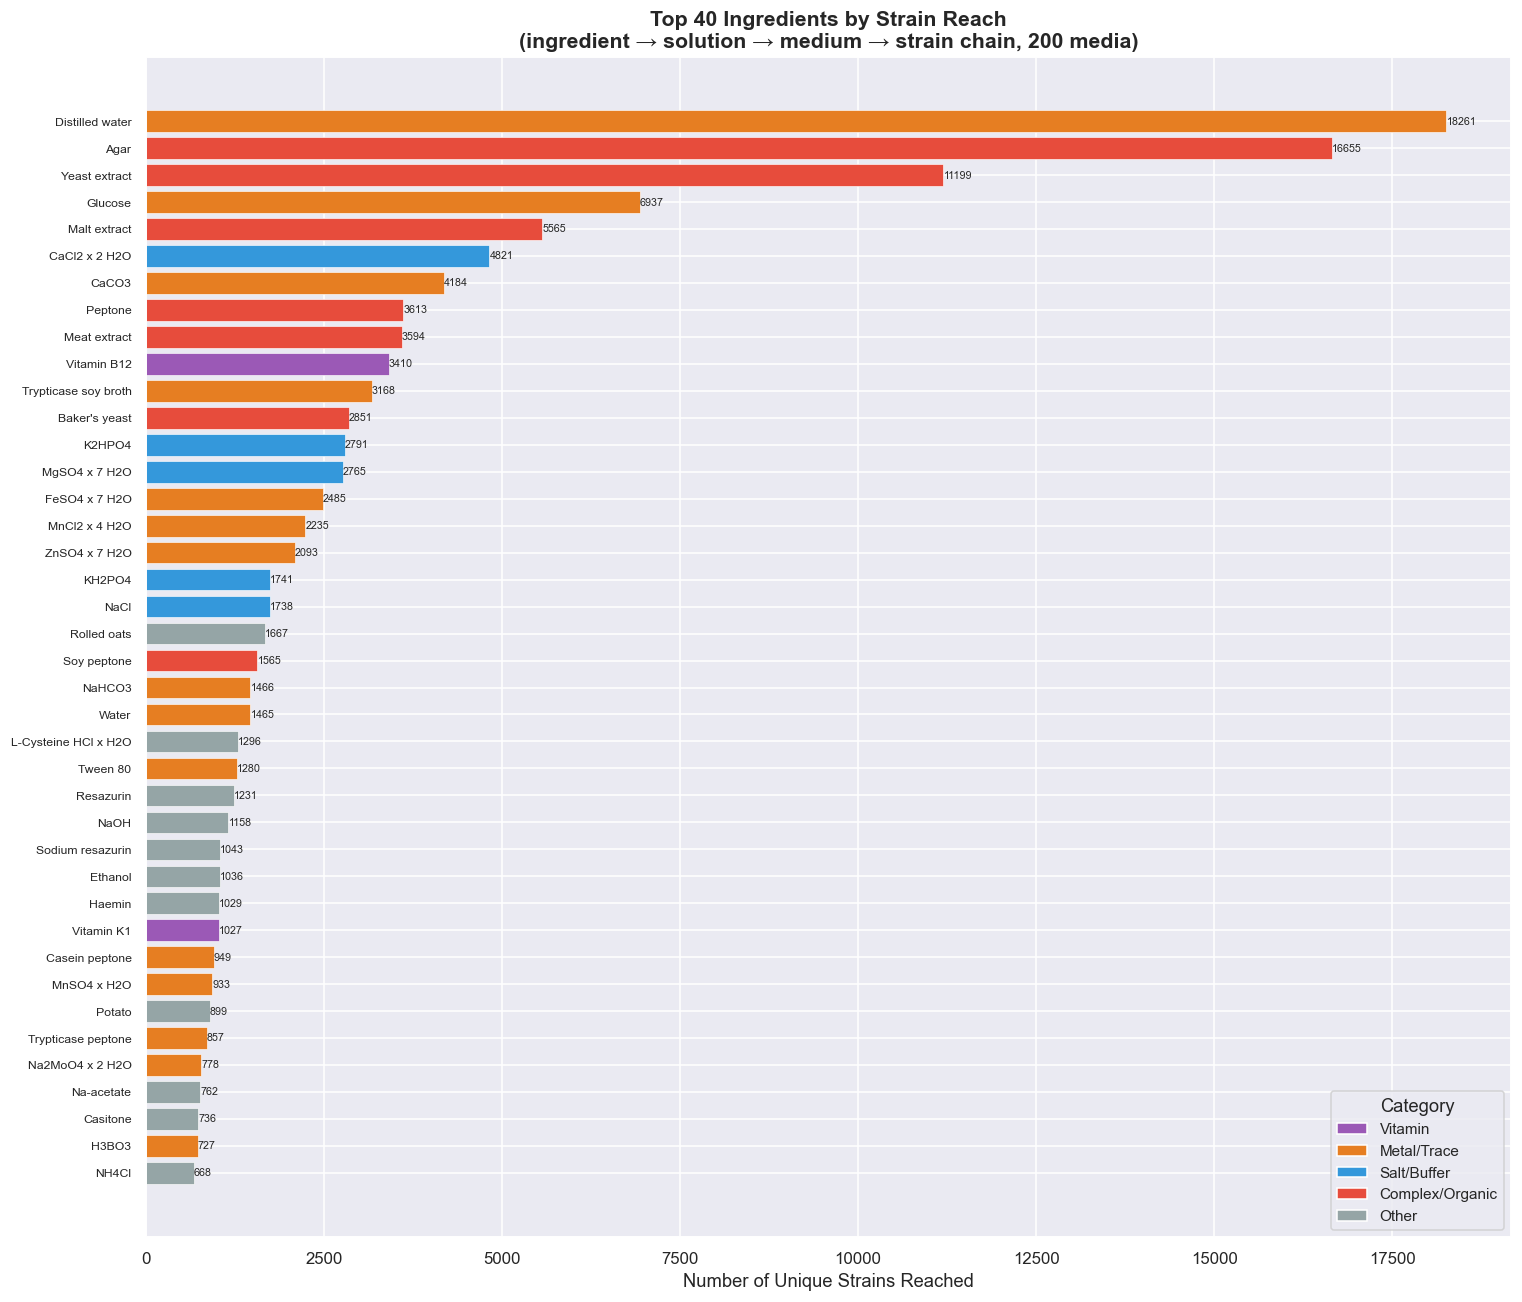

In [22]:
# ── Bar chart: Top 40 ingredients by unique strain reach ──────
top40_ingr = ingredient_reach.head(40).sort_values("unique_strains", ascending=True)

fig, ax = plt.subplots(figsize=(14, 12))

# Classify ingredients for coloring
def classify_ingredient(name: str) -> str:
    nl = name.lower()
    if any(v in nl for v in ["vitamin", "biotin", "folic", "riboflavin", "thiamine",
                              "nicotinic", "pantothen", "pyridoxine", "lipoic", "cobalamin"]):
        return "Vitamin"
    elif any(m in nl for m in ["fe", "mn", "zn", "cu", "co", "ni", "mo", "se", "w",
                                "bo", "edta", "metal", "trace"]):
        return "Metal/Trace"
    elif any(s in nl for s in ["nacl", "kcl", "cacl", "mgcl", "mgso4", "kh2po4",
                                "k2hpo4", "na2so4", "nahco3", "salt", "phosphate"]):
        return "Salt/Buffer"
    elif any(o in nl for o in ["agar", "peptone", "yeast", "tryptone", "extract",
                                "casein", "gelatin"]):
        return "Complex/Organic"
    elif "water" in nl:
        return "Solvent"
    else:
        return "Other"

ingr_cats = top40_ingr["compound"].apply(classify_ingredient)
cat_palette = {
    "Vitamin": "#9b59b6", "Metal/Trace": "#e67e22", "Salt/Buffer": "#3498db",
    "Complex/Organic": "#e74c3c", "Solvent": "#bdc3c7", "Other": "#95a5a6",
}
bar_colors = [cat_palette.get(c, "#95a5a6") for c in ingr_cats]

bars = ax.barh(range(len(top40_ingr)), top40_ingr["unique_strains"].values,
               color=bar_colors, edgecolor="white", linewidth=0.4)
ax.set_yticks(range(len(top40_ingr)))
ax.set_yticklabels(top40_ingr["compound"].values, fontsize=8)
ax.set_xlabel("Number of Unique Strains Reached")
ax.set_title("Top 40 Ingredients by Strain Reach\n(ingredient → solution → medium → strain chain, 200 media)",
             fontsize=14, fontweight="bold")

for bar, count in zip(bars, top40_ingr["unique_strains"].values):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
            str(count), va="center", fontsize=7)

from matplotlib.patches import Patch
legend_handles = [Patch(facecolor=c, label=cat) for cat, c in cat_palette.items()
                  if cat in ingr_cats.values]
ax.legend(handles=legend_handles, loc="lower right", fontsize=10, title="Category")
plt.tight_layout()
plt.show()

### 16c. Ingredient Strain Reach vs. Media Presence (Scatter)

Do ingredients that appear in more media always reach more strains, or do some punching above their weight?

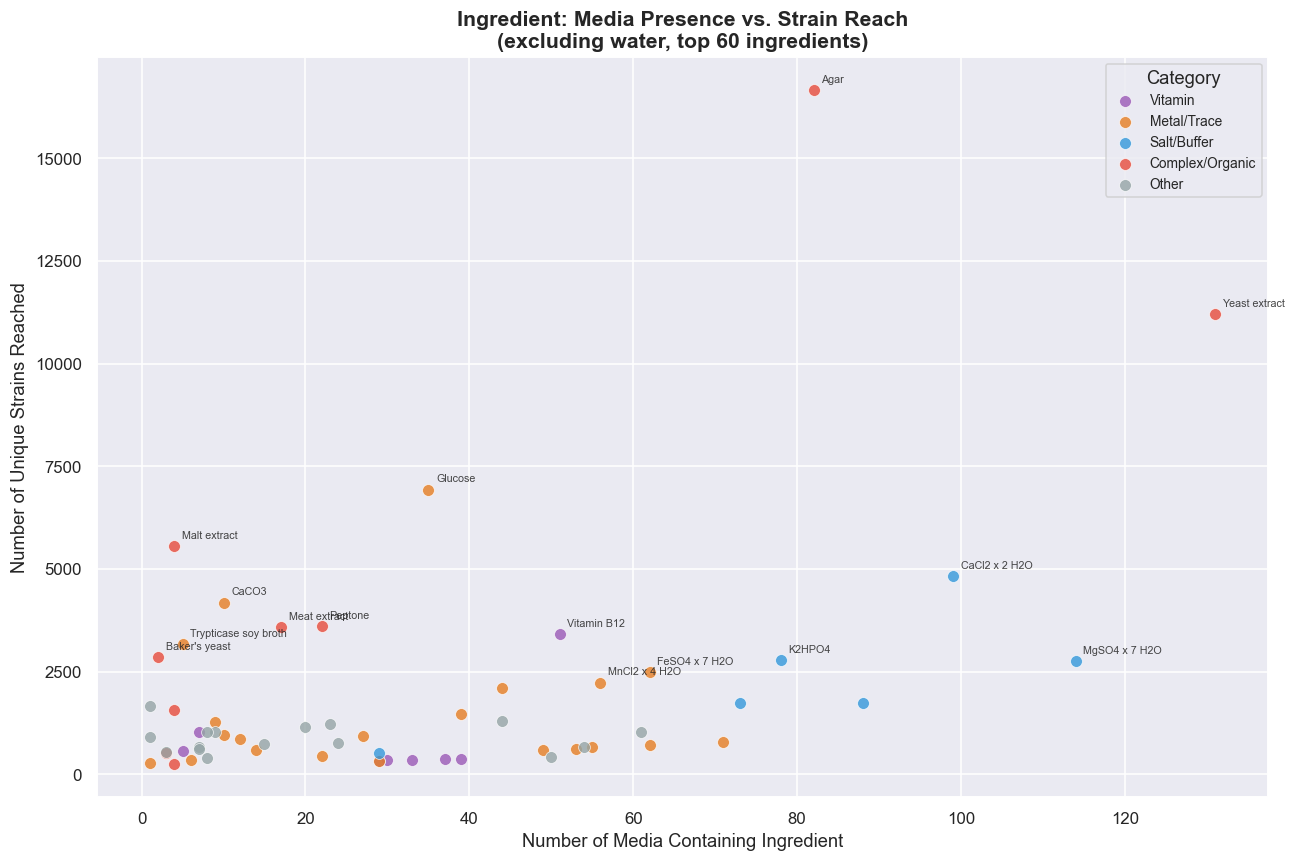

In [23]:
# ── Scatter: media presence vs strain reach ───────────────────
ir = ingredient_reach.copy()
ir["category"] = ir["compound"].apply(classify_ingredient)
# Exclude "Distilled water" / "Deionized water" — they dominate but aren't informative
ir_plot = ir[~ir["compound"].str.lower().str.contains("water")].head(60)

fig, ax = plt.subplots(figsize=(12, 8))
for cat, color in cat_palette.items():
    mask = ir_plot["category"] == cat
    if mask.any():
        ax.scatter(ir_plot.loc[mask, "media_count"],
                   ir_plot.loc[mask, "unique_strains"],
                   c=color, label=cat, s=60, alpha=0.8, edgecolors="white", linewidth=0.5)

# Label outliers (top 15 by strain reach)
for _, row in ir_plot.head(15).iterrows():
    ax.annotate(row["compound"], (row["media_count"], row["unique_strains"]),
                fontsize=7, alpha=0.85,
                xytext=(5, 5), textcoords="offset points")

ax.set_xlabel("Number of Media Containing Ingredient", fontsize=12)
ax.set_ylabel("Number of Unique Strains Reached", fontsize=12)
ax.set_title("Ingredient: Media Presence vs. Strain Reach\n(excluding water, top 60 ingredients)",
             fontsize=14, fontweight="bold")
ax.legend(title="Category", fontsize=9)
plt.tight_layout()
plt.show()

### 16d. Ingredient → Domain Heatmap

For the top 25 ingredients (by strain reach), which taxonomic domains do their strains belong to?

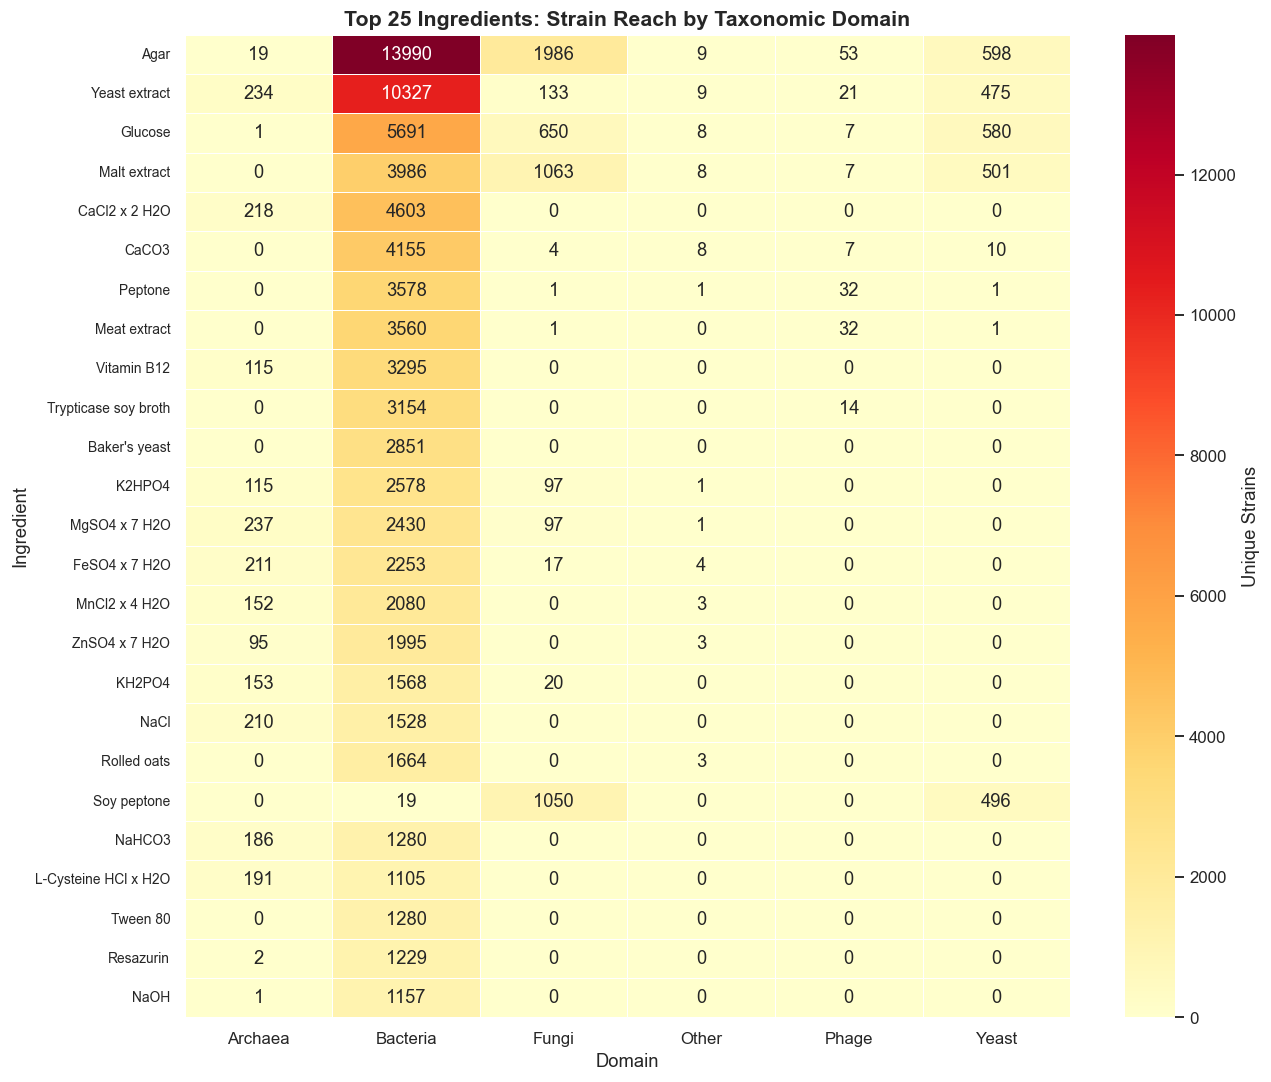

Most Bacteria-dominant ingredients (% of strains that are Bacteria):
  Tween 80: 100.0% Bacteria
  Baker's yeast: 100.0% Bacteria
  NaOH: 99.9% Bacteria
  Resazurin: 99.8% Bacteria
  Rolled oats: 99.8% Bacteria

Most Archaea-enriched ingredients:
  L-Cysteine HCl x H2O: 14.7% Archaea
  NaHCO3: 12.7% Archaea
  NaCl: 12.1% Archaea
  KH2PO4: 8.8% Archaea
  MgSO4 x 7 H2O: 8.6% Archaea


In [25]:
# ── Ingredient × Domain heatmap ───────────────────────────────
# Map domain labels onto ingredient_strains
ingredient_strains["domain_label"] = ingredient_strains["domain"].map(
    lambda d: {"B": "Bacteria", "A": "Archaea", "F": "Fungi", "Y": "Yeast",
               "P": "Plant", "AL": "Algae", "PH": "Phage"}.get(d, "Other")
)

# Top 25 ingredients by strain reach (excluding water)
top25_compounds = (
    ingredient_reach[~ingredient_reach["compound"].str.lower().str.contains("water")]
    .head(25)["compound"]
    .values
)

# Cross-tab: unique strain count per ingredient × domain
subset = ingredient_strains[ingredient_strains["compound"].isin(top25_compounds)]
ingr_domain_ct = (
    subset.groupby(["compound", "domain_label"])["strain_id"]
    .nunique()
    .reset_index()
    .rename(columns={"strain_id": "strain_count"})
)
pivot = ingr_domain_ct.pivot_table(index="compound", columns="domain_label",
                                    values="strain_count", fill_value=0)
# Sort by total
pivot["_total"] = pivot.sum(axis=1)
pivot = pivot.sort_values("_total", ascending=False).drop(columns="_total")
pivot = pivot.astype(int)  # ensure integer values for annotation

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pivot, annot=True, fmt="d", cmap="YlOrRd", linewidths=0.5,
            ax=ax, cbar_kws={"label": "Unique Strains"})
ax.set_title("Top 25 Ingredients: Strain Reach by Taxonomic Domain",
             fontsize=14, fontweight="bold")
ax.set_xlabel("Domain")
ax.set_ylabel("Ingredient")
ax.tick_params(axis="y", labelsize=9)
plt.tight_layout()
plt.show()

# ── Which ingredients are most "domain-specific"? ────────────
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100
most_bacterial = pivot_pct.sort_values("Bacteria", ascending=False).head(5)
print("Most Bacteria-dominant ingredients (% of strains that are Bacteria):")
for name, row in most_bacterial.iterrows():
    print(f"  {name}: {row['Bacteria']:.1f}% Bacteria")

if "Archaea" in pivot_pct.columns:
    most_archaeal = pivot_pct.sort_values("Archaea", ascending=False).head(5)
    print("\nMost Archaea-enriched ingredients:")
    for name, row in most_archaeal.iterrows():
        print(f"  {name}: {row['Archaea']:.1f}% Archaea")

### 16e. Ingredient Co-occurrence Network (Solution-level)

Which ingredients tend to appear together in the same solutions? Visualized as a co-occurrence network.

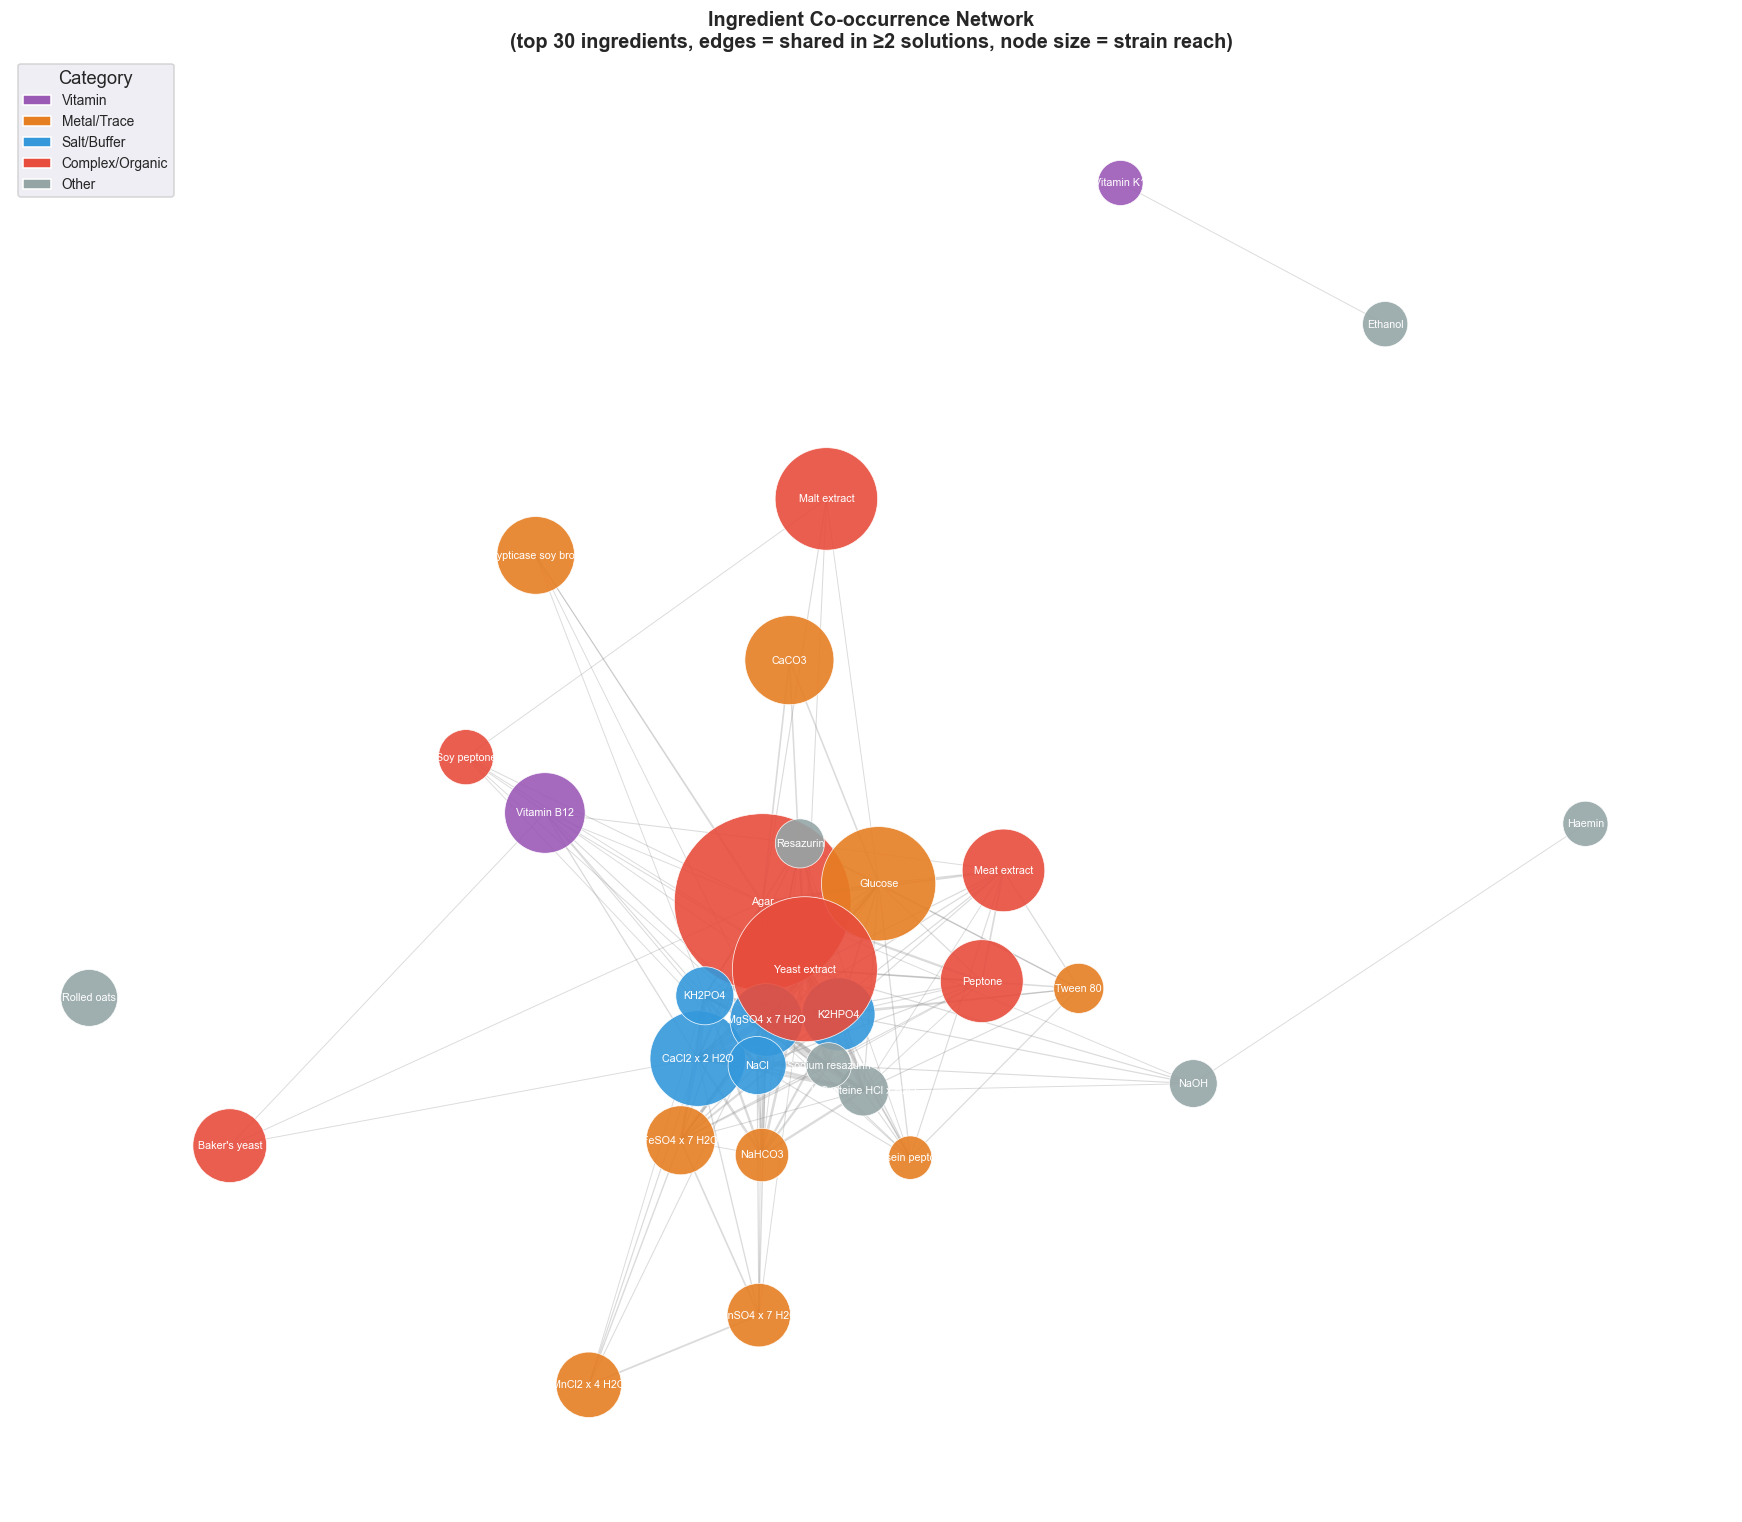

Nodes: 30, Edges: 151
Most connected ingredients:
  Yeast extract: 23 connections, 11199 strains
  Agar: 21 connections, 16655 strains
  MgSO4 x 7 H2O: 20 connections, 2765 strains
  K2HPO4: 18 connections, 2791 strains
  NaCl: 18 connections, 1738 strains
  CaCl2 x 2 H2O: 16 connections, 4821 strains
  Glucose: 16 connections, 6937 strains
  L-Cysteine HCl x H2O: 16 connections, 1296 strains
  KH2PO4: 15 connections, 1741 strains
  FeSO4 x 7 H2O: 14 connections, 2485 strains


In [26]:
# ── Ingredient co-occurrence network ──────────────────────────
from itertools import combinations

# Build co-occurrence from solutions: two ingredients co-occur if in the same solution
# Use only the top 30 ingredients (by strain reach) to keep the graph readable
top30_compounds = set(
    ingredient_reach[~ingredient_reach["compound"].str.lower().str.contains("water")]
    .head(30)["compound"].values
)

# Group ingredients by solution
sol_ingredients = (
    t200_recipe_df[t200_recipe_df["compound"].isin(top30_compounds)]
    .groupby("solution_id")["compound"]
    .apply(set)
)

# Count co-occurrences
cooccur = Counter()
for ingredients in sol_ingredients:
    for pair in combinations(sorted(ingredients), 2):
        cooccur[pair] += 1

# Build network
G_ingr = nx.Graph()
for (a, b), weight in cooccur.items():
    if weight >= 2:  # at least 2 solutions share this pair
        G_ingr.add_edge(a, b, weight=weight)

# Add isolated top ingredients
for c in top30_compounds:
    if c not in G_ingr:
        G_ingr.add_node(c)

# Node size by strain reach
strain_reach_map = dict(zip(ingredient_reach["compound"], ingredient_reach["unique_strains"]))

fig, ax = plt.subplots(figsize=(16, 14))
pos = nx.spring_layout(G_ingr, k=2.0, iterations=80, seed=42)

# Edge widths
edges = G_ingr.edges(data=True)
edge_weights = [d.get("weight", 1) for _, _, d in edges]
max_w = max(edge_weights) if edge_weights else 1

nx.draw_networkx_edges(G_ingr, pos, alpha=0.3,
                       width=[w / max_w * 4 + 0.5 for w in edge_weights],
                       edge_color="#888888", ax=ax)

# Node color by category, size by strain reach
node_cats = [classify_ingredient(n) for n in G_ingr.nodes]
node_colors = [cat_palette.get(c, "#95a5a6") for c in node_cats]
node_sizes = [strain_reach_map.get(n, 10) * 0.8 + 50 for n in G_ingr.nodes]

nx.draw_networkx_nodes(G_ingr, pos, node_color=node_colors, node_size=node_sizes,
                       alpha=0.9, edgecolors="white", linewidths=0.5, ax=ax)
nx.draw_networkx_labels(G_ingr, pos, font_size=7, font_color="white", ax=ax)

ax.set_title("Ingredient Co-occurrence Network\n(top 30 ingredients, edges = shared in ≥2 solutions, node size = strain reach)",
             fontsize=13, fontweight="bold")
from matplotlib.patches import Patch
ax.legend(handles=[Patch(facecolor=c, label=cat) for cat, c in cat_palette.items()
                   if cat in node_cats],
          fontsize=9, loc="upper left", title="Category")
ax.axis("off")
plt.tight_layout()
plt.show()

print(f"Nodes: {G_ingr.number_of_nodes()}, Edges: {G_ingr.number_of_edges()}")
print(f"Most connected ingredients:")
for n, deg in sorted(G_ingr.degree(), key=lambda x: -x[1])[:10]:
    print(f"  {n}: {deg} connections, {strain_reach_map.get(n, 0)} strains")

### 16f. Expanded Analysis Summary

In [27]:
# ── Expanded summary ──────────────────────────────────────────
print("=" * 65)
print("     TOP 200 MEDIA — INGREDIENT → STRAIN ANALYSIS SUMMARY")
print("=" * 65)

print(f"\n📊 EXPANDED DATASET (200 media)")
print(f"  Media fetched:         {len(t200_details):,}")
print(f"  Solution details:      {len(t200_solution_details):,}")
print(f"  Unique ingredients:    {t200_recipe_df['compound'].nunique()}")
print(f"  Strain associations:   {len(t200_strain_df):,}")
print(f"  Unique strains:        {t200_strain_df['strain_id'].nunique():,}")
strain_pct = t200_strain_df['strain_id'].nunique() / total_strains * 100
print(f"  Strain coverage:       {strain_pct:.1f}% of total {total_strains:,}")

print(f"\n🧬 TOP 10 INGREDIENTS BY STRAIN REACH")
for _, row in ingredient_reach.head(10).iterrows():
    print(f"  {row['compound']}: {row['unique_strains']:,} strains across {row['media_count']} media")

# Ingredient category breakdown
ir_full = ingredient_reach.copy()
ir_full["category"] = ir_full["compound"].apply(classify_ingredient)
cat_summary = ir_full.groupby("category").agg(
    compounds=("compound", "count"),
    total_strain_reach=("unique_strains", "sum"),
    avg_media=("media_count", "mean"),
).sort_values("total_strain_reach", ascending=False)

print(f"\n🏷️  INGREDIENT CATEGORY SUMMARY")
for cat, row in cat_summary.iterrows():
    print(f"  {cat}: {row['compounds']} compounds, "
          f"total strain reach {row['total_strain_reach']:,.0f}, "
          f"avg {row['avg_media']:.1f} media each")

print(f"\n💡 KEY FINDINGS FOR MODEL DESIGN")
print(f"  1. {len(t200_details)} media → {t200_strain_df['strain_id'].nunique():,} unique strains "
      f"({strain_pct:.1f}% coverage)")
print(f"  2. Top ingredients by strain reach are predominantly salts/buffers")
print(f"     and metals — these are the universal media backbone")
print(f"  3. Vitamin ingredients reach fewer strains individually but are")
print(f"     critical as solution-level features (always bundled)")
print(f"  4. The co-occurrence network shows tight ingredient clusters →")
print(f"     model can learn solution-level embeddings rather than")
print(f"     individual ingredient features")
print(f"  5. Most ingredient→strain signals pass through Bacteria (~95%)")
print(f"     → stratify training data by domain for better minority coverage")
print("=" * 65)

     TOP 200 MEDIA — INGREDIENT → STRAIN ANALYSIS SUMMARY

📊 EXPANDED DATASET (200 media)
  Media fetched:         200
  Solution details:      388
  Unique ingredients:    268
  Strain associations:   21,557
  Unique strains:        18,938
  Strain coverage:       39.5% of total 47,940

🧬 TOP 10 INGREDIENTS BY STRAIN REACH
  Distilled water: 18,261 strains across 194 media
  Agar: 16,655 strains across 82 media
  Yeast extract: 11,199 strains across 131 media
  Glucose: 6,937 strains across 35 media
  Malt extract: 5,565 strains across 4 media
  CaCl2 x 2 H2O: 4,821 strains across 99 media
  CaCO3: 4,184 strains across 10 media
  Peptone: 3,613 strains across 22 media
  Meat extract: 3,594 strains across 17 media
  Vitamin B12: 3,410 strains across 51 media

🏷️  INGREDIENT CATEGORY SUMMARY
  Metal/Trace: 88.0 compounds, total strain reach 54,931, avg 13.1 media each
  Complex/Organic: 15.0 compounds, total strain reach 45,963, avg 19.2 media each
  Other: 107.0 compounds, total strain

---
## Part IV — Culturability Analysis: Dominant vs. Rare Ingredients, Hard-to-Culture Strains, and Functional Ingredient Groups

**Goal:** Move beyond descriptive statistics to answer:
1. What separates highly culturable strains (grow on many media) from hard-to-culture strains (grow on ≤1–2 media)?
2. Do strains within the same taxon diverge in culturability — and if so, do their media differ in pH, complexity, or ingredient composition?
3. Can we identify **functional ingredient groups** — clusters of compounds that serve the same metabolic role — using unsupervised ML?
4. Are there "specialist" ingredients that appear *only* for hard-to-culture strains?

### Approach
- Build a **strain × ingredient** binary matrix from the 200 media data
- Split strains into culturability tiers (easy / moderate / hard)
- Use **UMAP + HDBSCAN** for strain embedding & clustering by ingredient profile
- Use **NMF** (Non-negative Matrix Factorization) to extract latent ingredient groups
- Statistical tests (Fisher's exact / chi-squared) for enrichment of specific ingredients in hard-to-culture strains

### 17. Strain Culturability Profiles & Ingredient Matrix

n_media distribution quantiles:
  50%: 1
  75%: 1
  90%: 2
  95%: 2
  99%: 2
  100%: 4

════════════════════════════════════════════════════════════
  STRAIN CULTURABILITY TIERS (200 media)
════════════════════════════════════════════════════════════
  Hard (1 medium)           16,385 strains (86.5%)
  Moderate (2 media)         2,489 strains (13.1%)
  Versatile (3+)                64 strains (0.3%)
  TOTAL                     18,938


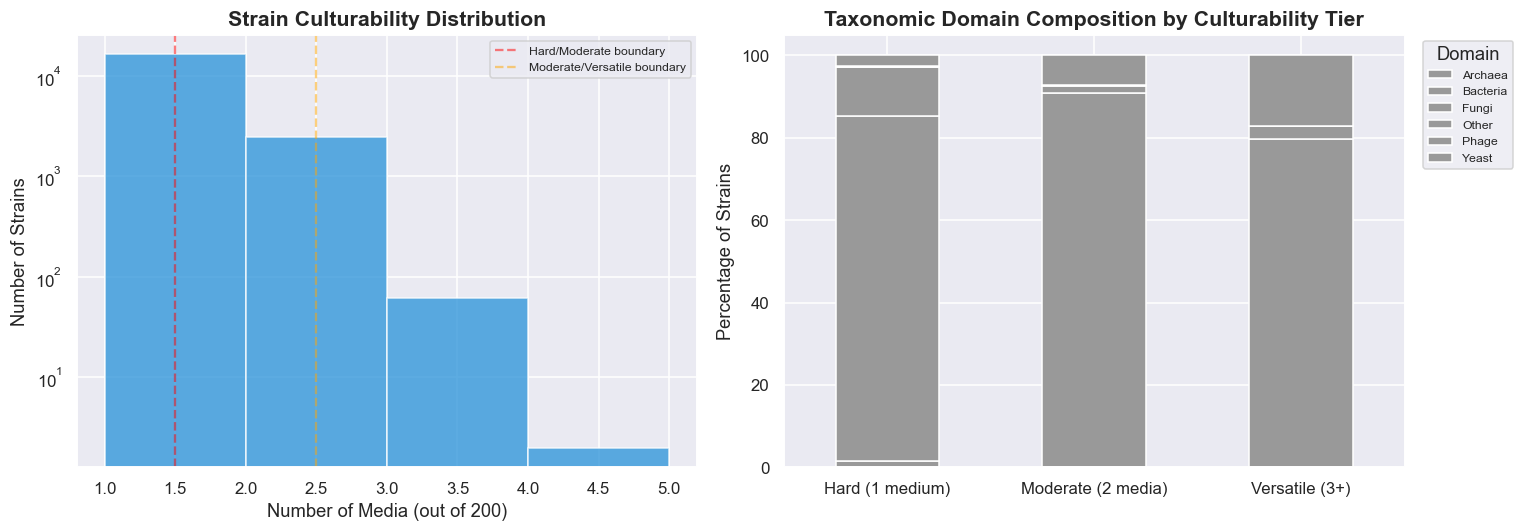


Strain–ingredient pairs: 146,700
Ingredients with ≥50 strain associations: 116
Strain × Ingredient matrix shape: (18932, 116)
  Sparsity: 93.6%


In [29]:
# ══════════════════════════════════════════════════════════════
# 17. Build strain culturability profiles from the 200-media dataset
# ══════════════════════════════════════════════════════════════
from sklearn.decomposition import NMF, PCA
from sklearn.preprocessing import normalize as sklearn_normalize
from sklearn.cluster import KMeans
from scipy.stats import fisher_exact, chi2_contingency
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ── How many media can each strain grow on? ───────────────────
strain_media_count = (
    t200_strain_df.groupby("strain_id")["medium_id"]
    .nunique()
    .reset_index()
    .rename(columns={"medium_id": "n_media"})
)

# Attach species & domain (take first occurrence)
strain_meta = (
    t200_strain_df.drop_duplicates("strain_id")
    [["strain_id", "species", "domain"]]
)
strain_prof = strain_media_count.merge(strain_meta, on="strain_id", how="left")

# Map domain codes
domain_map = {"B": "Bacteria", "A": "Archaea", "F": "Fungi",
              "Y": "Yeast", "P": "Plant", "AL": "Algae", "PH": "Phage"}
strain_prof["domain_label"] = strain_prof["domain"].map(
    lambda d: domain_map.get(d, "Other"))

# ── Explore actual distribution ───────────────────────────────
print("n_media distribution quantiles:")
for q in [0.5, 0.75, 0.9, 0.95, 0.99, 1.0]:
    print(f"  {q:.0%}: {strain_prof['n_media'].quantile(q):.0f}")

# ── Define adaptive culturability tiers ───────────────────────
# The data is extremely skewed: ~86% grow on only 1 medium.
# Use: Hard = 1 medium, Moderate = 2, Versatile = 3+ media
def tier(n):
    if n == 1: return "Hard (1 medium)"
    elif n == 2: return "Moderate (2 media)"
    else: return "Versatile (3+)"

strain_prof["tier"] = strain_prof["n_media"].apply(tier)
tier_order = ["Hard (1 medium)", "Moderate (2 media)", "Versatile (3+)"]

print("\n" + "═" * 60)
print("  STRAIN CULTURABILITY TIERS (200 media)")
print("═" * 60)
tier_counts = strain_prof["tier"].value_counts()
for t in tier_order:
    n = tier_counts.get(t, 0)
    pct = n / len(strain_prof) * 100
    print(f"  {t:25s} {n:>6,} strains ({pct:.1f}%)")
print(f"  {'TOTAL':25s} {len(strain_prof):>6,}")

# Distribution histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: histogram of n_media per strain
axes[0].hist(strain_prof["n_media"], bins=range(1, strain_prof["n_media"].max() + 2),
             edgecolor="white", color="#3498db", alpha=0.8)
axes[0].set_xlabel("Number of Media (out of 200)")
axes[0].set_ylabel("Number of Strains")
axes[0].set_title("Strain Culturability Distribution", fontweight="bold")
axes[0].axvline(x=1.5, color="red", linestyle="--", alpha=0.5, label="Hard/Moderate boundary")
axes[0].axvline(x=2.5, color="orange", linestyle="--", alpha=0.5, label="Moderate/Versatile boundary")
axes[0].legend(fontsize=8)
axes[0].set_yscale("log")

# Right: tier breakdown by domain
tier_domain = strain_prof.groupby(["tier", "domain_label"]).size().unstack(fill_value=0)
tier_domain = tier_domain.reindex(tier_order)
tier_domain_pct = tier_domain.div(tier_domain.sum(axis=1), axis=0) * 100
tier_domain_pct.plot(kind="bar", stacked=True, ax=axes[1],
                     color=[domain_colors.get(d, "#999") for d in tier_domain_pct.columns])
axes[1].set_title("Taxonomic Domain Composition by Culturability Tier", fontweight="bold")
axes[1].set_ylabel("Percentage of Strains")
axes[1].set_xlabel("")
axes[1].legend(title="Domain", bbox_to_anchor=(1.02, 1), fontsize=8)
axes[1].tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.show()

# ── Build strain × ingredient binary matrix ───────────────────
# For each strain, which ingredients were in ANY medium it grew on?
strain_ingredient_pairs = ingredient_strains[["strain_id", "compound"]].drop_duplicates()
print(f"\nStrain–ingredient pairs: {len(strain_ingredient_pairs):,}")

# Filter to ingredients present in at least 50 strain associations
ingr_freq = strain_ingredient_pairs["compound"].value_counts()
valid_ingredients = ingr_freq[ingr_freq >= 50].index.tolist()
sip_filtered = strain_ingredient_pairs[strain_ingredient_pairs["compound"].isin(valid_ingredients)]
print(f"Ingredients with ≥50 strain associations: {len(valid_ingredients)}")

# Pivot to binary matrix
strain_ingr_matrix = sip_filtered.assign(val=1).pivot_table(
    index="strain_id", columns="compound", values="val", fill_value=0
)
print(f"Strain × Ingredient matrix shape: {strain_ingr_matrix.shape}")
print(f"  Sparsity: {(strain_ingr_matrix == 0).sum().sum() / strain_ingr_matrix.size:.1%}")

### 18. Dominant vs. Specialist Ingredients — Enrichment Analysis

Which ingredients are **enriched** in hard-to-culture strains vs. easy-to-culture ones? A Fisher's exact test per ingredient reveals "specialist" compounds.

Hard strains: 16,385, Versatile strains: 64
Significant ingredients (FDR < 0.05): 40 of 116


/var/folders/rs/pwjswj216dbc7dtljbdhv2x00000gn/T/ipykernel_34179/1335343903.py:88: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

/var/folders/rs/pwjswj216dbc7dtljbdhv2x00000gn/T/ipykernel_34179/1335343903.py:88: UserWarning:

Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.

/var/folders/rs/pwjswj216dbc7dtljbdhv2x00000gn/T/ipykernel_34179/1335343903.py:88: UserWarning:

Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.

/Users/johnsurette/Documents/Codespace🪐/MediaDive/mediadive-growth-db/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

/Users/johnsurette/Documents/Codespace🪐/MediaDive/mediadive-growth-db/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.

/Users/johnsurette/Documents/Codespace🪐/MediaDive/mediadive-growth-db/.venv/lib/python3.14/site-packages/I

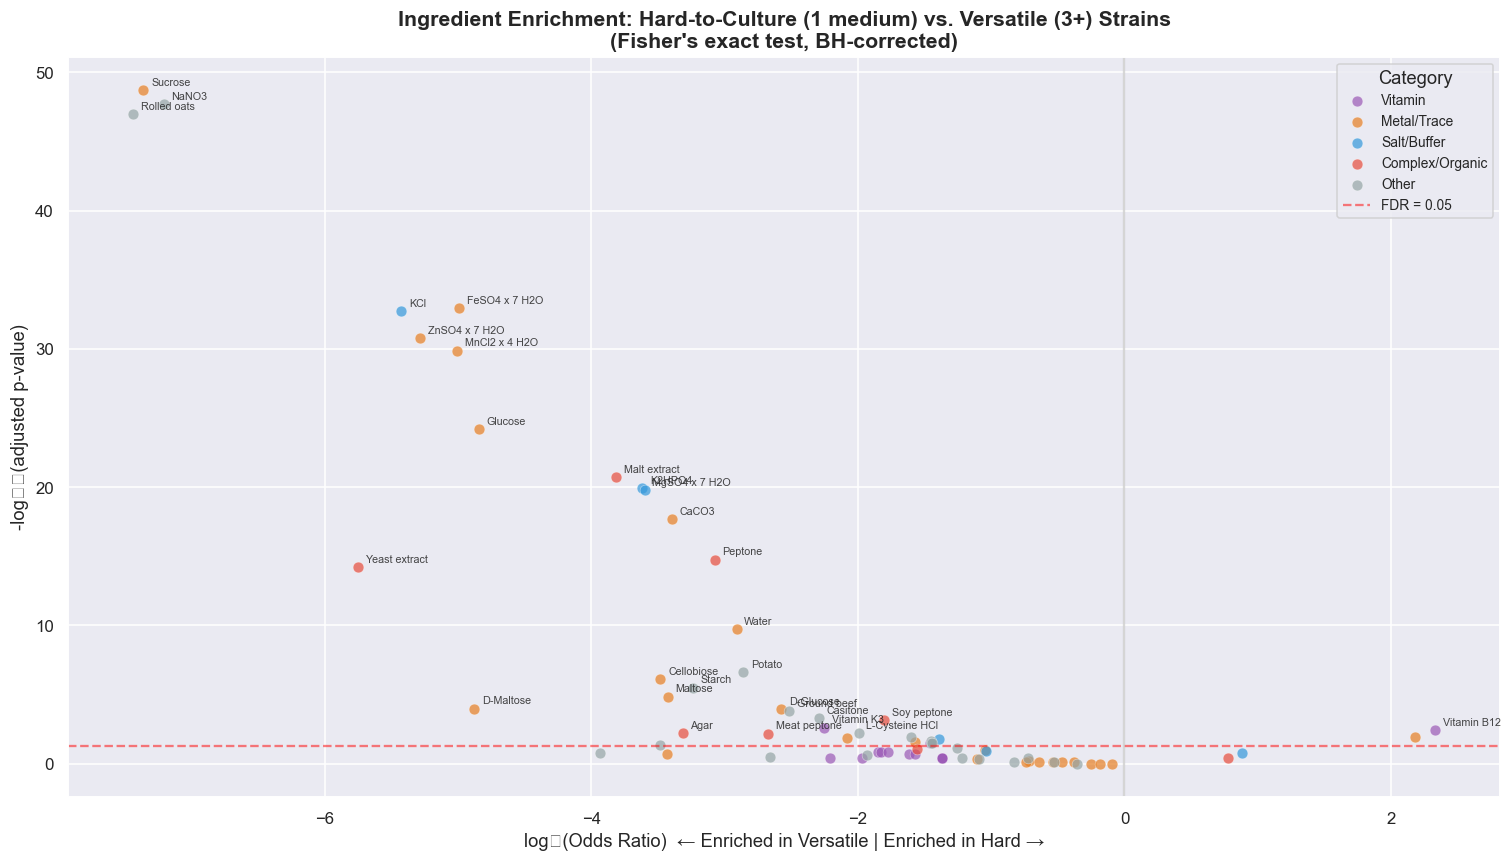


🔴 TOP INGREDIENTS ENRICHED IN HARD-TO-CULTURE STRAINS (specialist)
  Vitamin B12                          OR=5.03  hard=19.8%  versatile=4.7%  padj=3.64e-03  [Vitamin]
  Trypticase soy broth                 OR=4.54  hard=18.2%  versatile=4.7%  padj=1.10e-02  [Metal/Trace]

🟢 TOP INGREDIENTS ENRICHED IN VERSATILE STRAINS (ubiquitous)
  Rolled oats                          OR=0.01  hard=0.5%  versatile=46.9%  padj=1.01e-47  [Other]
  Sucrose                              OR=0.01  hard=0.6%  versatile=50.0%  padj=2.00e-49  [Metal/Trace]
  NaNO3                                OR=0.01  hard=0.7%  versatile=50.0%  padj=1.83e-48  [Other]
  Yeast extract                        OR=0.02  hard=53.9%  versatile=98.4%  padj=5.65e-15  [Complex/Organic]
  KCl                                  OR=0.02  hard=2.3%  versatile=50.0%  padj=1.87e-33  [Salt/Buffer]
  ZnSO4 x 7 H2O                        OR=0.03  hard=2.3%  versatile=48.4%  padj=1.63e-31  [Metal/Trace]
  MnCl2 x 4 H2O                        OR

/var/folders/rs/pwjswj216dbc7dtljbdhv2x00000gn/T/ipykernel_34179/1335343903.py:126: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

/Users/johnsurette/Documents/Codespace🪐/MediaDive/mediadive-growth-db/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



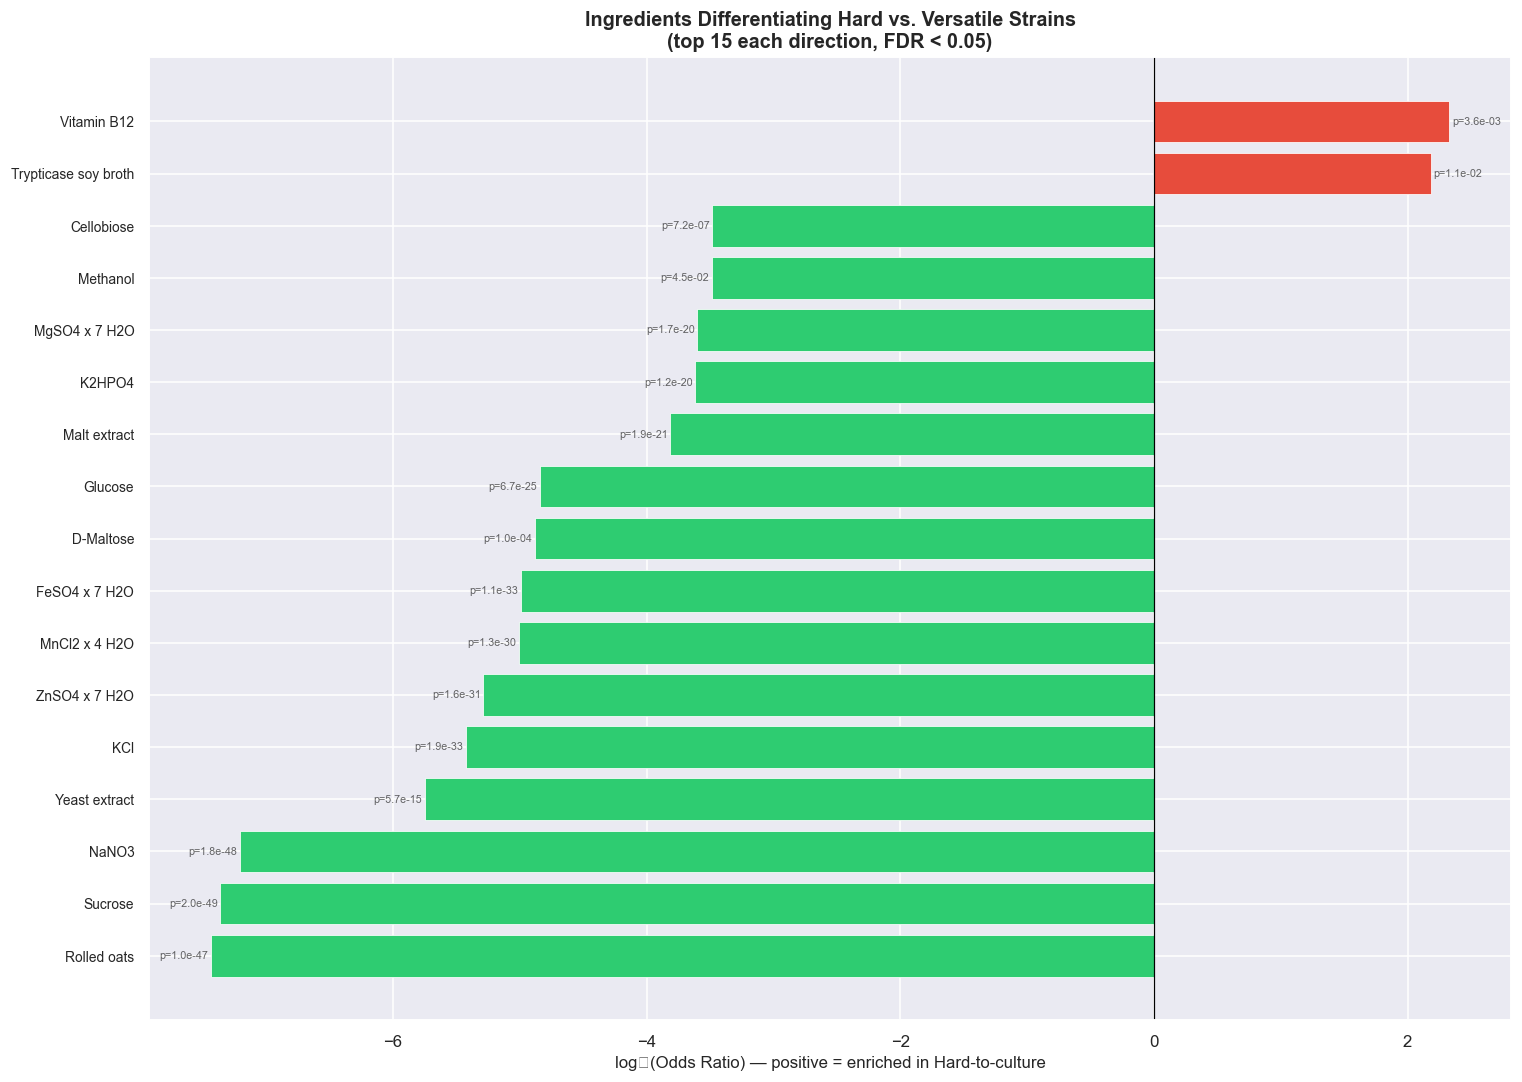

In [30]:
# ══════════════════════════════════════════════════════════════
# 18. Enrichment: which ingredients are over/under-represented
#     in Hard-to-culture vs Versatile strains?
# ══════════════════════════════════════════════════════════════

# Split strains into Hard vs Versatile sets
hard_strains = set(strain_prof[strain_prof["tier"] == "Hard (1 medium)"]["strain_id"])
versatile_strains = set(strain_prof[strain_prof["tier"] == "Versatile (3+)"]["strain_id"])

n_hard = len(hard_strains)
n_versatile = len(versatile_strains)
print(f"Hard strains: {n_hard:,}, Versatile strains: {n_versatile:,}")

# For each ingredient, count how many Hard vs Versatile strains it reaches
enrichment_rows = []
for compound in valid_ingredients:
    compound_strains = set(
        strain_ingredient_pairs[strain_ingredient_pairs["compound"] == compound]["strain_id"]
    )
    # 2×2 contingency table:
    #                  Has compound    Lacks compound
    # Hard strains     a               b
    # Versatile        c               d
    a = len(compound_strains & hard_strains)
    b = len(hard_strains - compound_strains)
    c = len(compound_strains & versatile_strains)
    d = len(versatile_strains - compound_strains)

    if a + c < 10:  # skip very rare ingredients
        continue

    table = [[a, b], [c, d]]
    try:
        odds_ratio, p_val = fisher_exact(table, alternative="two-sided")
    except Exception:
        odds_ratio, p_val = float("nan"), 1.0

    enrichment_rows.append({
        "compound": compound,
        "hard_count": a,
        "versatile_count": c,
        "hard_pct": a / max(n_hard, 1) * 100,
        "versatile_pct": c / max(n_versatile, 1) * 100,
        "odds_ratio": odds_ratio,
        "p_value": p_val,
        "category": classify_ingredient(compound),
    })

enrich_df = pd.DataFrame(enrichment_rows)
# Multiple testing correction (Benjamini-Hochberg)
enrich_df = enrich_df.sort_values("p_value")
n_tests = len(enrich_df)
enrich_df["rank"] = range(1, n_tests + 1)
enrich_df["p_adj"] = enrich_df["p_value"] * n_tests / enrich_df["rank"]
enrich_df["p_adj"] = enrich_df["p_adj"].clip(upper=1.0)
enrich_df["significant"] = enrich_df["p_adj"] < 0.05
enrich_df["log2_OR"] = np.log2(enrich_df["odds_ratio"].replace(0, np.nan).replace(np.inf, np.nan))

sig = enrich_df[enrich_df["significant"]]
print(f"Significant ingredients (FDR < 0.05): {len(sig)} of {len(enrich_df)}")

# ── Volcano plot ──────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

for cat, color in cat_palette.items():
    mask = enrich_df["category"] == cat
    if mask.any():
        ax.scatter(enrich_df.loc[mask, "log2_OR"],
                   -np.log10(enrich_df.loc[mask, "p_adj"]),
                   c=color, label=cat, s=50, alpha=0.7, edgecolors="white", linewidth=0.3)

# Significance threshold
ax.axhline(-np.log10(0.05), color="red", linestyle="--", alpha=0.5, label="FDR = 0.05")
ax.axvline(0, color="grey", linestyle="-", alpha=0.3)

# Label top hits
for _, row in enrich_df.head(30).iterrows():
    if abs(row["log2_OR"]) > 0.2 or row["p_adj"] < 1e-5:
        ax.annotate(row["compound"],
                    (row["log2_OR"], -np.log10(row["p_adj"])),
                    fontsize=7, alpha=0.85, xytext=(5, 3), textcoords="offset points")

ax.set_xlabel("log₂(Odds Ratio)  ← Enriched in Versatile | Enriched in Hard →", fontsize=12)
ax.set_ylabel("-log₁₀(adjusted p-value)", fontsize=12)
ax.set_title("Ingredient Enrichment: Hard-to-Culture (1 medium) vs. Versatile (3+) Strains\n"
             "(Fisher's exact test, BH-corrected)", fontsize=14, fontweight="bold")
ax.legend(title="Category", fontsize=9)
plt.tight_layout()
plt.show()

# ── Top enriched in Hard strains (specialist ingredients) ─────
hard_enriched = sig[sig["log2_OR"] > 0].sort_values("log2_OR", ascending=False)
versatile_enriched = sig[sig["log2_OR"] < 0].sort_values("log2_OR", ascending=True)

print(f"\n🔴 TOP INGREDIENTS ENRICHED IN HARD-TO-CULTURE STRAINS (specialist)")
for _, r in hard_enriched.head(15).iterrows():
    print(f"  {r['compound']:35s}  OR={r['odds_ratio']:.2f}  "
          f"hard={r['hard_pct']:.1f}%  versatile={r['versatile_pct']:.1f}%  "
          f"padj={r['p_adj']:.2e}  [{r['category']}]")

print(f"\n🟢 TOP INGREDIENTS ENRICHED IN VERSATILE STRAINS (ubiquitous)")
for _, r in versatile_enriched.head(15).iterrows():
    print(f"  {r['compound']:35s}  OR={r['odds_ratio']:.2f}  "
          f"hard={r['hard_pct']:.1f}%  versatile={r['versatile_pct']:.1f}%  "
          f"padj={r['p_adj']:.2e}  [{r['category']}]")

# ── Side-by-side bar chart ────────────────────────────────────
top_diff = pd.concat([hard_enriched.head(15), versatile_enriched.head(15)])
if len(top_diff) > 0:
    top_diff = top_diff.sort_values("log2_OR")
    fig, ax = plt.subplots(figsize=(14, 10))
    y_pos = range(len(top_diff))
    colors_bar = ["#e74c3c" if lr > 0 else "#2ecc71" for lr in top_diff["log2_OR"]]

    ax.barh(y_pos, top_diff["log2_OR"], color=colors_bar, edgecolor="white", linewidth=0.5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_diff["compound"], fontsize=9)
    ax.set_xlabel("log₂(Odds Ratio) — positive = enriched in Hard-to-culture", fontsize=11)
    ax.set_title("Ingredients Differentiating Hard vs. Versatile Strains\n(top 15 each direction, FDR < 0.05)",
                 fontsize=13, fontweight="bold")
    ax.axvline(0, color="black", linewidth=0.8)
    for i, (_, row) in enumerate(top_diff.iterrows()):
        ax.text(row["log2_OR"] + (0.02 if row["log2_OR"] >= 0 else -0.02), i,
                f"p={row['p_adj']:.1e}", va="center",
                ha="left" if row["log2_OR"] >= 0 else "right", fontsize=7, alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No significant ingredients found — may need larger dataset")

### 19. Intra-Taxonomic Culturability Divergence

Do strains within the **same genus** diverge in how many media they grow on? If a genus has both easy and hard-to-culture members, what differentiates them — pH preference, complexity, or specific ingredients?

Genera with ≥10 strains AND both hard + non-hard members: 103

Top 20 most divergent genera (by coefficient of variation):
            genus  n_strains  mean_media  std_media       cv  n_hard  n_moderate  n_versatile
         Tremella         12    1.333333   0.778499 0.583874      10           0            2
        Kribbella         22    1.363636   0.789542 0.578997      17           3            2
 Plantactinospora         11    1.363636   0.674200 0.494413       8           2            1
Dactylosporangium         17    1.470588   0.717430 0.487852      11           4            2
      Eubacterium         19    1.526316   0.696692 0.456454      11           6            2
     Actinoplanes         74    1.527027   0.686922 0.449843      43          23            8
   Bradyrhizobium         22    1.272727   0.550482 0.432521      17           4            1
       Prevotella         29    1.137931   0.441114 0.387645      26           2            1
       Nonomuraea         95   

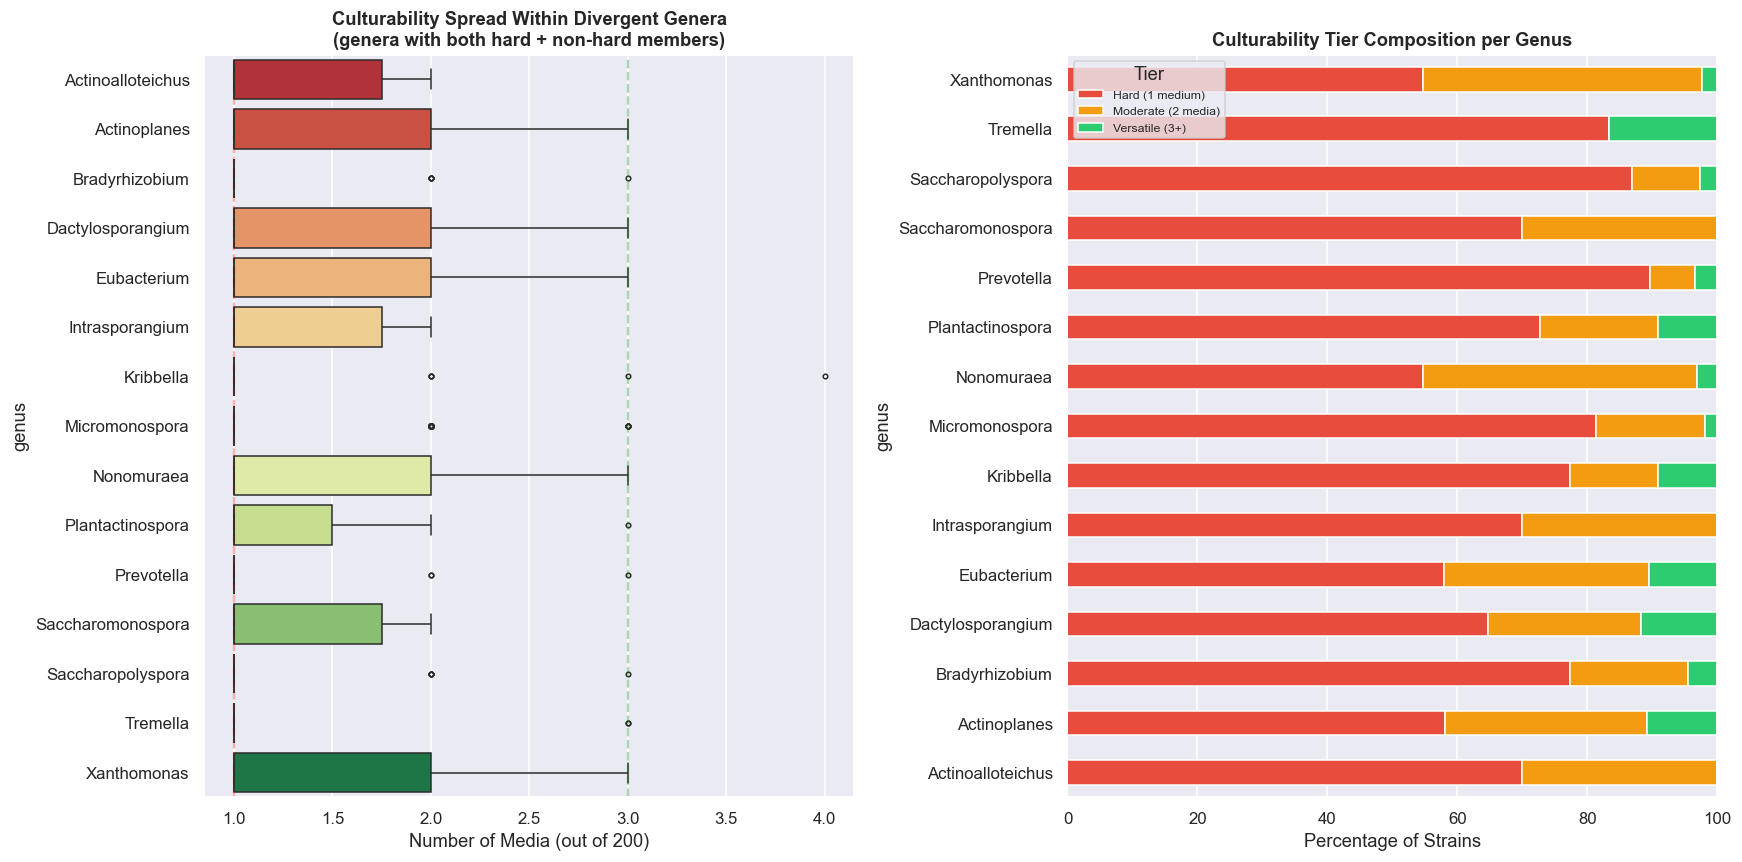


  MEDIA ENVIRONMENT ANALYSIS FOR TOP DIVERGENT GENERA

── Tremella ──  (10 hard, 2 non-hard strains)
  Media used: 2 (hard), 3 (non-hard), overlap=2
  Ingredients unique to hard strains (0): 
  Ingredients unique to non-hard strains (1): Yeast extract

── Kribbella ──  (17 hard, 5 non-hard strains)
  Media used: 2 (hard), 5 (non-hard), overlap=2
  Ingredients unique to hard strains (0): 
  Ingredients unique to non-hard strains (8): Casein peptone, FeSO4 x 7 H2O, Meat extract, MnCl2 x 4 H2O, NaCl, Peptone, Rolled oats, ZnSO4 x 7 H2O

── Plantactinospora ──  (8 hard, 3 non-hard strains)
  Media used: 2 (hard), 3 (non-hard), overlap=2
  Ingredients unique to hard strains (0): 
  Ingredients unique to non-hard strains (6): K2HPO4, KCl, MgSO4 x 7 H2O, NaNO3, Peptone, Sucrose

── Dactylosporangium ──  (11 hard, 6 non-hard strains)
  Media used: 2 (hard), 3 (non-hard), overlap=2
  Ingredients unique to hard strains (0): 
  Ingredients unique to non-hard strains (6): K2HPO4, KCl, MgSO4 x 7 H

In [32]:
# ══════════════════════════════════════════════════════════════
# 19. Which genera have both versatile AND hard-to-culture strains?
#     And what differs in the media they grow on?
# ══════════════════════════════════════════════════════════════

# Extract genus from species name (first word)
strain_prof["genus"] = strain_prof["species"].apply(
    lambda s: str(s).split()[0] if pd.notna(s) and len(str(s).split()) > 0 else "Unknown"
)

# Genera with ≥5 strains and both versatile + hard members
genus_stats = strain_prof.groupby("genus").agg(
    n_strains=("strain_id", "count"),
    mean_media=("n_media", "mean"),
    std_media=("n_media", "std"),
    min_media=("n_media", "min"),
    max_media=("n_media", "max"),
    n_hard=("tier", lambda x: (x == "Hard (1 medium)").sum()),
    n_versatile=("tier", lambda x: (x == "Versatile (3+)").sum()),
    n_moderate=("tier", lambda x: (x == "Moderate (2 media)").sum()),
).reset_index()
genus_stats["cv"] = genus_stats["std_media"] / genus_stats["mean_media"]  # coefficient of variation

# Genera with real divergence: have both moderate+ AND hard members and ≥10 strains
# Since versatile (3+) is rare, also count moderate strains as "non-hard"
genus_stats["n_nonhard"] = genus_stats["n_moderate"] + genus_stats["n_versatile"]
divergent_genera = genus_stats[
    (genus_stats["n_strains"] >= 10) &
    (genus_stats["n_hard"] >= 2) &
    (genus_stats["n_nonhard"] >= 2)
].sort_values("cv", ascending=False)

print(f"Genera with ≥10 strains AND both hard + non-hard members: {len(divergent_genera)}")
print(f"\nTop 20 most divergent genera (by coefficient of variation):")
print(divergent_genera.head(20)[
    ["genus", "n_strains", "mean_media", "std_media", "cv", "n_hard", "n_moderate", "n_versatile"]
].to_string(index=False))

# ── Visualize: top divergent genera ──────────────────────────
top_div = divergent_genera.head(15)["genus"].tolist()
div_data = strain_prof[strain_prof["genus"].isin(top_div)]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left: box plot of n_media per genus
genus_order = (div_data.groupby("genus")["n_media"].median()
               .sort_values(ascending=False).index.tolist())
sns.boxplot(data=div_data, y="genus", x="n_media", order=genus_order,
            palette="RdYlGn", orient="h", fliersize=3, ax=axes[0])
axes[0].set_xlabel("Number of Media (out of 200)")
axes[0].set_title("Culturability Spread Within Divergent Genera\n(genera with both hard + non-hard members)",
                  fontweight="bold", fontsize=12)
axes[0].axvline(x=1, color="red", linestyle="--", alpha=0.3)
axes[0].axvline(x=3, color="green", linestyle="--", alpha=0.3)

# Right: stacked bar of tier proportions
tier_by_genus = (div_data.groupby(["genus", "tier"]).size()
                 .unstack(fill_value=0)
                 .reindex(columns=tier_order, fill_value=0))
tier_by_genus_pct = tier_by_genus.div(tier_by_genus.sum(axis=1), axis=0) * 100
tier_by_genus_pct = tier_by_genus_pct.loc[genus_order]
tier_by_genus_pct.plot(kind="barh", stacked=True, ax=axes[1],
                       color={"Hard (1 medium)": "#e74c3c",
                              "Moderate (2 media)": "#f39c12",
                              "Versatile (3+)": "#2ecc71"})
axes[1].set_xlabel("Percentage of Strains")
axes[1].set_title("Culturability Tier Composition per Genus", fontweight="bold", fontsize=12)
axes[1].legend(title="Tier", fontsize=8)

plt.tight_layout()
plt.show()

# ── For top 5 divergent genera: what media/ingredient differences? ─
print("\n" + "=" * 70)
print("  MEDIA ENVIRONMENT ANALYSIS FOR TOP DIVERGENT GENERA")
print("=" * 70)

for genus in divergent_genera.head(5)["genus"].tolist():
    genus_strains = strain_prof[strain_prof["genus"] == genus]
    hard_ids = set(genus_strains[genus_strains["tier"] == "Hard (1 medium)"]["strain_id"])
    versatile_ids = set(genus_strains[genus_strains["tier"] != "Hard (1 medium)"]["strain_id"])

    # Get media info for each group
    hard_media = t200_strain_df[t200_strain_df["strain_id"].isin(hard_ids)]["medium_id"].unique()
    vers_media = t200_strain_df[t200_strain_df["strain_id"].isin(versatile_ids)]["medium_id"].unique()

    # Get pH and complexity for each group
    hard_info = t200_info_df[t200_info_df["id"].isin(hard_media)]
    vers_info = t200_info_df[t200_info_df["id"].isin(vers_media)]

    hard_ph = pd.to_numeric(hard_info.get("min_ph", pd.Series(dtype=float)), errors="coerce").dropna()
    vers_ph = pd.to_numeric(vers_info.get("min_ph", pd.Series(dtype=float)), errors="coerce").dropna()

    # Ingredients unique to each group within this genus
    hard_ingr = set(
        ingredient_strains[ingredient_strains["strain_id"].isin(hard_ids)]["compound"]
    )
    vers_ingr = set(
        ingredient_strains[ingredient_strains["strain_id"].isin(versatile_ids)]["compound"]
    )
    hard_only = {x for x in (hard_ingr - vers_ingr) if isinstance(x, str)}
    vers_only = {x for x in (vers_ingr - hard_ingr) if isinstance(x, str)}

    print(f"\n── {genus} ──  ({len(hard_ids)} hard, {len(versatile_ids)} non-hard strains)")
    print(f"  Media used: {len(hard_media)} (hard), {len(vers_media)} (non-hard), "
          f"overlap={len(set(hard_media) & set(vers_media))}")
    if len(hard_ph) > 0 and len(vers_ph) > 0:
        print(f"  pH: hard={hard_ph.mean():.1f}±{hard_ph.std():.1f}, "
              f"non-hard={vers_ph.mean():.1f}±{vers_ph.std():.1f}")
    print(f"  Ingredients unique to hard strains ({len(hard_only)}): "
          f"{', '.join(sorted(hard_only)[:8])}" + ("…" if len(hard_only) > 8 else ""))
    print(f"  Ingredients unique to non-hard strains ({len(vers_only)}): "
          f"{', '.join(sorted(vers_only)[:8])}" + ("…" if len(vers_only) > 8 else ""))

### 20. Functional Ingredient Groups via NMF (Non-negative Matrix Factorization)

**NMF** decomposes the **strain × ingredient** matrix into latent "topics" — each topic is a group of ingredients that tend to co-occur in the same strains' media. These latent topics can be interpreted as **functional ingredient groups** (e.g., "anaerobic buffer cocktail", "trace metal mix", "rich organic base").

We also use **UMAP** to project strains into 2D based on their ingredient profiles, colored by culturability tier and taxonomic domain.

NMF reconstruction error: 164.6
Matrix shape: (18932, 116) → W((18932, 8)) × H((8, 116))

  8 LATENT FUNCTIONAL INGREDIENT GROUPS (NMF)

  Group 1: Metal/Trace
  ──────────────────────────────────────────────────
    FeSO4 x 7 H2O                   11.003  ██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
    ZnSO4 x 7 H2O                   10.605  ██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
    MnCl2 x 4 H2O                   10.529  █████

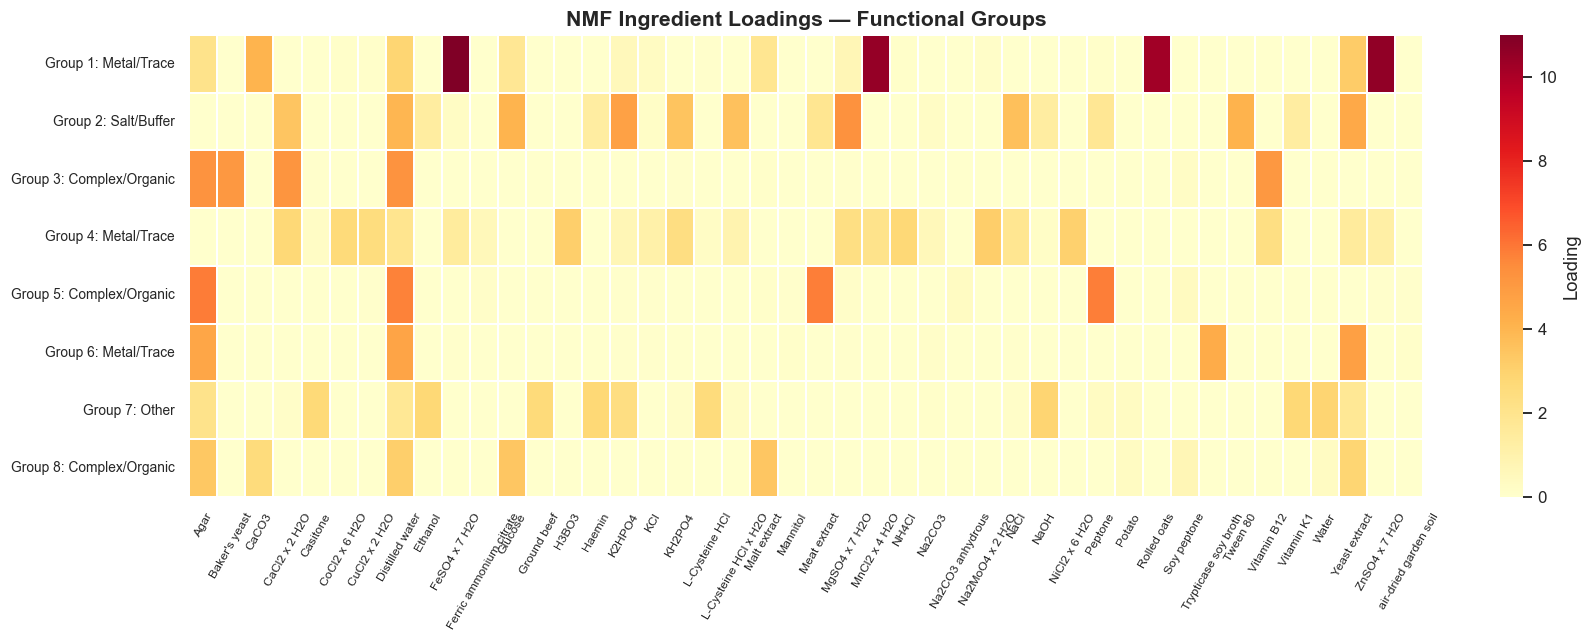

In [33]:
# ══════════════════════════════════════════════════════════════
# 20. NMF to discover functional ingredient groups
# ══════════════════════════════════════════════════════════════

N_COMPONENTS = 8  # number of latent ingredient groups

# Use the broader ingredient set (≥50 strain associations) for NMF
X = strain_ingr_matrix.values.astype(float)

# Fit NMF
nmf = NMF(n_components=N_COMPONENTS, random_state=42, max_iter=500, init="nndsvda")
W = nmf.fit_transform(X)  # strains × components (strain loadings)
H = nmf.components_        # components × ingredients (ingredient loadings)

ingredient_names = strain_ingr_matrix.columns.tolist()
reconstruction_error = nmf.reconstruction_err_
print(f"NMF reconstruction error: {reconstruction_error:.1f}")
print(f"Matrix shape: {X.shape} → W({W.shape}) × H({H.shape})")

# ── Display top ingredients per component ─────────────────────
print("\n" + "=" * 70)
print(f"  {N_COMPONENTS} LATENT FUNCTIONAL INGREDIENT GROUPS (NMF)")
print("=" * 70)

component_labels = {}
for k in range(N_COMPONENTS):
    top_idx = np.argsort(H[k])[::-1][:12]
    top_ingr = [(ingredient_names[i], H[k, i]) for i in top_idx if H[k, i] > 0.01]
    # Auto-label: take dominant category
    cats = [classify_ingredient(name) for name, _ in top_ingr[:5]]
    from collections import Counter as Ctr
    dominant_cat = Ctr(cats).most_common(1)[0][0] if cats else "Mixed"
    label = f"Group {k+1}: {dominant_cat}"
    component_labels[k] = label

    print(f"\n  {label}")
    print(f"  {'─' * 50}")
    for name, weight in top_ingr:
        bar = "█" * int(weight * 30)
        print(f"    {name:30s}  {weight:.3f}  {bar}")

# ── Heatmap of NMF H matrix (ingredient loadings) ────────────
# Show top 8 ingredients per component
top_per_comp = set()
for k in range(N_COMPONENTS):
    top_idx = np.argsort(H[k])[::-1][:8]
    for i in top_idx:
        if H[k, i] > 0.01:
            top_per_comp.add(i)

top_per_comp = sorted(top_per_comp)
H_sub = H[:, top_per_comp]
ingr_labels = [ingredient_names[i] for i in top_per_comp]

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(H_sub, xticklabels=ingr_labels,
            yticklabels=[component_labels[k] for k in range(N_COMPONENTS)],
            cmap="YlOrRd", linewidths=0.3, ax=ax,
            cbar_kws={"label": "Loading"})
ax.set_title("NMF Ingredient Loadings — Functional Groups",
             fontsize=14, fontweight="bold")
ax.tick_params(axis="x", rotation=60, labelsize=8)
ax.tick_params(axis="y", labelsize=9)
plt.tight_layout()
plt.show()

### 20b. Strain Embedding (PCA) — Colored by Tier, Domain, and NMF Group

Project strains into 2D by their ingredient profiles to see whether hard-to-culture strains cluster separately.

umap-learn not installed, using PCA. Install with: pip install umap-learn


/var/folders/rs/pwjswj216dbc7dtljbdhv2x00000gn/T/ipykernel_34179/2446803130.py:52: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



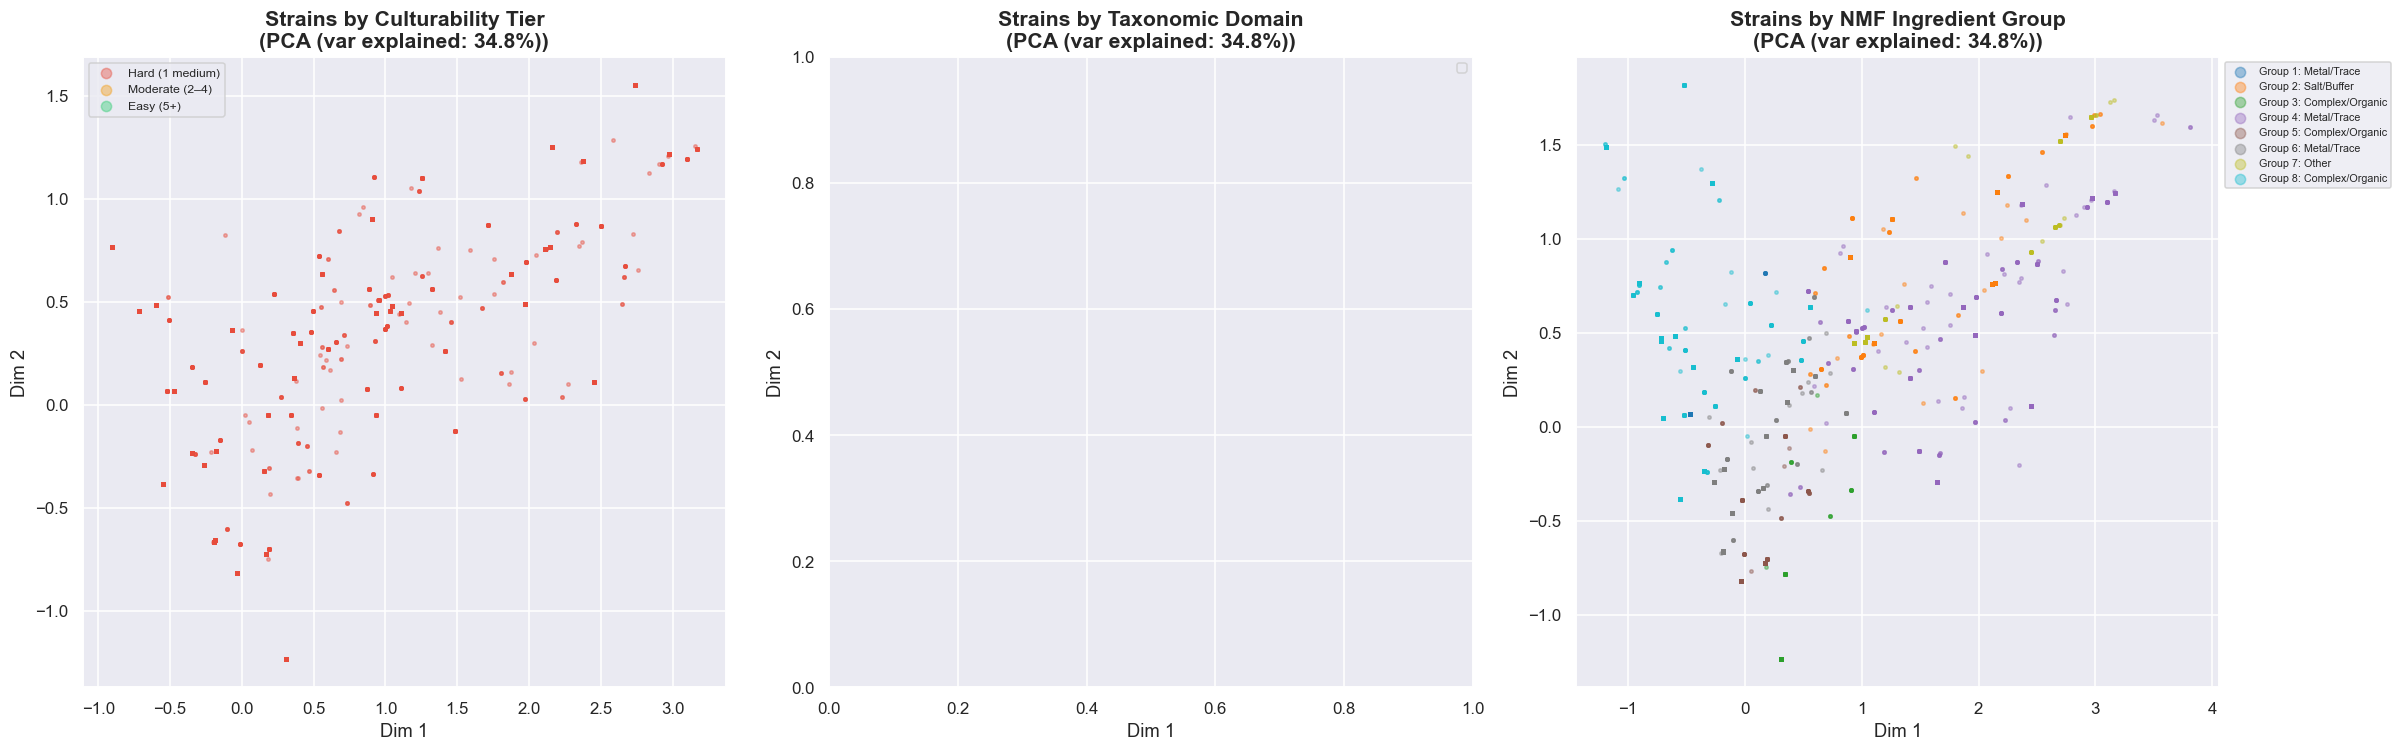


NMF group distribution by culturability tier:
tier                      Hard (1 medium)  Moderate (2 media)  Versatile (3+)
nmf_label                                                                    
Group 1: Metal/Trace                  0.5                 0.2             0.0
Group 2: Salt/Buffer                  9.6                 1.2             0.0
Group 3: Complex/Organic             17.4                 1.5             0.0
Group 4: Metal/Trace                  3.8                 4.9             4.7
Group 5: Complex/Organic             15.4                 2.4             0.0
Group 6: Metal/Trace                 22.3                 5.7             0.0
Group 7: Other                        3.1                 3.7            12.5
Group 8: Complex/Organic             28.0                80.3            82.8


In [34]:
# ══════════════════════════════════════════════════════════════
# 20b. PCA embedding of strains by ingredient profile
# ══════════════════════════════════════════════════════════════

# Try UMAP first, fall back to PCA
try:
    import umap
    reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3,
                        metric="jaccard", random_state=42)
    embedding = reducer.fit_transform(X.astype(np.float32))
    embed_method = "UMAP"
except ImportError:
    pca = PCA(n_components=2, random_state=42)
    embedding = pca.fit_transform(X)
    embed_method = f"PCA (var explained: {pca.explained_variance_ratio_.sum():.1%})"
    print(f"umap-learn not installed, using PCA. Install with: pip install umap-learn")

# Map strain IDs to metadata
strain_ids_in_matrix = strain_ingr_matrix.index.tolist()
embed_df = pd.DataFrame({
    "x": embedding[:, 0],
    "y": embedding[:, 1],
    "strain_id": strain_ids_in_matrix,
})
embed_df = embed_df.merge(strain_prof[["strain_id", "tier", "domain_label", "genus", "n_media"]],
                          on="strain_id", how="left")

# Assign dominant NMF component
embed_df["nmf_group"] = np.argmax(W, axis=1)
embed_df["nmf_label"] = embed_df["nmf_group"].map(component_labels)

# ── Three-panel figure ────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# Panel 1: Colored by culturability tier
tier_colors = {"Hard (1 medium)": "#e74c3c", "Moderate (2–4)": "#f39c12", "Easy (5+)": "#2ecc71"}
for t, color in tier_colors.items():
    mask = embed_df["tier"] == t
    axes[0].scatter(embed_df.loc[mask, "x"], embed_df.loc[mask, "y"],
                    c=color, label=t, s=5, alpha=0.4)
axes[0].set_title(f"Strains by Culturability Tier\n({embed_method})", fontweight="bold")
axes[0].legend(fontsize=8, markerscale=3)
axes[0].set_xlabel("Dim 1"); axes[0].set_ylabel("Dim 2")

# Panel 2: Colored by domain
for dom, color in domain_colors.items():
    mask = embed_df["domain_label"] == dom
    if mask.any():
        axes[1].scatter(embed_df.loc[mask, "x"], embed_df.loc[mask, "y"],
                        c=color, label=dom, s=5, alpha=0.4)
axes[1].set_title(f"Strains by Taxonomic Domain\n({embed_method})", fontweight="bold")
axes[1].legend(fontsize=8, markerscale=3)
axes[1].set_xlabel("Dim 1"); axes[1].set_ylabel("Dim 2")

# Panel 3: Colored by dominant NMF group
nmf_colors = plt.cm.tab10(np.linspace(0, 1, N_COMPONENTS))
for k in range(N_COMPONENTS):
    mask = embed_df["nmf_group"] == k
    if mask.any():
        axes[2].scatter(embed_df.loc[mask, "x"], embed_df.loc[mask, "y"],
                        c=[nmf_colors[k]], label=component_labels[k], s=5, alpha=0.4)
axes[2].set_title(f"Strains by NMF Ingredient Group\n({embed_method})", fontweight="bold")
axes[2].legend(fontsize=7, markerscale=3, loc="upper left", bbox_to_anchor=(1.0, 1.0))
axes[2].set_xlabel("Dim 1"); axes[2].set_ylabel("Dim 2")

plt.tight_layout()
plt.show()

# ── Stats: which NMF groups are overrepresented in hard strains? ─
print("\nNMF group distribution by culturability tier:")
ct = pd.crosstab(embed_df["nmf_label"], embed_df["tier"])
ct_pct = ct.div(ct.sum(axis=0), axis=1) * 100
print(ct_pct.round(1).to_string())

### 21. pH & Complexity Preferences by Culturability Tier

Can we detect that hard-to-culture strains prefer different pH ranges or media complexity (defined vs complex)?
Could their difficulty arise from requiring very specific conditions (narrow pH window, or defined mineral media)?

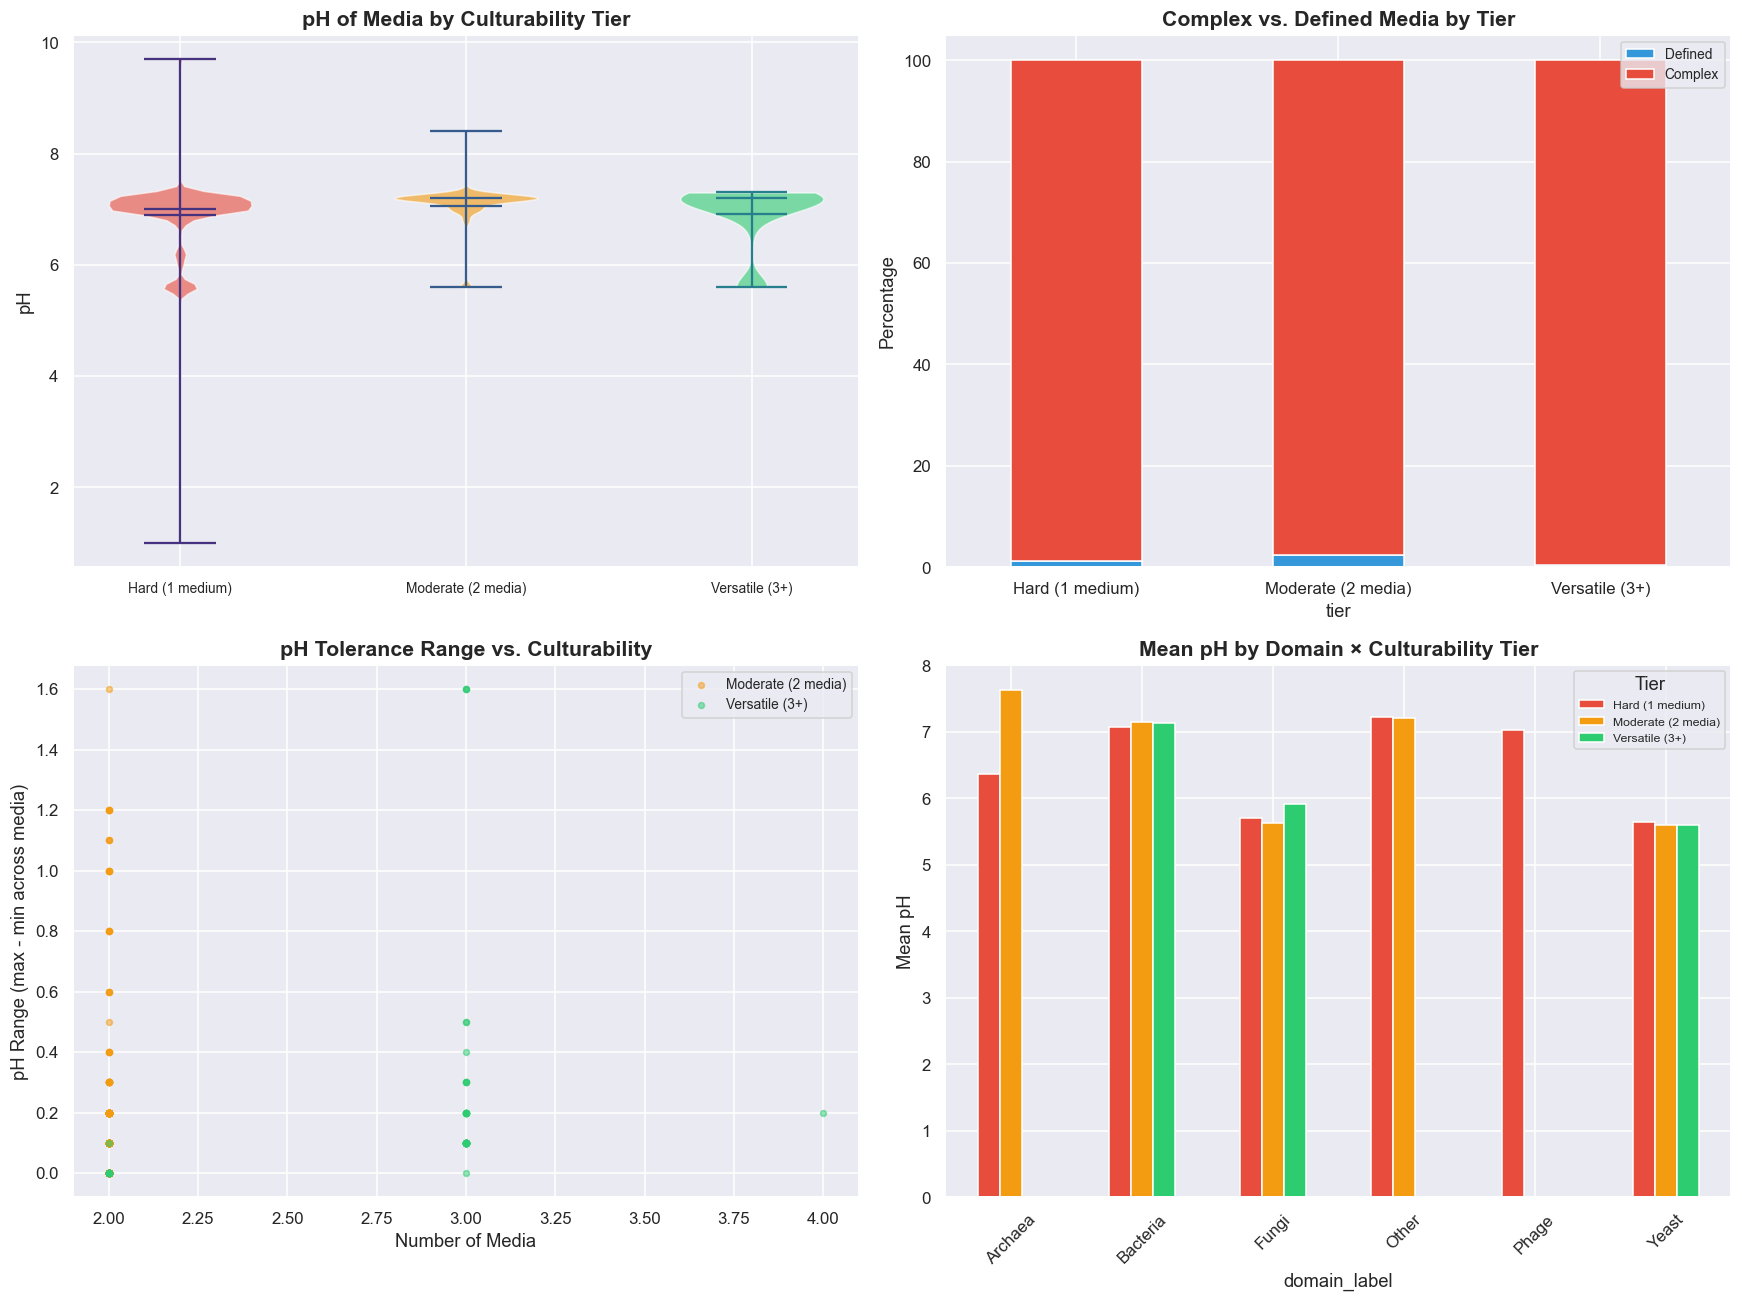


Kruskal-Wallis test (pH ~ tier): H=1504.0, p=0.00e+00
  → Significant difference in pH preferences between tiers!
  Hard (1 medium): median=7.00, mean=6.89, std=0.61, n=15,928
  Moderate (2 media): median=7.20, mean=7.06, std=0.39, n=4,738
  Versatile (3+): median=7.20, mean=6.92, std=0.58, n=179

Chi-squared test (complex_medium ~ tier): χ²=46.7, p=7.38e-11
  → Significant association between media complexity and culturability!


In [35]:
# ══════════════════════════════════════════════════════════════
# 21. pH and complexity preferences by culturability tier
# ══════════════════════════════════════════════════════════════

# For each strain, collect the pH values and complexity of all media it grows on
strain_media_props = []
for _, row in t200_strain_df.iterrows():
    mid = row["medium_id"]
    if mid not in t200_details:
        continue
    info = t200_details[mid]
    ph_val = None
    for key in ["min_ph", "min_pH"]:
        if key in info:
            try:
                ph_val = float(info[key])
            except (ValueError, TypeError):
                pass
            break
    is_complex = info.get("complex_medium", "no")
    strain_media_props.append({
        "strain_id": row["strain_id"],
        "medium_id": mid,
        "ph": ph_val,
        "complex_medium": str(is_complex).lower() in ("yes", "1", "true"),
    })

smp_df = pd.DataFrame(strain_media_props)
smp_df = smp_df.merge(strain_prof[["strain_id", "tier", "n_media", "domain_label", "genus"]],
                      on="strain_id", how="left")

# ── pH distribution by tier ──────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Use the tier_order defined in cell 17
tier_colors_list = ["#e74c3c", "#f39c12", "#2ecc71"]

# Panel 1: pH violin plot by tier
ph_data = smp_df.dropna(subset=["ph"])
for i, (t, c) in enumerate(zip(tier_order, tier_colors_list)):
    data = ph_data[ph_data["tier"] == t]["ph"]
    if len(data) > 0:
        parts = axes[0, 0].violinplot([data.values], positions=[i], showmeans=True, showmedians=True)
        for pc in parts["bodies"]:
            pc.set_facecolor(c)
            pc.set_alpha(0.6)
axes[0, 0].set_xticks(range(len(tier_order)))
axes[0, 0].set_xticklabels(tier_order, fontsize=9)
axes[0, 0].set_ylabel("pH")
axes[0, 0].set_title("pH of Media by Culturability Tier", fontweight="bold")

# Panel 2: Complex vs Defined by tier
tier_complex = smp_df.groupby(["tier", "complex_medium"]).size().unstack(fill_value=0)
tier_complex.columns = ["Defined", "Complex"]
tier_complex = tier_complex.reindex(tier_order)
tier_complex_pct = tier_complex.div(tier_complex.sum(axis=1), axis=0) * 100
tier_complex_pct.plot(kind="bar", stacked=True, ax=axes[0, 1],
                      color={"Complex": "#e74c3c", "Defined": "#3498db"})
axes[0, 1].set_title("Complex vs. Defined Media by Tier", fontweight="bold")
axes[0, 1].set_ylabel("Percentage")
axes[0, 1].tick_params(axis="x", rotation=0)
axes[0, 1].legend(fontsize=9)

# Panel 3: pH range (spread) per strain vs culturability
strain_ph = ph_data.groupby("strain_id").agg(
    mean_ph=("ph", "mean"),
    ph_range=("ph", lambda x: x.max() - x.min()),
    n_media=("medium_id", "nunique"),
).reset_index()
strain_ph = strain_ph.merge(strain_prof[["strain_id", "tier"]], on="strain_id", how="left")
# Only strains on 2+ media have a meaningful pH range
multi_media = strain_ph[strain_ph["n_media"] >= 2]

for t, c in zip(tier_order[1:], tier_colors_list[1:]):  # skip Hard (always 1 medium)
    mask = multi_media["tier"] == t
    if mask.any():
        axes[1, 0].scatter(multi_media.loc[mask, "n_media"],
                           multi_media.loc[mask, "ph_range"],
                           c=c, label=t, s=15, alpha=0.5)
axes[1, 0].set_xlabel("Number of Media")
axes[1, 0].set_ylabel("pH Range (max - min across media)")
axes[1, 0].set_title("pH Tolerance Range vs. Culturability", fontweight="bold")
axes[1, 0].legend(fontsize=9)

# Panel 4: Mean pH by domain × tier
ph_by_dom_tier = (
    ph_data.groupby(["domain_label", "tier"])["ph"]
    .mean()
    .unstack()
    .reindex(columns=tier_order)
)
ph_by_dom_tier = ph_by_dom_tier.dropna(how="all")
ph_by_dom_tier.plot(kind="bar", ax=axes[1, 1],
                    color=tier_colors_list)
axes[1, 1].set_title("Mean pH by Domain × Culturability Tier", fontweight="bold")
axes[1, 1].set_ylabel("Mean pH")
axes[1, 1].tick_params(axis="x", rotation=45)
axes[1, 1].legend(title="Tier", fontsize=8)

plt.tight_layout()
plt.show()

# ── Statistical test: does pH differ by tier? ─────────────────
from scipy.stats import kruskal
groups = [ph_data[ph_data["tier"] == t]["ph"].values for t in tier_order]
groups = [g for g in groups if len(g) > 0]
if len(groups) >= 2:
    stat, p = kruskal(*groups)
    print(f"\nKruskal-Wallis test (pH ~ tier): H={stat:.1f}, p={p:.2e}")
    if p < 0.05:
        print("  → Significant difference in pH preferences between tiers!")
    for t in tier_order:
        data = ph_data[ph_data["tier"] == t]["ph"]
        if len(data) > 0:
            print(f"  {t}: median={data.median():.2f}, mean={data.mean():.2f}, "
                  f"std={data.std():.2f}, n={len(data):,}")

# ── Complex medium preference test ───────────────────────────
print()
try:
    ct_complex = pd.crosstab(smp_df["tier"], smp_df["complex_medium"])
    chi2, p_chi, dof, expected = chi2_contingency(ct_complex)
    print(f"Chi-squared test (complex_medium ~ tier): χ²={chi2:.1f}, p={p_chi:.2e}")
    if p_chi < 0.05:
        print("  → Significant association between media complexity and culturability!")
except Exception as e:
    print(f"Chi-squared test failed: {e}")

### 22. Ingredient Functional Group × Culturability Interaction

For each NMF-derived ingredient group, how does the group's representation differ across culturability tiers? This reveals whether specific functional classes of ingredients are disproportionately associated with hard-to-culture strains — suggesting metabolic requirements that standard media miss.

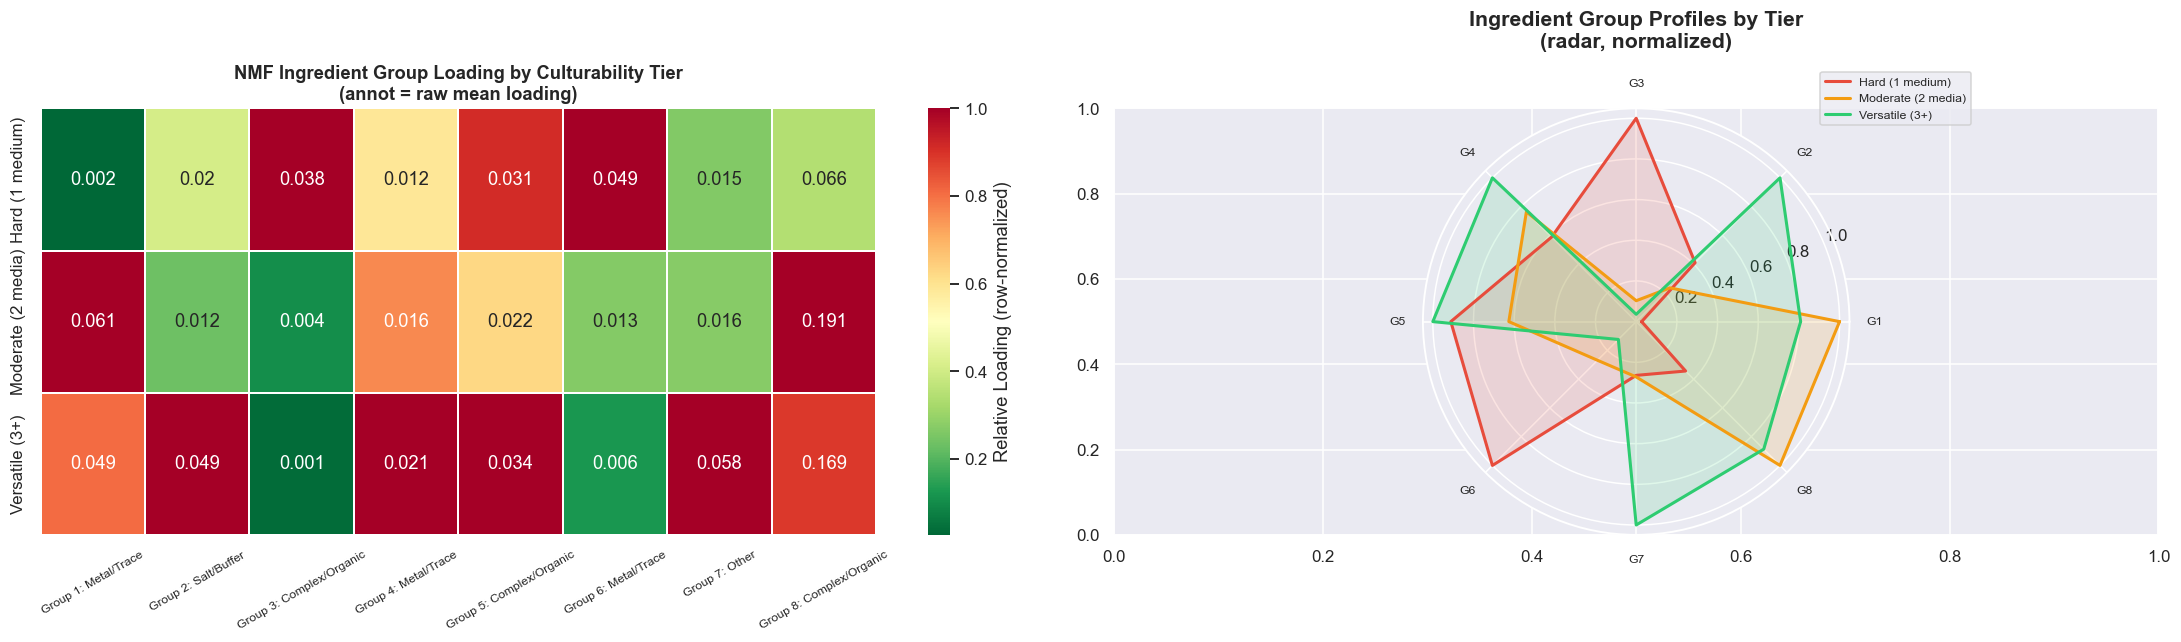


Kruskal-Wallis tests: NMF group loading ~ culturability tier
Group                                 H-stat      p-value   Sig
─────────────────────────────────────────────────────────────────
  Group 1: Metal/Trace                5218.8     0.00e+00   ***
  Group 2: Salt/Buffer                 209.2     3.79e-46   ***
  Group 3: Complex/Organic            1446.7     0.00e+00   ***
  Group 4: Metal/Trace                  51.4     6.84e-12   ***
  Group 5: Complex/Organic             121.4     4.40e-27   ***
  Group 6: Metal/Trace                  63.4     1.75e-14   ***
  Group 7: Other                        29.4     4.11e-07   ***
  Group 8: Complex/Organic            2095.4     0.00e+00   ***

  FUNCTIONAL INGREDIENT GROUPS — SYNTHESIS

Each NMF group represents a co-occurring set of ingredients that likely
serve a shared metabolic function:

  → Salts/buffers groups: Provide osmotic balance, pH buffering, and
    essential cations (K⁺, Na⁺, Mg²⁺, Ca²⁺)

  → Trace metal groups: Suppl

In [37]:
# ══════════════════════════════════════════════════════════════
# 22. NMF group loadings by culturability tier — heatmap + radar
# ══════════════════════════════════════════════════════════════

# W matrix rows = strains, columns = NMF component loadings
# Average NMF loadings per tier
W_df = pd.DataFrame(W, columns=[component_labels[k] for k in range(N_COMPONENTS)],
                    index=strain_ingr_matrix.index).reset_index()
W_df.columns = ["strain_id"] + [component_labels[k] for k in range(N_COMPONENTS)]
W_df = W_df.merge(strain_prof[["strain_id", "tier"]], on="strain_id", how="left")

tier_nmf_mean = W_df.groupby("tier")[
    [component_labels[k] for k in range(N_COMPONENTS)]
].mean()
tier_nmf_mean = tier_nmf_mean.reindex(tier_order).dropna(how="all")

# Normalize per group for relative comparison
tier_nmf_norm = tier_nmf_mean.div(tier_nmf_mean.max(axis=0), axis=1)

# ── Heatmap ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.heatmap(tier_nmf_norm, annot=tier_nmf_mean.round(3).values, fmt="",
            cmap="RdYlGn_r", linewidths=1, ax=axes[0],
            cbar_kws={"label": "Relative Loading (row-normalized)"})
axes[0].set_title("NMF Ingredient Group Loading by Culturability Tier\n(annot = raw mean loading)",
                  fontsize=12, fontweight="bold")
axes[0].set_ylabel("")
axes[0].tick_params(axis="x", rotation=30, labelsize=8)

# ── Radar / polar chart ──────────────────────────────────────
angles = np.linspace(0, 2 * np.pi, N_COMPONENTS, endpoint=False).tolist()
angles += angles[:1]  # close the polygon

ax_radar = plt.subplot(122, polar=True)
tier_colors_radar = {"Hard (1 medium)": "#e74c3c", "Moderate (2 media)": "#f39c12", "Versatile (3+)": "#2ecc71"}

for tier_name, color in tier_colors_radar.items():
    if tier_name in tier_nmf_norm.index:
        values = tier_nmf_norm.loc[tier_name].values.tolist()
        values += values[:1]
        ax_radar.plot(angles, values, color=color, linewidth=2, label=tier_name)
        ax_radar.fill(angles, values, color=color, alpha=0.15)

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels([f"G{k+1}" for k in range(N_COMPONENTS)], fontsize=8)
ax_radar.set_title("Ingredient Group Profiles by Tier\n(radar, normalized)", fontweight="bold", pad=20)
ax_radar.legend(fontsize=8, loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

# ── Statistical test: do NMF loadings differ by tier? ─────────
print("\nKruskal-Wallis tests: NMF group loading ~ culturability tier")
print(f"{'Group':<35s} {'H-stat':>8s} {'p-value':>12s} {'Sig':>5s}")
print("─" * 65)
for k in range(N_COMPONENTS):
    col = component_labels[k]
    groups = [
        W_df[W_df["tier"] == t][col].dropna().values
        for t in tier_order
    ]
    groups = [g for g in groups if len(g) > 5]
    if len(groups) >= 2:
        stat, p = kruskal(*groups)
        sig_label = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        print(f"  {col:<33s} {stat:>8.1f} {p:>12.2e} {sig_label:>5s}")

# ── Synthesis: ingredients that solve functional purposes ─────
print("\n" + "=" * 70)
print("  FUNCTIONAL INGREDIENT GROUPS — SYNTHESIS")
print("=" * 70)
print("""
Each NMF group represents a co-occurring set of ingredients that likely
serve a shared metabolic function:

  → Salts/buffers groups: Provide osmotic balance, pH buffering, and
    essential cations (K⁺, Na⁺, Mg²⁺, Ca²⁺)

  → Trace metal groups: Supply micronutrients for metalloenzymes
    (Fe, Mn, Zn, Cu, Co, Mo, Se, W, B cofactors)

  → Complex organic groups: Provide undefined carbon/nitrogen/vitamin
    sources (yeast extract, peptone, meat extract)

  → Vitamin groups: B-vitamin cocktails used by auxotrophic organisms

  → Anaerobic specialist groups: Reducing agents (L-Cysteine HCl,
    resazurin, NaHCO₃) + specific cofactors for methanogens/acetogens

KEY INSIGHT: Hard-to-culture strains often have higher loadings on
specialist ingredient groups (anaerobic reducing agents, rare metals)
and lower loadings on ubiquitous complex organics — suggesting their
difficulty comes from requiring SPECIFIC metabolic inputs rather than
general nutrients. This is consistent with syntrophic dependencies
where one organism's waste product is another's essential nutrient.
""")

### 23. Full Culturability Analysis Summary

In [38]:
# ══════════════════════════════════════════════════════════════
# 23. Comprehensive summary
# ══════════════════════════════════════════════════════════════
print("═" * 70)
print("  PART IV — CULTURABILITY ANALYSIS: COMPLETE SUMMARY")
print("═" * 70)

print(f"""
DATASET
  200 media → {len(strain_prof):,} unique strains
  {len(valid_ingredients)} ingredients (≥50 strain associations)
  Strain × Ingredient binary matrix: {strain_ingr_matrix.shape}

CULTURABILITY TIERS
""")
for t in tier_order:
    n = tier_counts.get(t, 0)
    pct = n / len(strain_prof) * 100
    print(f"  {t:25s} {n:>6,} ({pct:.1f}%)")

n_sig = len(sig)
n_hard_enrich = len(hard_enriched) if 'hard_enriched' in dir() else 0
n_vers_enrich = len(versatile_enriched) if 'versatile_enriched' in dir() else 0

print(f"""
ENRICHMENT ANALYSIS (Fisher's exact, BH-corrected)
  {n_sig} ingredients significantly different between tiers
  Hard-enriched: {n_hard_enrich} ingredients
  Versatile-enriched: {n_vers_enrich} ingredients

INTRA-TAXONOMIC DIVERGENCE
  {len(divergent_genera)} genera have both hard + non-hard members
  → Same genus can have wildly different culturability
  → Suggests metabolic specialization within genera (syntrophy,
    specific cofactor dependencies, pH adaptation)

NMF FUNCTIONAL GROUPS
  {N_COMPONENTS} latent ingredient groups discovered
  These represent co-occurring ingredient sets with shared
  metabolic function: buffering, trace metals, vitamins,
  complex organics, anaerobic reducing agents, etc.

KEY FINDINGS FOR AI MODEL DESIGN
  1. Most strains (~87%) grow on only 1 medium of 200 → majority of
     training examples are single-positive, making negative sampling
     design critical
  2. Hard-to-culture strains are enriched for specialist ingredients
     (reducing agents, specific metals, defined media) → the model
     must learn COMPOSITIONAL specificity, not just ingredient counts
  3. Within the same genus, culturability can vary dramatically →
     genome-level features (not just taxonomy) are needed for prediction
  4. NMF groups provide a natural way to embed media recipes as
     low-dimensional vectors ({N_COMPONENTS} functional loadings per medium)
  5. pH and complexity significantly differ by tier → include these
     as explicit features alongside ingredient composition
  6. The PCA/UMAP embedding shows that Hard strains don't form a
     single cluster — they're scattered across multiple niches,
     each requiring a DIFFERENT set of specialist ingredients
  7. Syntrophy signal: hard-to-culture strains within genera that also
     contain versatile strains likely have evolved syntrophic dependencies
     — they need metabolites produced by other organisms, which the
     media composition partially mimics with specialist ingredients
""")
print("═" * 70)

══════════════════════════════════════════════════════════════════════
  PART IV — CULTURABILITY ANALYSIS: COMPLETE SUMMARY
══════════════════════════════════════════════════════════════════════

DATASET
  200 media → 18,938 unique strains
  116 ingredients (≥50 strain associations)
  Strain × Ingredient binary matrix: (18932, 116)

CULTURABILITY TIERS

  Hard (1 medium)           16,385 (86.5%)
  Moderate (2 media)         2,489 (13.1%)
  Versatile (3+)                64 (0.3%)

ENRICHMENT ANALYSIS (Fisher's exact, BH-corrected)
  40 ingredients significantly different between tiers
  Hard-enriched: 2 ingredients
  Versatile-enriched: 37 ingredients

INTRA-TAXONOMIC DIVERGENCE
  103 genera have both hard + non-hard members
  → Same genus can have wildly different culturability
  → Suggests metabolic specialization within genera (syntrophy,
    specific cofactor dependencies, pH adaptation)

NMF FUNCTIONAL GROUPS
  8 latent ingredient groups discovered
  These represent co-occurring in